In [1]:
import random

# StringIO behaves like a file object 
from io import StringIO 

from pandas import DataFrame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import load_boston
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sb

import copy

import joblib

%matplotlib inline 

In [2]:

print(joblib.__file__)

/Users/jonatasilva/Documents/ProjetosPython/python/venv37/lib/python3.7/site-packages/joblib/__init__.py


In [3]:
class CqkProblem:
    def __init__(self, r, n, d, a, b, low, up):
        self.n = n
        self.r = r
        self.d = list(d)
        self.a = list(a)
        self.b = list(b)
        self.low = list(low)
        self.up = list(up)

In [4]:
def generate_cqk_problem_uncorrelated(n):
    d = []
    low = []
    up = []
    b = []
    a = []
    temp = 0
    lb = 0.0
    ub = 0.0
    lower = 10
    upper = 25
    r = 0

    for i in range(n):
        
        b.append(10 + 14*random.random())
        low.append(1 + 14*random.random())
        up.append(1 + 14*random.random())
        if low[i] > up[i]:
            temp = low[i]
            low[i] = up[i]
            up[i] = temp
        
        lb = lb + b[i]*low[i];
        ub = ub + b[i]*up[i];
        
        #Uncorrelated
        d.append(random.randint(10,25))
        a.append(random.randint(10,25))
        
    r = lb + (ub - lb)*0.7;
    
    return CqkProblem( r, n, d, a, b, low, up)

def generate_cqk_problem_correlated(n):
    d = []
    low = []
    up = []
    b = []
    a = []
    temp = 0
    lb = 0.0
    ub = 0.0
    lower = 10
    upper = 25
    r = 0

    for i in range(n):
        
        b.append(10 + 14*random.random())
        low.append(1 + 14*random.random())
        up.append(1 + 14*random.random())
        if low[i] > up[i]:
            temp = low[i]
            low[i] = up[i]
            up[i] = temp
        
        lb = lb + b[i]*low[i];
        ub = ub + b[i]*up[i];
        
        # correlated:
        
        d.append(b[i] + 5.0)
        a.append(b[i] + 5.0)
        
        
        
    r = lb + (ub - lb)*0.7;
    
    return CqkProblem( r, n, d, a, b, low, up)

In [5]:

def initial_lambda(p, lamb):
    s0=0.0
    q0=0.0
    slopes = []
    for i in range(p.n):
        slopes.append((p.b[i]/p.d[i])*p.b[i])
        s0 = s0 + (p.a[i] * p.b[i]) / p.d[i]
        q0 = q0 + (p.b[i] * p.b[i]) / p.d[i]
    lamb = (p.r-s0)/q0
    return lamb, slopes

In [6]:
def phi_lambda(p,lamb,phi,deriv,slopes,r):
    deriv = 0.0
    phi = r * -1
    x = []
    
    for i in range(p.n):
        
        x.append( (p.b[i] * lamb + p.a[i])/p.d[i])

        if x[i] < p.low[i]:
            x[i] = p.low[i]
        elif x[i] > p.up[i]:
            x[i] = p.up[i]
        else:
            deriv = deriv + slopes[i];
        phi = phi + p.b[i] * x[i];
    return deriv, phi, x

In [7]:
MAX_IT = 20
INFINITO_NEGATIVO = -999999999;
INFINITO_POSITIVO = 999999999;

def newton(p):
    lambs = [] 
    phis = []
    derivs = []
    phi = 0
    lamb = 0
    alfa = INFINITO_NEGATIVO;
    beta = INFINITO_POSITIVO;
    phi_alfa = 0.0;
    phi_beta = 0.0;
    deriv = 0
    x = []
    r = p.r
    
    lamb, slopes = initial_lambda(p,lamb)
    deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
    lambs.append(lamb)
    derivs.append(deriv)
    phis.append(phi)
    it = 1
#     print(it, deriv, phi,lamb)
    negativo = False
    while phi != 0.0 and it <= MAX_IT:
        if phi > 0:
#             print("positivo")
            beta = lamb
            lambda_n = 0.0
            if deriv > 0.0:
                
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                if lambda_n > alfa:
                    lamb = lambda_n
                else:
#                     print("aqui")
                    phi_beta = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_left(p,lamb);
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
                
        else:
            if it == 1:
                negativo = True
#             print("negativo")
            alfa = lamb;
            lambda_n = 0.0;

            if deriv > 0.0:
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                
                if lambda_n < beta:
                    lamb = lambda_n
                else:
#                     print("aqui")
                    phi_alfa = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_right(p,lamb)
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
        
        
        deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
        it = it + 1
        lambs.append(lamb)
        derivs.append(deriv)
        phis.append(phi)
        
    if phi == 0.0:
        return it,lambs, derivs, phis,slopes
    elif alfa == beta:
        return -1,lambs, derivs, phis,slopes
    else:
        return -2,lambs, derivs, phis,slopes

In [8]:
MAX_IT = 20
INFINITO_NEGATIVO = -999999999;
INFINITO_POSITIVO = 999999999;

def newton_new_lamb(p,lamb,phi,deriv,slopes):
    lambs = [] 
    phis = []
    derivs = []
    alfa = INFINITO_NEGATIVO;
    beta = INFINITO_POSITIVO;
    phi_alfa = 0.0;
    phi_beta = 0.0;
    deriv = 0
    x = []
    r = p.r
    
    deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
    lambs.append(lamb)
    derivs.append(deriv)
    phis.append(phi)
    it = 1
#     print(it, deriv, phi,lamb)
    while phi != 0.0 and it <= MAX_IT:
        if phi > 0:
#             print("positivo")
            beta = lamb
            lambda_n = 0.0
            if deriv > 0.0:
                
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                if lambda_n > alfa:
                    lamb = lambda_n
                else:
#                     print("aqui")
                    phi_beta = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_left(p,lamb);
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
                
        else:
#             print("negativo")
            alfa = lamb;
            lambda_n = 0.0;

            if deriv > 0.0:
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                
                if lambda_n < beta:
                    lamb = lambda_n
                else:
#                     print("aqui")
                    phi_alfa = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_right(p,lamb)
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
        
        
        deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
        it = it + 1
        lambs.append(lamb)
        derivs.append(deriv)
        phis.append(phi)
        
    if phi == 0.0:
        return it,lambs, derivs, phis,slopes
    elif alfa == beta:
        return -1,lambs, derivs, phis,slopes
    else:
        return -2,lambs, derivs, phis,slopes

In [9]:
lista = []
for i in range(1):
    n = 10000
    p = generate_cqk_problem_correlated(n)
    it,lambs, derivs, phis,slopes = newton(p)
    soma_a = 0
    soma_b = 0
    soma_low = 0
    soma_d = 0
    soma_up = 0
    for i in range(n):
        soma_a += p.a[i]
        soma_b += p.b[i]
        soma_low += p.low[i]
        soma_d += p.d[i]
        soma_up += p.up[i]
    soma_a = soma_a/n
    soma_b = soma_b/n
    soma_low = soma_low/n
    soma_d = soma_d/n
    soma_up = soma_up/n
    r = p.r/n
    
    new_deriv = []
    new_phi = []
    new_lamb = []
    add_lamb = 5
    for i in range(3):
#         newLamb = lambs[i+1]+random.uniform(-0.1, 0.1)
        newLamb = add_lamb
        deriv, phi, x = phi_lambda(p,newLamb,0,0,slopes,p.r)
        new_deriv.append(deriv)
        new_phi.append(phi)
        new_lamb.append(newLamb)
        add_lamb += 2
        
    sum_slopes = sum(slopes)
    if it > 3:
        l_rs = [new_lamb[0],new_phi[0],new_deriv[0],new_lamb[1],new_phi[1],new_deriv[1],new_lamb[2],new_phi[2],new_deriv[2],lambs[-1]]


#         l_rs = [soma_a, soma_b, soma_d, r,lambs[0],phis[0],derivs[0],sum_slopes,lambs[1],phis[1],derivs[1],lambs[2],lambs[3],lambs[-1]]
#         l_rs = [soma_a, soma_b, soma_d, r,lambs[0],lambs[1],lambs[2],lambs[3],lambs[-1]]


        lista.append(l_rs)

In [10]:
np.savetxt('instance_test.txt', lista, delimiter = ' ',newline='\n', fmt="%f")

In [23]:
c = ''
with open("test_number_9_10_apenas.txt", "r") as fd:
    c = StringIO(fd.read())
    
d = c.read()
c = StringIO(d) 
d = np.loadtxt(c) 
feature_names = ['9','10','final_lamb']
# feature_names = ['second_lamb','second_phi','second_deriv','third_lamb','third_phi','third_deriv','fourth_lamb','fourth_phi','fourth_deriv','final_lamb']
# 
# feature_names = ['a','b','d','r','inicital_lamb','second_lamb','third_lamb','fourth_lamb','final_lamb']


knapsack = {"data":d, "feature_names": feature_names}
dataset = pd.DataFrame(knapsack['data'], columns = knapsack['feature_names'])

In [21]:
# Coletando x e y

X = dataset.iloc[:,:-1]
y = dataset['final_lamb'].values

In [22]:
dataset

,phi-11,s,final_lamb
0,11516.765565,58810.401820,8.781304
1,10788.134706,57739.848840,8.791802
2,9360.533744,57098.647305,8.823496
3,12169.717208,60661.391026,8.775503
4,8595.188800,56701.116330,8.839068
...,...,...,...
9995,13763.245923,60728.626409,8.734889
9996,7966.956837,55332.689024,8.845568
9997,3240.113655,51439.090662,8.938663
9998,3974.820355,52747.467883,8.925512


In [405]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [406]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [407]:
# Padronização
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [408]:
# Aplicando a padronização aos dados
X_train_p = scaler.transform(X_train)
X_test_p = scaler.transform(X_test)

In [409]:
# joblib.dump(scaler, 'scaler_final_lamb.bin', compress=True)

In [410]:

# from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

In [411]:
# mlp = MLPClassifier(hidden_layer_sizes = (30,30,30))
regr = MLPRegressor(hidden_layer_sizes=(500,),activation='identity',random_state=1, max_iter=10000,
                    tol=1e-50, epsilon=1e-50,alpha=1e-50).fit(X_train_p, y_train)



In [412]:
# model = 'model_final_lamb.sav'
# joblib.dump(regr, model)

In [413]:
regr.fit(X_train_p, y_train)

MLPRegressor(activation='identity', alpha=1e-50, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-50,
             hidden_layer_sizes=(500,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='adam',
             tol=1e-50, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [414]:
regr.predict(X_test_p[:20])

array([11.49034939, 11.48203354, 11.52232834, 11.50530989, 11.5291802 ,
       11.51233857, 11.60897019, 11.5360298 , 11.45941039, 11.5423607 ,
       11.51301225, 11.50110406, 11.53972163, 11.50056183, 11.4715752 ,
       11.45971091, 11.51791002, 11.49732736, 11.51399301, 11.55045694])

In [415]:
regr.score(X_test_p, y_test)

0.9998520955326132

In [416]:
y_test[:20]

array([11.490377, 11.482121, 11.522707, 11.505303, 11.529227, 11.512275,
       11.607296, 11.536068, 11.459725, 11.542376, 11.513012, 11.501157,
       11.539979, 11.50062 , 11.472047, 11.460277, 11.517678, 11.497411,
       11.514373, 11.550924])

In [235]:
def phi_lambda_two(p,lamb3,r):
    
    slopes = []
    
    deriv2 = 0
    phi2 = r * -1
    
    deriv3 = 0
    phi3 = r * -1

    x3 = []
    x2 = []
    
    for i in range(p.n):
        
        slopes.append((p.b[i]/p.d[i])*p.b[i])
        
#         x1.append( (p.b[i] * lamb1 + p.a[i])/p.d[i])

#         if x1[i] < p.low[i]:
#             x1[i] = p.low[i]
#         elif x1[i] > p.up[i]:
#             x1[i] = p.up[i]
#         else:
#             deriv1 = deriv1 + slopes[i];
#         phi1 = phi1 + p.b[i] * x1[i];
        
#         ########
        
#         x2.append( (p.b[i] * lamb2 + p.a[i])/p.d[i])

#         if x2[i] < p.low[i]:
#             x2[i] = p.low[i]
#         elif x2[i] > p.up[i]:
#             x2[i] = p.up[i]
#         else:
#             deriv2 = deriv2 + slopes[i];
#         phi2 = phi2 + p.b[i] * x2[i];
        
        #########
        
        x3.append( (p.b[i] * lamb3 + p.a[i])/p.d[i])

        if x3[i] < p.low[i]:
            x3[i] = p.low[i]
        elif x3[i] > p.up[i]:
            x3[i] = p.up[i]
        else:
            deriv3 = deriv3 + slopes[i];
        phi3 = phi3 + p.b[i] * x3[i];

            
    return deriv3,phi3,slopes

In [262]:
%%time
n = 1000000
pp = generate_cqk_problem_correlated(n)
itt,lambss, derivss, phiss,slopess = newton(pp)


CPU times: user 9.24 s, sys: 335 ms, total: 9.57 s
Wall time: 10.1 s


In [263]:
itt,lambss, phiss

(5,
 [10.236222786183887,
  11.479189757192138,
  11.513641004475636,
  11.513681839530298,
  11.513681839559577],
 [-8007060.590782581,
  -208845.84670667347,
  -246.96317439023346,
  -0.0001770763585398072,
  -1.7376403036450938e-06])

In [264]:
%%time
deriv3, phi3,slopess= phi_lambda_two(pp,11.5,pp.r)



result = regr.predict(scaler.transform(np.asarray([[phi3/100]])))[0]

itt,lambss, derivss, phiss,slopess = newton_new_lamb(pp,result,deriv3, phi3,slopess)


CPU times: user 8.46 s, sys: 135 ms, total: 8.59 s
Wall time: 9.07 s


In [265]:
result

11.513616418092333

In [266]:
lambss

[11.513616418092333, 11.513681839529712, 11.513681839559597]

In [103]:
dataset['phi-9'].corr(dataset['final_lamb'])

-0.9998951196516883

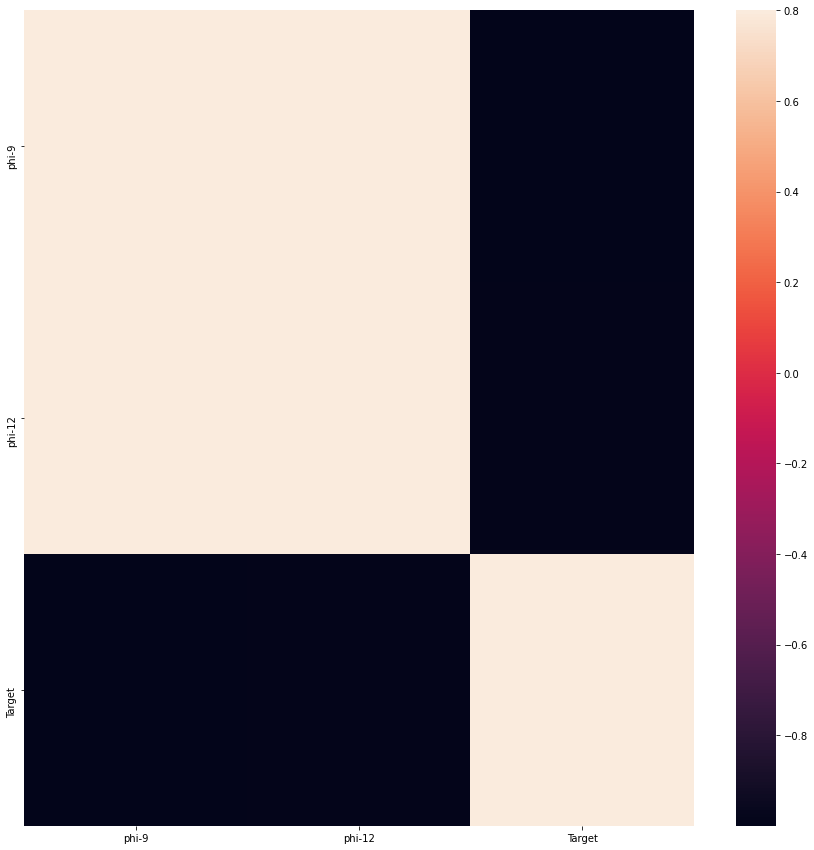

In [144]:
train_data = dataset.iloc[:,:-1]
train_data['Target'] = dataset['final_lamb']
# train_data = dataset[8]
# train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = False)
plt.show()

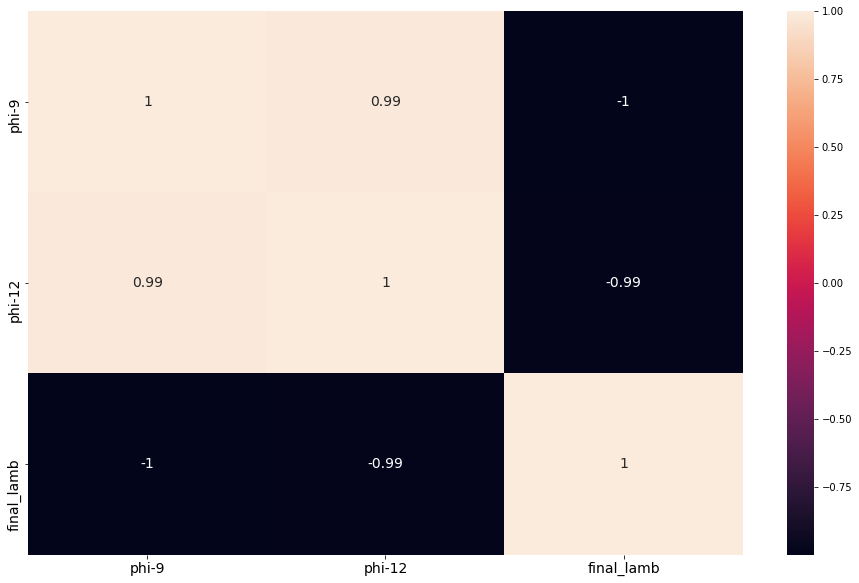

In [145]:
plt.figure(figsize=(16,10))
sb.heatmap(dataset.corr(), annot=True, annot_kws={"size":14})
# sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

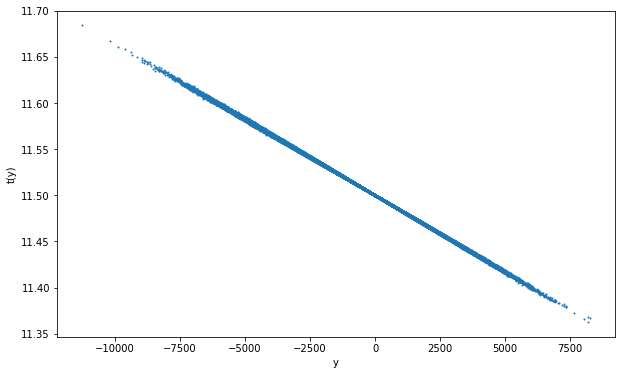

In [349]:
data = {'t': dataset['phi-9'],
        'y': dataset['final_lamb'],
       }

df = pd.DataFrame (data, columns = ['t','y'])

Xx = DataFrame(data,columns=['t'])
yy = DataFrame(data,columns=['y'])

plt.figure(figsize=(10,6))
plt.scatter(Xx,yy,s=1)
plt.xlabel('y')
plt.ylabel('t(y)')
plt.show()

In [426]:
dataset

,phi-11,final_lamb
0,-2443.972003,11.540648
1,-2724.049793,11.544954
2,-1617.376424,11.526618
3,-1298.044250,11.521457
4,-136.020073,11.502211
...,...,...
99995,-2978.837599,11.549099
99996,1135.601878,11.481141
99997,-5862.849770,11.595651
99998,1126.249336,11.481338


In [418]:
from sklearn import linear_model

In [419]:
modelo = linear_model.LinearRegression(normalize = False, fit_intercept = True)

In [421]:
# Define os valores de x e y
num_observ = len(dataset)
X = dataset['phi-11'].values.reshape((num_observ, 1)) # X deve sempre ser uma matriz e nunca um vetor
y = dataset['final_lamb'].values # y pode ser um vetor

In [422]:
# Aplica o modelo - fit()
modelo.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [423]:
# Imprime os coeficientes
print (modelo.coef_)
print (modelo.intercept_)

[-1.65184573e-05]
11.499942122303699


In [424]:
# Imprime as previsões
print (modelo.predict(X)[:1])

[11.54031277]


In [425]:
modelo.score(X, y)

0.9998536311689271

In [427]:
dataset

,phi-11,final_lamb
0,-2443.972003,11.540648
1,-2724.049793,11.544954
2,-1617.376424,11.526618
3,-1298.044250,11.521457
4,-136.020073,11.502211
...,...,...
99995,-2978.837599,11.549099
99996,1135.601878,11.481141
99997,-5862.849770,11.595651
99998,1126.249336,11.481338


In [431]:
for index, row in dataset.iterrows():
    print(row['phi-11'], row['final_lamb'])

-2443.972003 11.540648
-2724.049793 11.544954
-1617.376424 11.526618
-1298.04425 11.521457
-136.020073 11.502211
-875.838841 11.514508
-79.615252 11.501346
-3125.528113 11.551078
-3452.383669 11.556763
482.839165 11.492155
-671.649926 11.510986
3692.474783 11.439032
696.028116 11.488422
-45.217603 11.500743
-11.157885 11.500182
3484.39099 11.441792
-2544.205294 11.541136
1830.856922 11.469694
-4027.579161 11.565928
2293.084532 11.462302
681.807336 11.488787
538.137575 11.491009
-1148.630092 11.518472
-149.481114 11.50245
-157.632055 11.502593
-2244.94034 11.537754
-1654.004826 11.52786
-2591.291331 11.541976
928.681747 11.484542
-2144.055494 11.535625
-2987.70052 11.549143
-1019.800287 11.517363
1457.857794 11.476265
-2042.667835 11.533756
-972.58912 11.516305
-358.638381 11.505947
-1341.026305 11.522117
1808.830617 11.47077
229.961523 11.4962
-536.466914 11.508768
1101.242364 11.481528
-5527.55604 11.590856
-565.575381 11.509423
338.693497 11.494462
571.717792 11.490546
1203.254676 11

-2325.45111 11.538586
2076.431611 11.465131
-1953.297608 11.531779
1061.811234 11.482351
-449.675308 11.507443
781.394378 11.486805
979.0782 11.483822
-1883.165599 11.531355
2208.421844 11.464006
-1239.606077 11.52039
-1038.194555 11.517111
1721.179342 11.471614
177.734161 11.49702
-2518.005415 11.541953
-2725.149401 11.544793
29.095877 11.499523
-2317.46248 11.537581
-2122.613137 11.535213
4402.013103 11.428321
2637.44244 11.45614
-1407.221069 11.523503
1495.907192 11.475022
-2457.396627 11.540036
-461.678291 11.507536
1057.804136 11.48199
1011.925504 11.483114
-187.114284 11.50307
366.453975 11.493954
-2067.326875 11.533499
-2557.795969 11.541074
1802.189021 11.470256
-2384.480703 11.539316
-43.426946 11.500719
-1429.390523 11.523738
-1150.824269 11.519083
1256.6733 11.478915
5165.859444 11.414613
14.259486 11.499764
2617.79508 11.456688
2568.840433 11.456586
771.424112 11.487349
991.792178 11.483554
-399.254132 11.506616
-2243.386894 11.537374
4927.755072 11.41949
2187.836113 11.462

-306.215686 11.505076
28.690695 11.499534
703.374899 11.488456
-645.521373 11.510536
-1352.255923 11.522399
1362.664294 11.477428
-1904.184483 11.531814
-3320.131561 11.55576
-778.766346 11.513023
-3459.341113 11.557073
-1926.929813 11.531893
-1074.058436 11.517439
-471.717656 11.507798
102.134109 11.498303
-1661.337201 11.527649
-1874.152424 11.531395
1048.56225 11.482575
1440.104991 11.476174
-2971.112592 11.548463
-1877.446973 11.531106
-3545.230812 11.558821
-3452.491317 11.555666
-3963.05456 11.566469
1533.823531 11.474936
571.316695 11.490668
271.771867 11.495429
795.298328 11.48689
1174.982341 11.480723
-1899.160344 11.531125
-463.424002 11.507721
-329.657389 11.50535
938.469213 11.484405
-838.603315 11.514205
779.760218 11.487077
1158.908176 11.480872
-669.387841 11.511014
454.469479 11.492528
-1339.083995 11.522084
-3199.141023 11.552961
-5202.98273 11.585733
2019.987019 11.46649
-2757.611424 11.545312
1534.663511 11.474008
-600.890177 11.509989
-247.012802 11.504233
-2770.886

17.48669 11.49971
-1716.283172 11.528895
-3355.219122 11.554673
-3953.516574 11.564734
-2957.820963 11.54872
-3890.588196 11.563467
-1179.512451 11.519681
-1112.341439 11.518289
274.064812 11.495414
1132.611565 11.481439
463.47464 11.492268
-508.450554 11.508505
326.054592 11.494628
3730.224402 11.438683
1850.655386 11.469994
-423.726115 11.506955
634.786737 11.489273
-221.552833 11.503653
30.90215 11.499485
-2650.774394 11.54364
598.551917 11.489918
-3907.292987 11.564756
-22.032016 11.500368
-1520.808746 11.525287
-1810.40721 11.529744
-2842.048783 11.5465
-3183.804448 11.551649
-3280.706239 11.554656
1350.103542 11.478294
-1125.92271 11.518606
-4064.756207 11.565818
-3174.386286 11.552043
-4593.249578 11.576574
3208.388013 11.448007
-336.945518 11.50555
-3597.765805 11.558931
-2370.688664 11.538711
318.591078 11.494719
714.914275 11.488106
4179.089569 11.430164
-3367.419177 11.555984
1124.433356 11.481504
-3017.396121 11.550436
684.785928 11.488809
-2815.360202 11.546217
2172.575367

-2046.286859 11.533527
-1233.411069 11.520226
-1406.580415 11.523565
-2738.047435 11.546061
-576.972321 11.509497
4709.597401 11.422021
-2877.400986 11.548886
84.050167 11.498634
-3720.194188 11.561756
-634.002374 11.510422
1513.733512 11.474437
-2292.80532 11.53749
2261.11148 11.462587
1138.300429 11.481294
-1187.480896 11.51991
4028.345292 11.432555
-749.064761 11.512342
-4135.874164 11.56816
-2888.018084 11.547956
-2273.262911 11.537128
1489.671899 11.475721
-445.681386 11.50752
1034.977962 11.482351
-1937.905458 11.532249
-5455.945576 11.590002
2259.088185 11.462576
-1719.256732 11.528118
-957.748987 11.515687
2350.345334 11.461389
-710.152745 11.511654
278.302074 11.495352
-4194.646987 11.568694
2200.657311 11.463673
-423.608161 11.506883
854.872726 11.485967
1343.11966 11.477887
334.70701 11.494404
1058.537778 11.482508
-3970.380332 11.565431
-703.502495 11.511729
1644.090512 11.472913
-2796.901907 11.545489
-123.696538 11.50199
1507.71373 11.474754
3449.188825 11.443129
420.0419

150.618751 11.497541
-2641.450936 11.543249
-2790.604881 11.545807
601.643656 11.490254
-5624.703384 11.591645
1849.819816 11.46943
-1335.967194 11.522788
2163.727696 11.464052
-3151.13227 11.552
-3686.371014 11.559602
-2121.270133 11.535565
-1143.63393 11.519081
-2677.203854 11.543549
314.392534 11.494799
2340.435316 11.460344
-1979.195894 11.532322
843.064414 11.486147
-4034.091279 11.566384
769.824696 11.48746
-2340.648731 11.53857
871.693705 11.485645
-2640.104507 11.543403
2655.762032 11.456147
536.797536 11.491233
-231.576182 11.503862
-2474.195141 11.541117
-1517.707057 11.524818
82.853694 11.498631
-1821.05175 11.529974
141.022593 11.497665
2395.302793 11.4602
1294.375998 11.477931
-742.787973 11.512462
617.405472 11.48976
-2010.506411 11.533328
3268.677438 11.44533
-1277.86487 11.521116
1046.49431 11.482661
-3433.380364 11.555782
-1112.868315 11.518395
1541.856564 11.474692
725.132603 11.48789
-367.471791 11.506115
-3188.583059 11.552712
21.065038 11.49965
-2615.818627 11.5425

1818.073377 11.470022
2354.834821 11.461235
-267.069409 11.504436
-3272.604437 11.554466
-4174.929501 11.569464
-7685.485553 11.626206
-4775.359188 11.579024
85.992769 11.498576
2867.46131 11.452707
374.685285 11.493788
-2522.449104 11.541401
-13.810443 11.500232
2231.805983 11.463287
3177.892094 11.446823
-2942.261851 11.54903
709.730575 11.488482
-891.656173 11.514627
-1622.376699 11.527298
-1521.040201 11.525361
-876.490363 11.514623
-777.875449 11.512978
-5427.146809 11.588521
-5046.581684 11.583483
-67.144538 11.501115
-1045.446996 11.517309
2089.220819 11.466342
-1869.714891 11.53085
-3163.757174 11.551994
-884.110644 11.514943
1852.896874 11.469698
-3846.786706 11.56296
1754.332541 11.471267
120.486594 11.498003
-947.185342 11.515495
-119.119181 11.501953
-2668.106189 11.544477
1100.595535 11.481297
-2660.397241 11.542969
-2390.73836 11.53988
-1917.717177 11.531756
-394.528426 11.506544
403.369215 11.493283
556.323806 11.491001
235.214345 11.496115
182.275729 11.49694
1052.63073

2340.434197 11.461399
-802.608015 11.513381
393.779766 11.493451
-5029.235707 11.581425
-3076.363429 11.551077
-1769.459009 11.529147
-512.076555 11.508303
477.756162 11.492052
311.810274 11.494804
-984.258775 11.516052
-1454.440837 11.524131
-908.432875 11.515011
741.302521 11.487938
-5019.313699 11.581753
-1453.226129 11.523977
-4578.919942 11.575822
-774.407636 11.512747
-1207.912518 11.519903
-698.574599 11.5115
1200.847683 11.480288
-1210.321206 11.519881
-414.579153 11.506772
2343.657293 11.461331
-1095.878099 11.518269
907.650455 11.485069
-2510.177752 11.54133
71.322532 11.498789
-212.096302 11.50349
-5132.586617 11.584238
-1258.209728 11.520626
-2175.544198 11.535098
911.879837 11.485172
-576.126015 11.509382
-2221.591021 11.536405
-281.225133 11.504642
557.188835 11.4907
-1204.854979 11.519822
-1754.792282 11.528534
559.124651 11.490709
694.237674 11.488678
-1361.790406 11.522413
-1215.963361 11.520027
-941.231379 11.515673
-172.830116 11.502843
283.559643 11.495299
65.784708

5148.928872 11.412558
-687.843933 11.511316
-3707.58056 11.561117
-84.644273 11.50137
-463.742004 11.507644
-3004.510344 11.549637
-2812.346814 11.547022
-2717.853388 11.544654
1296.642928 11.478452
1539.413983 11.474471
-543.434784 11.509008
-725.326846 11.511939
-1391.005001 11.523004
-1304.337699 11.521038
-786.05597 11.512915
-1112.459951 11.518528
-2042.301984 11.533957
-661.562377 11.510859
-663.686139 11.511002
-1095.406545 11.518044
1585.747628 11.474052
-1787.338363 11.529222
-1652.460089 11.527322
-1063.599074 11.517757
1357.840022 11.477513
111.245484 11.498135
-3746.479894 11.561496
-3592.026685 11.55997
139.707266 11.497726
3482.829911 11.441805
-595.790147 11.509954
-277.035615 11.50463
744.101429 11.487641
822.96594 11.486188
-612.62722 11.510201
-2242.417158 11.537331
-999.378637 11.516561
227.146875 11.496236
-2120.06063 11.535248
-3015.653867 11.54981
-382.544009 11.506252
-2455.686624 11.540572
-1999.027525 11.53273
-3441.132508 11.557361
-355.579387 11.505957
-2007.

-1471.373203 11.524344
-1191.517973 11.519755
-3757.545021 11.560693
-2412.229749 11.539765
-1931.490387 11.53176
413.445391 11.493112
2000.846125 11.465907
-778.248098 11.512754
414.837304 11.493097
-319.519444 11.50526
-3621.990632 11.559351
594.52084 11.49013
-4829.580896 11.578539
-2398.135376 11.539143
2924.42651 11.451494
-1933.34887 11.532242
-383.516006 11.506547
3786.808414 11.437211
-2293.939288 11.538254
-3499.506992 11.55788
-273.360117 11.504458
-2296.001677 11.537708
-390.66815 11.50643
-821.345464 11.513663
306.264309 11.49488
2464.269346 11.458632
-2584.690798 11.543502
-3518.850408 11.557619
-3962.938848 11.565102
-40.697182 11.500691
-5166.469845 11.58527
-50.225519 11.500837
-2764.339643 11.545955
-1901.794155 11.531287
1637.256692 11.472542
380.494902 11.493685
-1316.952002 11.521674
-1725.748837 11.528529
-3300.814984 11.554455
-3057.668223 11.551301
-4642.242627 11.577639
-2394.780902 11.53894
-106.372674 11.501792
853.499504 11.485794
-901.657066 11.514943
274.37

1302.762886 11.478439
-337.476172 11.505679
-2709.057112 11.544877
-4040.42323 11.566465
-548.255414 11.509076
-3075.523853 11.550763
1144.81379 11.481003
-3640.128618 11.559415
-4106.275331 11.568724
-4043.687251 11.566047
-1730.548061 11.529151
391.198519 11.493637
-1299.130276 11.521519
-963.087159 11.515899
-4640.295245 11.575791
-3317.632242 11.553825
1833.50851 11.469899
375.237911 11.493786
1899.627496 11.468782
525.619734 11.491351
-1295.655451 11.521284
2230.799429 11.462484
-758.747732 11.512979
1250.112358 11.479096
-740.27506 11.512451
-216.933968 11.503617
-735.520022 11.512242
-259.103297 11.50429
-3370.998166 11.555678
-3245.90459 11.553563
-791.288196 11.512943
146.613295 11.497582
1032.612012 11.482794
-1254.661766 11.520286
-3688.757106 11.561316
-2669.824856 11.5441
-4175.604494 11.568877
-8137.342455 11.632264
-2666.831314 11.544318
-250.241809 11.504195
-2918.098152 11.548031
-2177.876482 11.53668
-1556.614234 11.52557
2718.397221 11.454884
-771.664494 11.51263
-37

-2752.84298 11.54602
-3546.643096 11.559004
2222.000547 11.462888
-510.347367 11.508423
3038.466353 11.449492
-818.514774 11.513405
-3321.599136 11.555097
-1148.074156 11.518869
2592.285323 11.456698
2087.464959 11.465347
-1399.94659 11.523142
-569.371741 11.509491
2842.73672 11.453365
-722.17257 11.512081
-3264.882864 11.554444
349.108096 11.494208
555.809567 11.490682
392.760658 11.493508
-6486.089477 11.605293
-1157.326116 11.519472
-1521.340814 11.525027
1278.400595 11.478847
-48.91194 11.500816
1200.981931 11.479803
-2324.363361 11.538154
2221.861612 11.464025
1381.521654 11.476881
-2782.201788 11.544984
2311.296442 11.461562
429.413846 11.492991
-6452.433692 11.607317
1284.967499 11.478802
-2143.625471 11.535941
-5231.417019 11.586027
2221.799242 11.46312
-1837.765927 11.530006
-2976.725593 11.548047
760.73752 11.487145
-1112.210142 11.518573
-1375.331912 11.52273
-5403.204019 11.588392
255.242391 11.495725
2694.588929 11.454592
219.593338 11.496444
-1291.966331 11.521742
-1404.9

-2159.468714 11.53628
-2054.048754 11.534126
-10.279027 11.500168
1269.733415 11.478919
-265.918379 11.504327
2178.233803 11.464385
847.64476 11.486137
-1658.528674 11.52774
1598.46235 11.473784
979.089273 11.483571
-1613.11592 11.527067
-4953.214599 11.58135
-923.909718 11.515297
1001.440285 11.483308
4041.165467 11.433321
3733.319174 11.438412
4490.41693 11.42568
283.724889 11.495341
3179.199457 11.447297
-1477.495542 11.523892
-632.871906 11.510631
-250.657226 11.504175
411.540306 11.493189
-2153.596151 11.535676
-269.463868 11.504469
-2514.432945 11.542429
-2665.056397 11.542697
-53.447063 11.500875
-1929.210277 11.531837
1091.654907 11.481556
1186.034524 11.480607
-1055.70849 11.517652
-398.911204 11.50663
763.700162 11.486989
-1707.795051 11.527968
-371.531855 11.506177
-1063.828788 11.517343
-1487.840462 11.524735
-348.931892 11.505748
-610.147606 11.510114
1568.804537 11.473838
1734.10513 11.471579
-1689.217119 11.528063
-1567.197373 11.525682
-1749.994414 11.529231
4180.027512

-282.596884 11.504709
2863.949998 11.452912
-2783.364383 11.54593
-387.359326 11.506516
829.017844 11.486133
-1788.26242 11.529825
-4665.386837 11.575559
4120.623282 11.431099
-3470.334142 11.55789
345.8267 11.494214
-1264.387657 11.520634
-1058.644827 11.517329
-3165.278813 11.552376
-924.72185 11.515386
362.910799 11.493924
-1714.647412 11.528752
-1844.044748 11.530619
-48.501633 11.500792
316.334566 11.494756
-25.323368 11.500423
-622.045461 11.510464
-272.63822 11.504467
-1304.731567 11.521514
-1808.757703 11.530031
-3039.261282 11.550076
-2870.412154 11.547324
994.677334 11.483403
-65.76174 11.501105
-2300.494578 11.53756
-561.389489 11.509408
785.55504 11.486863
1151.755824 11.480913
-3712.671578 11.561758
-3663.22063 11.560081
-2119.457487 11.535131
-389.606606 11.506451
-5439.971245 11.590835
1263.599307 11.479232
-2893.310811 11.547803
-4306.279866 11.571228
4661.750585 11.42239
-2525.547879 11.541934
1830.286679 11.46916
-932.077229 11.51542
-1283.532736 11.521133
-3047.35610

-458.307385 11.507713
-3255.480193 11.553664
1835.920682 11.469434
2124.430351 11.465777
342.989288 11.494268
1300.117301 11.478447
-2702.5992 11.543888
-456.148061 11.507616
924.335125 11.48435
639.802319 11.489408
-259.996291 11.504379
-1385.586178 11.523405
-2135.851691 11.535793
-39.454398 11.500652
188.794402 11.496826
249.184834 11.495847
-6.865792 11.500117
-344.931625 11.505704
1058.477935 11.482274
-492.83027 11.50799
-2597.150041 11.542598
-768.071132 11.512836
83.816401 11.498605
-3569.77774 11.558693
1260.732601 11.479241
-7027.661645 11.616183
-28.453633 11.500477
-5948.613421 11.598833
-5816.584482 11.59505
-2516.625984 11.541525
21.776497 11.499635
-126.563162 11.502103
-4820.484485 11.57961
-4357.87696 11.57187
-3429.044665 11.555661
-556.86369 11.509287
-3400.373605 11.557479
1832.912741 11.469943
-1736.015835 11.528456
-223.795945 11.50372
1275.618283 11.478713
-1051.718407 11.517473
-1892.895165 11.531294
-1697.78818 11.528052
975.234927 11.483667
1688.059565 11.4719

-711.396282 11.511764
-407.53099 11.506923
1412.929716 11.476219
-5246.565455 11.586604
-366.35379 11.506044
-4245.722973 11.568166
693.908396 11.488306
-2008.435894 11.533039
-1223.055385 11.520282
638.018244 11.489548
-314.358013 11.505195
-2365.675597 11.539237
157.518579 11.497429
471.014356 11.492243
-467.603659 11.507842
-313.306416 11.505275
403.353173 11.493326
-2226.721889 11.537346
3457.445715 11.442525
-929.7097 11.515056
-71.981329 11.501193
-6381.219916 11.604101
-2010.513524 11.532974
-3951.553634 11.564404
78.420423 11.498708
-214.884414 11.503483
-1342.636826 11.52205
1887.36162 11.468242
-2964.900304 11.549742
34.075369 11.499426
-3759.539127 11.562879
2872.981298 11.453311
-1193.743608 11.519321
1942.450161 11.467679
-1683.130233 11.527697
-2671.932803 11.544111
-2490.419538 11.540867
2394.061846 11.460352
3497.309385 11.441844
-1599.192566 11.526276
637.758984 11.489377
-1067.967267 11.517554
-1671.835502 11.528061
-3979.829865 11.565499
1052.72821 11.482483
4317.746

1903.451202 11.469252
1507.306107 11.474634
831.498874 11.486176
265.413625 11.49561
866.839753 11.485627
1796.849479 11.470002
-1683.780055 11.527588
640.208948 11.489122
-3195.241658 11.552136
1660.098222 11.472438
-2629.745963 11.543446
-3593.358127 11.559451
-699.628646 11.511653
-2482.597863 11.541183
1582.832111 11.473417
1161.32319 11.481023
-1507.865357 11.524767
-4766.059463 11.57863
926.133517 11.484796
-1226.531027 11.520179
-598.44188 11.509851
655.075517 11.489188
-1490.747472 11.524503
676.237007 11.488788
572.206024 11.490545
454.735794 11.492489
-1736.701252 11.528673
-2666.939358 11.543661
-3168.775584 11.551615
1087.388434 11.481703
-1076.243511 11.518061
-184.730148 11.503048
-126.380663 11.502116
1086.376216 11.482047
2487.315981 11.457865
-3574.961813 11.558906
-831.034349 11.513961
653.333524 11.489284
432.398915 11.492933
-1907.808904 11.531091
-3084.515526 11.551173
-855.354231 11.514154
-1375.903656 11.522591
1646.417084 11.472759
2623.816886 11.457339
-2202.59

-6782.401933 11.612147
-4289.304848 11.571313
-2697.445131 11.544639
2738.200127 11.454912
3129.898023 11.448606
-3557.405813 11.558582
-1003.907287 11.516886
-361.667098 11.506025
-1728.558032 11.527851
1327.314519 11.477835
145.24032 11.497587
-1555.962735 11.52539
-5797.794369 11.594422
-1625.016591 11.526718
-5734.420572 11.59255
498.50214 11.491735
-551.493441 11.509069
-1208.069614 11.520029
3052.030941 11.44952
-116.120538 11.501931
138.013972 11.497717
1283.327428 11.478323
-3657.971448 11.560024
-2245.756356 11.537111
-694.970911 11.51138
-3008.471916 11.550124
5447.774456 11.408824
1054.149829 11.482353
-939.524827 11.515616
2457.788883 11.459421
-3291.430338 11.553195
-70.194275 11.50116
8.074392 11.499866
-428.2487 11.507115
-1843.288109 11.530525
3529.899321 11.441745
1995.3386 11.466183
-1272.506952 11.520637
-899.124517 11.514866
-1323.110833 11.521717
-39.23303 11.500671
-846.739035 11.513879
-772.884811 11.512702
-2947.283093 11.54917
-62.835957 11.501035
-1449.262733 

-3942.125235 11.566293
554.902014 11.490742
-219.005656 11.503622
175.266913 11.497101
-638.679208 11.510723
588.138403 11.49033
-2854.988874 11.546986
2391.048461 11.460662
-860.180664 11.514376
-927.482589 11.515262
-3892.094924 11.564293
-2824.750344 11.547344
-206.360476 11.503408
-2472.294856 11.540777
926.476078 11.484671
-2954.292487 11.549686
-1458.621832 11.523997
228.566938 11.496244
-2288.890657 11.537969
-100.290238 11.501651
-6019.843508 11.597785
-241.65537 11.503964
-2189.246494 11.537128
-4142.109564 11.568716
-3470.920979 11.55706
4139.282105 11.432391
-3756.971572 11.560779
-2473.908853 11.540656
-1823.448051 11.530332
739.060246 11.487914
-2473.647713 11.541302
703.49479 11.488356
-4276.305661 11.572982
-3983.467538 11.565812
-2428.998259 11.539779
-1275.428308 11.521215
-2545.938125 11.542906
152.024514 11.497435
-2430.508555 11.539245
-652.218842 11.510734
-1095.037513 11.518419
-2855.98357 11.546888
1645.495752 11.472914
-434.643207 11.507086
1837.227359 11.469456

-392.360823 11.506353
-451.661573 11.507417
-2674.683822 11.544459
767.070801 11.487403
-1119.293061 11.518537
-1929.465864 11.53194
-689.802087 11.511425
-753.023663 11.512345
-1523.989379 11.525211
-2080.157578 11.535011
-2491.175962 11.540905
-4324.202759 11.572035
451.388315 11.492441
-750.339253 11.512337
-23.867961 11.500388
-1349.771755 11.52213
-1385.319283 11.522861
-2644.21475 11.543258
-1048.458672 11.517436
4943.132104 11.418662
-1006.195548 11.516577
1487.25942 11.475098
-2676.763759 11.544157
18.711518 11.499693
-2419.888825 11.539753
1311.047764 11.478408
-2569.545393 11.541674
-380.721991 11.506213
-745.10877 11.512125
2794.321475 11.453831
2238.150381 11.463479
1548.316543 11.474342
-1932.754706 11.531727
530.73529 11.491265
-261.631474 11.504314
-3672.287439 11.559665
481.583889 11.491923
700.9276 11.488475
-3164.682286 11.552005
1.296738 11.499979
-1918.220384 11.531627
-1370.732449 11.522689
2255.442157 11.462115
-842.429922 11.514174
48.478522 11.499196
-638.472629

1580.34077 11.474104
2207.156037 11.463165
-1630.541248 11.526938
514.336904 11.491415
-864.71474 11.514022
-1657.237017 11.527408
-1413.281953 11.523503
-1152.835913 11.519205
-3755.583501 11.561896
-253.43838 11.504108
-1791.480497 11.529166
-990.31836 11.51601
1681.927784 11.471651
-241.64741 11.503938
3322.644064 11.44542
2135.960284 11.464435
-1230.551031 11.520244
-599.041675 11.510018
802.970045 11.486635
-1483.222902 11.524323
-1390.360699 11.522593
634.918752 11.489659
675.919308 11.489087
424.664406 11.493078
564.918987 11.490655
-3528.151895 11.557958
-579.343622 11.509435
-2944.8502 11.547896
2554.819279 11.457836
-2992.424742 11.548567
-2297.107674 11.537273
-2793.623888 11.545339
1913.206594 11.467967
2943.356136 11.4507
-713.271694 11.512013
3539.111602 11.442004
1025.16274 11.48331
-3164.647503 11.552124
-1609.98186 11.526234
171.206996 11.49715
-1613.904435 11.526593
-4095.326597 11.567098
-3453.236652 11.556914
1300.18636 11.478435
-426.412376 11.506874
-2395.922533 1

691.122203 11.488677
-901.445443 11.514683
-4425.197797 11.572415
-1202.848346 11.519518
-2681.285438 11.544382
-735.110399 11.512079
-3293.821995 11.552882
-1913.082582 11.531823
545.990041 11.491038
4126.141287 11.431888
-577.911333 11.509364
-3311.026687 11.554655
-1184.349473 11.519514
-2359.770319 11.538765
-1836.688 11.530076
3855.483488 11.436953
-2939.158427 11.548787
960.588534 11.484011
342.183457 11.494333
742.079595 11.487823
-1294.706202 11.520809
-4482.902889 11.573739
-266.720877 11.504545
480.415911 11.492124
-482.642536 11.508041
2179.788412 11.46342
-204.7237 11.503347
-3586.348103 11.559624
-3694.15809 11.561879
1024.248106 11.48288
-516.773506 11.508477
-2763.460378 11.546224
-156.041422 11.502561
-1942.296244 11.531818
-2718.479659 11.544889
-981.669006 11.516279
-5340.022148 11.586365
-2180.649169 11.53611
941.435345 11.484685
396.158227 11.493442
-932.348245 11.515327
309.434186 11.494806
354.528079 11.494216
1284.975715 11.47874
-3273.008832 11.553764
98.153794 

-2136.520239 11.535463
712.45797 11.487898
-1463.061262 11.524081
-1864.23865 11.531346
-1261.871458 11.520915
-5204.634674 11.584786
4400.201615 11.425454
386.541235 11.49363
-1678.781505 11.527352
-2199.723919 11.535907
-624.925262 11.510306
1151.466228 11.480817
-2120.93267 11.5354
686.312306 11.488596
617.248903 11.489954
518.804843 11.491371
-1516.009695 11.525135
-430.171226 11.507146
-1108.632884 11.518217
-3791.414751 11.561963
-5795.111898 11.594624
-3614.111126 11.56035
-950.160363 11.515619
656.304533 11.488916
-733.045281 11.511962
-134.657282 11.502201
-2634.736038 11.542735
-3785.883729 11.562074
4612.380819 11.424114
153.696075 11.497379
2373.685949 11.461018
1005.261233 11.483356
613.877207 11.489748
-348.754471 11.505713
-7210.371505 11.619191
-1454.196684 11.524039
847.435651 11.48583
3162.903878 11.447352
677.389206 11.48863
1612.514034 11.473027
-2459.938075 11.540409
-2659.728077 11.544066
-5637.322395 11.591731
-329.99415 11.505544
82.151125 11.498647
-1501.22965 

2268.500848 11.46284
-1035.22763 11.517388
-404.818235 11.506725
3907.531354 11.435816
-1557.673862 11.525281
-247.374036 11.504023
144.477181 11.497581
-587.386264 11.509889
-2313.427697 11.538262
-2857.670184 11.546605
2076.753522 11.465685
2322.613503 11.462425
2179.368823 11.463872
-279.065189 11.504619
90.253273 11.498514
-492.184495 11.50807
413.240354 11.493173
-3578.520458 11.558862
-789.075287 11.513083
382.838635 11.493789
-1766.685766 11.52974
-2755.591192 11.545667
737.930035 11.48796
3293.107499 11.445153
207.637837 11.496565
148.471454 11.497574
-572.307669 11.509443
-261.742007 11.504268
-1543.960473 11.52546
-833.493756 11.513732
-4702.969017 11.579193
1633.757563 11.472721
-1455.749377 11.524392
-5080.209069 11.58331
-1260.410543 11.521127
-718.25369 11.511963
-3871.657222 11.564222
-2237.71484 11.537655
-1122.885998 11.518843
830.160572 11.486172
-837.168747 11.513922
-2459.79968 11.541024
-1711.2908 11.528762
-1180.876902 11.520088
-596.660441 11.509991
-2874.011714 

-4481.038443 11.575802
-844.725973 11.513849
-831.45751 11.51352
2462.661962 11.459716
286.643026 11.495288
1524.727899 11.474778
-1354.123374 11.522353
1657.465946 11.472479
5136.570831 11.413391
352.448083 11.494192
-99.313892 11.501692
-1641.577341 11.527603
-2894.856993 11.54692
-1360.258775 11.522564
-3791.88555 11.561527
-565.948107 11.509345
-131.981455 11.502209
1468.604493 11.47569
-2269.339002 11.537299
398.343423 11.493432
-552.384864 11.509346
-1663.855518 11.527417
-2988.139328 11.549304
-504.150618 11.508436
-2690.681911 11.544004
-444.594079 11.507219
-126.738051 11.502106
409.575736 11.493195
3269.833467 11.44678
-266.190708 11.504412
-1423.164466 11.523173
-612.320536 11.510061
-3707.062046 11.560767
-2314.639115 11.538077
-1829.651202 11.529735
-194.355343 11.503278
432.002121 11.492781
-1423.383858 11.523741
4790.468953 11.419587
-1789.431066 11.529283
-2480.569978 11.540993
-308.374734 11.505128
264.798902 11.495595
952.550302 11.484355
-2394.665692 11.539013
-2893.

-142.326219 11.502382
3389.78726 11.443058
-4309.592407 11.569941
-2687.15324 11.544108
-1132.849012 11.518502
-5327.243787 11.588677
-294.255036 11.504878
1192.738105 11.480105
2493.862136 11.458066
-2328.556271 11.537571
-110.691641 11.501819
-5092.788059 11.583628
1258.019663 11.478652
-3400.862167 11.556531
1588.328324 11.473049
431.712984 11.492734
-5768.381053 11.594182
633.305897 11.489653
-4677.967015 11.577931
1934.506518 11.467522
-2003.095998 11.533638
1731.766666 11.471686
-1190.497169 11.519488
-4237.958124 11.569555
-2802.330293 11.546226
-4257.116719 11.57096
-427.084905 11.506998
1484.597481 11.474843
415.680534 11.493046
-1901.540246 11.531475
-2925.080449 11.547685
-497.01637 11.508344
395.449994 11.493461
1939.092595 11.467424
-1290.542249 11.521582
-2583.426324 11.542749
1786.899362 11.470573
-68.473847 11.501135
-2623.484169 11.543215
-316.409058 11.505154
2263.767999 11.462997
-1142.378938 11.518889
-4292.380497 11.570735
-97.028495 11.501611
-1857.938588 11.53066

1261.586721 11.479068
-1204.601499 11.519702
713.201956 11.488431
21.994834 11.49964
30.725599 11.499494
2226.574677 11.462869
4979.834874 11.41537
649.149661 11.489451
-2241.777132 11.536574
2767.973738 11.454463
-1175.149522 11.519621
-4126.132405 11.56859
149.405744 11.49748
-2106.599266 11.535241
-486.600964 11.508088
-884.439569 11.514916
1175.635495 11.48062
1091.694775 11.482134
822.374201 11.48654
-509.98661 11.508401
-2406.523215 11.540515
-1286.207519 11.521406
-1221.341609 11.520463
1742.145855 11.47121
-2967.645781 11.549213
-1160.894841 11.519304
-61.641946 11.501014
1453.063445 11.47647
-3854.993608 11.56379
-2278.928449 11.537101
-1498.425432 11.524758
-1837.941551 11.530064
-902.482406 11.514847
-4041.133674 11.567589
-1893.019488 11.531088
-907.563718 11.514805
692.385934 11.488799
-2410.693658 11.54009
-1663.931824 11.527295
-1169.340737 11.519537
-929.403516 11.515366
2618.302283 11.456646
-1086.328741 11.517678
-778.073783 11.512892
-568.764635 11.509313
-317.766525

-1443.734353 11.523741
344.987099 11.494334
659.803492 11.489099
169.950865 11.497238
-111.066254 11.50182
1939.147194 11.468172
1035.741104 11.483033
425.858074 11.492857
-2719.673164 11.544519
-630.643158 11.510199
810.648326 11.486643
-1292.891958 11.521364
-4595.794131 11.575777
1570.132566 11.473681
-1192.107885 11.520131
-3626.125674 11.56019
58.163099 11.499024
4870.344376 11.42047
609.880657 11.489961
-344.127717 11.505747
1369.214141 11.477477
-987.653842 11.516147
-2331.542721 11.538628
-2211.025841 11.536799
-320.091865 11.505329
-4794.586518 11.578541
-593.245961 11.509958
-1196.696637 11.520001
-5127.701048 11.583776
2822.735132 11.452202
-654.097477 11.510827
458.907541 11.492462
655.924978 11.489357
-925.589499 11.515357
-62.754839 11.501035
1714.144801 11.471668
3532.973248 11.440079
-59.363953 11.500972
-807.19806 11.513497
-1082.419231 11.517535
-1456.78998 11.524336
-2514.520772 11.541522
3767.059184 11.437198
-2112.820787 11.535114
-2301.738553 11.538314
-4005.33220

-493.382536 11.508258
2561.19292 11.457087
-3439.856173 11.55694
-1322.181895 11.521866
-324.801916 11.505342
-2325.552125 11.538223
-496.200165 11.508242
-1949.200817 11.531986
-21.775932 11.500359
-2426.673182 11.540252
-4352.761867 11.570996
-1105.545456 11.518203
2300.944325 11.46118
-1247.564486 11.520679
2859.530272 11.452665
1247.505189 11.478972
-582.149565 11.509755
-173.114827 11.502856
-3014.856009 11.549604
-2274.0764 11.537453
-331.440662 11.505348
-451.843133 11.507433
3677.419984 11.438702
-1789.204203 11.529217
2330.138312 11.461863
-1241.94286 11.52048
-980.947088 11.515923
-2550.802851 11.541349
-1246.579663 11.520621
622.43948 11.489413
-781.492146 11.512692
2028.919412 11.466413
-4261.774728 11.569823
-3051.143396 11.550547
-165.76938 11.502735
4338.068438 11.428763
-1629.478715 11.527063
-2404.147557 11.539247
2709.320023 11.45471
741.262992 11.48755
-340.246766 11.505598
529.013075 11.491157
-975.138866 11.516201
1925.131063 11.468185
-938.614375 11.515495
-309.78

-4805.246788 11.578854
685.079949 11.488525
-2596.626793 11.542678
-5647.136613 11.592919
351.566494 11.494148
276.897245 11.495402
-2686.43002 11.543646
-3016.497497 11.550193
-2914.875501 11.54787
-2664.329627 11.543394
1114.735067 11.481556
950.896768 11.484434
-1738.639486 11.528587
-1330.065821 11.52183
935.74925 11.484326
-1167.958323 11.519459
638.00436 11.489602
-3676.807727 11.560354
-153.545735 11.502502
703.02924 11.48835
1386.178152 11.47664
-533.845552 11.508782
-558.751296 11.509331
-610.856511 11.510144
50.842834 11.499133
-1671.365896 11.527475
-5408.849277 11.587656
-402.740454 11.506756
2622.245324 11.456967
1861.588247 11.469049
1673.551061 11.472094
2058.22567 11.465904
-4629.55851 11.575462
-282.966543 11.50464
-195.875235 11.503198
1931.670353 11.467785
1834.020699 11.469318
-2353.13498 11.538862
20.615271 11.49966
1245.616041 11.479358
-5569.901126 11.590979
1248.549243 11.479822
-1005.035163 11.516611
-577.112726 11.509533
4.413599 11.499927
-507.498216 11.50825

-1896.065623 11.531378
-3512.48371 11.557175
1166.345593 11.48007
-3180.498776 11.551822
1157.239984 11.480955
987.013628 11.483862
-1516.287893 11.525252
-5276.903034 11.586994
1496.895906 11.475035
-2101.650452 11.535714
-625.429985 11.510406
-3162.853727 11.552231
3568.177152 11.43982
-2943.006861 11.548158
-5474.87456 11.59115
-666.287375 11.510983
-2178.904406 11.535941
973.868453 11.483748
-5041.736455 11.581654
3327.319883 11.444116
-2900.0904 11.547404
-381.648376 11.506336
-5084.750241 11.58303
-1286.745567 11.521454
-18.54389 11.500306
-309.71692 11.505117
6030.045598 11.401297
-1676.341799 11.527402
-2359.557389 11.538634
-2722.765777 11.544596
1081.419179 11.48158
4144.616111 11.430939
971.272893 11.48376
-931.871615 11.515328
-6853.721118 11.611278
-1896.990359 11.531326
-3982.45002 11.565897
1394.280035 11.477082
-244.833624 11.504066
-993.594188 11.516315
2902.589762 11.452334
-2175.899779 11.536333
4529.358844 11.424904
-1359.246456 11.522721
-1770.117199 11.52928
-4095

-1594.878505 11.526607
-1157.151872 11.519069
-824.676503 11.513698
377.320296 11.493832
2465.012949 11.459755
1907.99389 11.468483
-497.469243 11.50816
2229.069726 11.463408
-6091.063625 11.601673
1615.76524 11.473176
-634.785478 11.510586
-3878.332116 11.564134
2490.306171 11.459201
-2147.83288 11.535313
-3205.92831 11.552723
-1388.647472 11.523298
-7883.119165 11.630246
-554.134202 11.50904
716.842208 11.487788
-1791.328619 11.529419
1472.489491 11.475808
985.94061 11.483885
-193.135331 11.50314
-3550.661745 11.558811
138.343753 11.497684
-11.321044 11.500188
-1831.18995 11.530398
2782.259849 11.453811
-3525.535111 11.558972
840.276126 11.485951
-1003.751232 11.51641
-1083.686383 11.517662
193.502283 11.496752
-1778.451271 11.529895
-719.432555 11.511718
1200.057992 11.480111
-2005.284061 11.533968
-3019.656697 11.550562
363.275887 11.494124
-1124.409945 11.51866
-1181.893671 11.519884
2674.430766 11.454377
-1681.244999 11.527172
-2576.87999 11.542979
-839.567072 11.513714
-2024.102

254.434041 11.495756
1755.90352 11.471168
-723.071594 11.511834
-1198.444557 11.519916
2658.032625 11.456295
1109.858874 11.481679
-2084.249716 11.534394
2903.568201 11.451215
-2271.579994 11.537241
230.997216 11.496203
97.203624 11.498382
133.700004 11.497839
-349.581378 11.505799
-60.650557 11.501008
-638.536312 11.51049
92.596373 11.498461
-5456.785371 11.589241
-517.528537 11.508574
-2693.631905 11.544192
-1969.910793 11.533192
1696.966483 11.471755
-3528.70262 11.559026
-2537.480824 11.541623
-745.925171 11.512209
-2247.391075 11.537721
-2585.644259 11.542196
-2.805021 11.500047
-1443.95789 11.523889
907.002792 11.484933
-1082.159206 11.517937
-2.108694 11.500035
783.622254 11.486882
1378.666651 11.477132
-1388.000156 11.522951
-2901.065811 11.547183
596.370702 11.490137
-89.293147 11.501466
3741.262435 11.43778
-2777.040533 11.544894
-1875.475782 11.531399
1859.094507 11.469553
-6420.057711 11.606128
-309.919122 11.505082
-2525.284104 11.541723
-781.810247 11.512897
-5559.213696 

-3957.094121 11.564333
-2840.951914 11.546736
393.580025 11.493552
-4003.053255 11.566681
-174.331065 11.502882
1215.088138 11.479936
977.34508 11.484182
-2922.754928 11.548035
-499.582016 11.508408
1464.67107 11.475757
-1172.544619 11.519398
-1510.098878 11.524485
885.473473 11.485439
-2614.362184 11.543736
1408.88524 11.476817
44.459013 11.499269
-247.222954 11.504071
157.580552 11.497449
2077.992215 11.465441
-1661.575122 11.527321
655.201677 11.489374
-576.920642 11.509587
3663.423091 11.438876
-3362.02055 11.554387
-3125.876712 11.552001
3829.482697 11.436607
-2896.964075 11.547563
-374.946059 11.506201
4295.549846 11.428827
2365.659552 11.460903
-720.600693 11.512021
-4616.711284 11.574974
-942.823618 11.515708
-1260.151044 11.520538
67.788972 11.498892
-2584.45241 11.542625
-1870.281947 11.531173
5105.344143 11.416534
-2356.013446 11.53807
-1127.912479 11.518787
-437.08181 11.507115
1761.336971 11.471237
2013.164969 11.467057
3228.75688 11.446926
3010.757003 11.449681
-1618.5920

-2220.276556 11.53753
3282.901703 11.445716
-3111.506756 11.550437
3608.066178 11.439878
-3744.907161 11.561512
-7566.595876 11.623641
-1035.585222 11.517193
-2788.345601 11.546989
-445.061873 11.507369
975.572629 11.483999
3854.461067 11.436199
-1212.962086 11.519804
279.795662 11.495333
1159.884478 11.480344
181.165078 11.496964
1920.79072 11.468016
-1496.618482 11.524423
-1340.667199 11.522193
1788.491388 11.470831
-1260.068694 11.521095
-538.689055 11.508899
-956.606641 11.515635
-706.62552 11.511734
1064.344209 11.482143
1480.859749 11.475121
-1270.005124 11.521206
1807.948871 11.469693
-4466.532922 11.573287
-1161.936378 11.519262
-1534.789137 11.5255
-887.064279 11.514901
656.913889 11.48925
1018.663276 11.483069
1415.049401 11.476606
-2982.966153 11.549055
-45.968105 11.500752
-2731.98333 11.544461
-2609.250699 11.542931
21.270265 11.499651
-4028.96942 11.565909
774.385903 11.487385
-382.50799 11.506259
1770.74376 11.47071
1038.336645 11.48292
-6012.701595 11.59917
-577.402574 

1064.783161 11.482581
2930.698943 11.450963
-1658.913053 11.527174
-1827.459468 11.53028
-2380.321752 11.540034
152.896538 11.497436
-2160.231319 11.534709
1481.834074 11.475561
-130.493959 11.502152
-1540.021212 11.52544
-1464.96678 11.524259
-1815.354666 11.529943
3887.857312 11.436034
-749.380274 11.512339
270.299582 11.495532
-685.284915 11.511323
1513.78237 11.475078
1196.752205 11.479942
-2896.487831 11.54843
-584.006884 11.509652
88.119261 11.498538
-4527.715515 11.575204
-1516.12344 11.525875
-3784.100864 11.561774
-2776.025288 11.546994
-768.208547 11.512729
-2984.336937 11.549128
3354.123607 11.444165
-1512.835398 11.524638
-214.708434 11.503606
-683.761292 11.511341
-1566.395317 11.526081
-1976.484729 11.532154
-2157.107431 11.535704
-1257.238383 11.520987
262.596597 11.495729
-170.134367 11.502853
611.685791 11.489831
132.720759 11.497773
1918.558396 11.468541
1052.022028 11.482053
-546.090206 11.509039
-3521.429342 11.558176
-1852.142021 11.530533
-790.430759 11.513011
212

731.568209 11.487775
-165.75804 11.50276
-3182.06907 11.552834
-1988.991485 11.532163
-701.815548 11.511904
-198.315396 11.503246
-1859.984033 11.53038
1763.11003 11.470585
3530.610709 11.44185
431.210135 11.49281
3603.558955 11.440198
-2439.502387 11.539963
-2886.086889 11.547191
-75.133317 11.501238
911.559795 11.485008
-5608.0767 11.592174
2101.535093 11.465355
-6047.146234 11.601177
1245.384429 11.479406
3768.095957 11.437253
-4191.223771 11.566749
-1672.27746 11.528027
257.657956 11.495771
-1610.784257 11.526793
2106.467508 11.465056
3360.231344 11.444153
-1791.015355 11.529709
-3127.262696 11.552443
3344.40096 11.44428
-2331.957828 11.538782
-1041.609397 11.517096
-1050.481698 11.517366
5949.43097 11.400634
1265.033063 11.478856
-985.328482 11.516269
4557.735816 11.424473
-758.745495 11.512604
-2753.503714 11.54692
-3590.951587 11.559826
-798.109497 11.513293
-1236.256158 11.520264
-1403.730204 11.523465
40.617928 11.499336
9.714905 11.499838
-560.913799 11.509163
794.588751 11.4

-1158.237948 11.519144
-2311.433892 11.538662
1439.030483 11.475668
1430.415703 11.47631
-1658.576348 11.527189
-5862.797871 11.595744
-4082.047918 11.567924
-1796.404827 11.529945
-41.652207 11.500681
-3908.713016 11.564685
-1735.415205 11.529008
647.905625 11.489202
-4908.800705 11.580467
53.871662 11.499096
-1254.999137 11.520449
-2894.699923 11.547678
202.833639 11.496633
3304.521466 11.445446
-463.252351 11.507683
829.234249 11.486208
-389.716806 11.506405
-3503.679663 11.556898
-1767.134029 11.52903
-1112.49448 11.518423
2383.027535 11.460451
-504.012282 11.508136
-1958.900676 11.53238
-4441.984837 11.573909
236.642076 11.496087
-1248.011998 11.520468
373.537342 11.493901
-1273.159864 11.521228
1281.790364 11.478305
-189.428417 11.503119
1398.231129 11.477111
-187.387849 11.503084
-428.730579 11.507161
2336.243449 11.46098
-2676.322405 11.545067
4121.003182 11.431161
1717.371118 11.472179
-1884.360185 11.53134
-1710.615042 11.528496
-1518.577935 11.525255
-845.502294 11.513751
-1

1629.074115 11.473097
405.117443 11.493276
-3678.91528 11.561316
-1085.184673 11.518167
-970.744004 11.516145
-57.651891 11.500944
-2437.38591 11.540042
-2647.455079 11.543439
-3003.067266 11.550548
-554.259358 11.509051
1699.336282 11.471779
320.78153 11.494677
2630.626125 11.456951
-426.118717 11.506951
-4100.226174 11.568022
3707.808384 11.438741
-1930.506226 11.532136
-1750.158483 11.529659
-108.497936 11.501806
804.954558 11.486773
-2255.472132 11.537512
-818.116207 11.513581
-2278.721339 11.537909
1466.529816 11.475754
-2242.692412 11.537163
12.361606 11.499794
-1048.12633 11.517291
-2133.363564 11.535139
1164.750487 11.480485
4275.273336 11.428545
-2368.312266 11.538504
2820.777512 11.45333
-932.448213 11.51534
-1483.080764 11.524939
2937.162237 11.45135
-2882.367355 11.547091
-2240.260497 11.536346
2371.141127 11.459794
-2782.248519 11.545514
-1172.706436 11.519586
-6006.73907 11.597868
-400.177209 11.506726
-1641.983871 11.526455
1974.637226 11.467829
-927.114297 11.515471
639

-2200.848083 11.535916
-172.006959 11.502906
-1006.708761 11.516574
-1036.801262 11.517325
1543.399319 11.473956
-1955.475687 11.532423
-1821.664463 11.530158
-257.785844 11.504274
-4971.205659 11.581249
-879.178679 11.5145
-142.678739 11.502361
536.865645 11.491161
-209.844253 11.503499
371.30246 11.493782
-1008.109435 11.5169
865.715199 11.485782
-2217.342613 11.536589
1595.396346 11.473881
-1040.828166 11.517138
565.284763 11.490703
2292.624805 11.462326
-1061.125707 11.517719
-2362.529071 11.540044
-2112.62576 11.534448
-2758.646658 11.546167
-5758.671476 11.593734
-772.929963 11.512718
3097.674572 11.449589
-1832.009979 11.530543
-4755.770826 11.578105
262.189391 11.495605
2390.277468 11.461297
-821.310293 11.513584
1837.353099 11.469326
-961.351745 11.515856
9.899286 11.499837
-1260.985077 11.52097
-1290.322664 11.52163
-7491.368173 11.622705
-1628.208 11.526698
-4021.404224 11.567304
-1763.714284 11.528843
-1481.383687 11.524297
899.134924 11.484907
1060.889506 11.482387
-1562.1

-3973.659408 11.565061
-1238.194225 11.5203
227.411389 11.496149
2514.121008 11.458835
-4981.503938 11.581443
2864.483231 11.451629
-6065.946165 11.599437
571.20596 11.490566
-3394.543362 11.555659
1387.444248 11.476941
-3038.751265 11.549461
1337.189552 11.477883
-3865.44871 11.562755
111.700347 11.498138
-930.720537 11.515515
1065.470726 11.482373
-1057.539147 11.517362
1171.075085 11.480644
2321.443269 11.461816
726.741781 11.488095
-2986.89604 11.549036
1677.035377 11.472425
-5687.931351 11.593691
2696.523203 11.454676
-3750.693577 11.560686
-1521.37467 11.524732
-2950.968707 11.548722
-2656.130913 11.543825
-2457.854605 11.541407
-1023.456773 11.516762
-2621.905394 11.543197
-2595.756809 11.543038
-45.770353 11.500751
4416.411312 11.42764
-464.771346 11.507818
-2914.735934 11.546786
2622.856572 11.456986
269.699716 11.495707
-3041.009824 11.549963
2232.887228 11.463148
2134.646082 11.464363
-1129.494576 11.518813
2502.342351 11.458798
-2045.944938 11.53396
-60.885431 11.501002
-56

1089.740085 11.481949
2572.543921 11.457523
240.759199 11.496068
2564.323804 11.458316
-1931.221849 11.531693
-3064.449416 11.550596
-1125.454995 11.518701
-154.536525 11.502525
-3115.959443 11.551766
433.179689 11.492918
-4456.337813 11.574266
-2102.523794 11.534187
-135.21714 11.502257
-2199.019097 11.53676
-5573.149358 11.591828
-3331.821938 11.555576
-1389.808095 11.523389
-526.231684 11.508633
275.286385 11.495447
-2627.996442 11.543911
-2619.768611 11.54368
1805.759876 11.469492
-2358.149822 11.538718
-2363.277972 11.539546
-4878.895331 11.579749
-1323.960357 11.522077
535.070815 11.491262
-2742.324879 11.545395
-2399.485258 11.539939
-1121.224018 11.518501
-571.095969 11.50931
-4350.406456 11.571925
-5848.861162 11.595923
645.920995 11.489454
1672.656829 11.471937
2421.54713 11.460334
-3248.135373 11.553127
-399.2508 11.506691
-2769.419392 11.545382
1664.321862 11.472495
-264.131899 11.504449
-2265.080173 11.53721
-2374.265549 11.539026
229.813805 11.496206
-1916.775188 11.53242

-6692.422721 11.608086
2088.958966 11.465726
-1880.838747 11.530804
-2052.775663 11.533323
-685.38355 11.511304
-2217.836705 11.536647
-2881.702736 11.548616
-1621.126103 11.52681
-1359.888361 11.522143
-440.35119 11.507372
-697.354711 11.5116
1980.917853 11.467047
-1941.342788 11.531923
-4477.912353 11.572901
1305.21727 11.478591
-5554.371665 11.592703
387.931707 11.493651
971.318485 11.483923
406.830623 11.493265
76.928903 11.498716
1097.819717 11.481924
513.527 11.491538
1118.155681 11.480674
-1690.241266 11.527627
-4011.448579 11.565388
-2358.970165 11.53928
-1385.950108 11.522645
1909.748193 11.468063
-3798.420968 11.561286
-8164.486538 11.633144
-633.525943 11.510691
-581.519488 11.509489
-1931.337468 11.531792
4201.911473 11.429001
-1460.31531 11.52408
97.328474 11.4984
-1276.394155 11.521052
1019.76472 11.48331
2862.768822 11.452132
845.98316 11.485988
-589.811033 11.509695
-2060.009248 11.534257
-440.061498 11.507269
1337.403437 11.477932
-1524.590467 11.525374
-1984.28458 11.

-1487.132902 11.524169
625.980462 11.489691
1604.780228 11.473167
1990.54841 11.46689
-5665.229866 11.591518
1856.381963 11.469442
-4599.393123 11.575902
5030.171137 11.416674
-1374.941162 11.522893
2056.222876 11.466724
36.374812 11.499392
-4689.424891 11.577958
1629.624438 11.473612
1096.840381 11.481992
-305.151345 11.505102
-3606.100579 11.559134
-3030.83585 11.549927
45.145372 11.499248
662.68053 11.489131
-2398.864614 11.54035
1394.644303 11.476739
171.989914 11.49711
-2370.747373 11.538408
-2324.061595 11.53825
266.604592 11.49557
444.568412 11.492611
-204.191025 11.50344
2552.650925 11.457482
-1583.353362 11.526437
-3126.091301 11.552135
-859.202807 11.514186
286.658302 11.495255
3149.429681 11.447117
-2061.521848 11.533563
3182.286087 11.446824
346.477655 11.494422
-4572.003174 11.576896
-690.839769 11.511445
1854.737574 11.469342
-2210.713067 11.537125
723.25891 11.488148
-2060.823253 11.534611
-111.064576 11.501839
58.61451 11.499047
-3566.185717 11.55865
-2229.092043 11.536

-6331.391805 11.603517
778.777068 11.48703
688.364544 11.488366
-3425.78854 11.556059
669.031508 11.48896
1300.272174 11.478128
-682.684215 11.511416
-217.209116 11.50365
1097.405511 11.481943
2351.881808 11.461109
1228.341341 11.479284
1923.462216 11.467701
553.424838 11.490974
-1146.151739 11.518872
-937.710888 11.515465
-828.953673 11.513505
917.337553 11.484902
-67.941468 11.501123
-1654.819912 11.527073
-451.827562 11.507478
-96.200592 11.501631
-767.13789 11.512439
-2183.597091 11.53587
-2733.754305 11.545176
761.245142 11.487511
1392.401421 11.476942
-5427.308163 11.589941
-1298.816739 11.521072
1072.939756 11.482643
-2303.302548 11.537709
-3166.755723 11.551839
2647.768368 11.457404
-2839.813033 11.5473
2694.500623 11.455853
-553.420344 11.509177
-4724.758364 11.577581
-1580.366998 11.526042
-1381.026237 11.52249
-180.238443 11.503002
-5366.748737 11.586041
-3175.133419 11.551727
-2761.804934 11.545172
-2794.995324 11.546508
-219.446618 11.503683
-2187.041708 11.535993
1003.364

517.146868 11.491394
-1466.106839 11.52361
1555.552637 11.474248
-2398.520212 11.5401
-1123.959757 11.518313
-2426.254396 11.539572
-110.565945 11.501809
-1249.25173 11.520456
-1099.026452 11.517921
-4714.013804 11.577822
3408.420455 11.443655
-2982.76298 11.548951
-1874.531136 11.531461
-2793.493006 11.544455
-669.211769 11.51116
3723.030742 11.438226
-1889.653353 11.531259
-1165.155089 11.519066
-105.964736 11.501733
-802.072319 11.513327
-1562.423925 11.526139
-1680.71863 11.527459
1388.242988 11.476806
-3864.93997 11.563385
1150.790548 11.480724
-4319.825956 11.571929
-4955.666856 11.581411
1602.026752 11.473887
-3736.496629 11.561042
-1870.323649 11.530555
-776.715589 11.512868
-3241.920985 11.552639
-1916.835879 11.531426
1095.080311 11.481771
-700.158243 11.511433
2606.914192 11.457144
646.409565 11.4895
1910.478105 11.468095
1031.243547 11.483068
-1347.839304 11.52204
-130.547739 11.502171
-2837.516358 11.547122
845.573279 11.48607
1058.887913 11.482597
-1814.049583 11.529913
-

403.524328 11.49328
-3466.632591 11.557164
-1419.490146 11.523167
-532.334675 11.508877
3203.699472 11.446788
-3714.055712 11.560541
-1693.659973 11.527798
-1919.921487 11.532046
-2346.517554 11.539303
-2089.353408 11.53448
-4073.819678 11.568146
-1937.847306 11.531866
2992.572168 11.45087
1561.68453 11.474411
-506.641938 11.508265
1482.856774 11.475184
-2254.124143 11.537491
2565.983851 11.457583
-3178.387522 11.552355
-277.645759 11.504697
931.616393 11.484684
-5480.638066 11.590999
279.788844 11.495382
-2865.793 11.546608
1183.786259 11.480367
-253.298751 11.504119
-1391.567116 11.523017
-3386.864836 11.555826
1670.484238 11.472466
-1271.791676 11.52128
-167.191515 11.502814
-719.32516 11.511717
-439.317427 11.507337
-167.607572 11.502802
3253.239307 11.445678
1783.477546 11.470619
-5051.733001 11.584266
698.768031 11.488448
-546.113006 11.508976
-2187.839347 11.535929
-164.667567 11.502672
-667.011678 11.510916
-2990.815863 11.550362
-2633.511419 11.544086
-6308.358169 11.603652
-2

-315.91375 11.505238
-3346.87313 11.554062
-3011.02516 11.549097
-609.684014 11.510024
1400.266753 11.476693
-1721.531091 11.528426
1934.230936 11.46806
-887.824305 11.514624
1905.880589 11.46901
-265.768168 11.504331
-2791.747794 11.546702
2309.339208 11.461376
1260.26768 11.479318
-1687.677991 11.527441
286.234681 11.495228
-885.445284 11.514614
-856.96921 11.514273
882.986074 11.485218
6.036976 11.4999
-4868.737595 11.578143
1083.814924 11.482079
-3205.117567 11.552764
-1186.997076 11.519723
-118.90482 11.501964
4469.534945 11.426469
2722.636651 11.453856
-1226.893898 11.519933
-4782.784884 11.579241
-4656.443372 11.577714
246.970111 11.495967
-1357.596415 11.522634
-4033.591913 11.566145
2503.259635 11.458682
561.420328 11.490884
-1042.206734 11.517095
-2974.22668 11.548954
-2716.218836 11.544564
2522.12356 11.457877
-778.112988 11.512881
-1484.985678 11.525022
169.174341 11.497181
-1332.404889 11.521946
-6456.355969 11.608007
-2776.182238 11.545508
-3360.099034 11.55538
1180.49210

-4198.25248 11.568703
-1412.484365 11.523481
1021.015416 11.482916
-1213.021901 11.519653
1858.617088 11.469238
-2082.771342 11.534368
864.694299 11.485702
-944.552193 11.515666
1136.864044 11.48114
-2579.720922 11.542644
-9606.897808 11.658937
-856.11306 11.513873
-2081.281965 11.534913
2687.680076 11.4565
1549.632635 11.47474
-800.730471 11.513279
1784.925176 11.4702
2994.530444 11.451062
542.495643 11.490775
-1245.848992 11.520685
-4338.483144 11.570049
-3873.846477 11.562777
1304.465492 11.478439
-3000.317272 11.548851
-3347.666777 11.555011
-2240.288261 11.536445
-92.015641 11.501524
1970.413556 11.467333
-732.376766 11.51205
4256.144906 11.429231
-595.157915 11.509637
-318.976514 11.505241
2803.56945 11.453278
1940.590036 11.467628
-3061.26276 11.550885
-3691.504114 11.561489
283.411361 11.495339
3492.162298 11.44268
480.55398 11.492059
-3667.809964 11.560838
2937.005767 11.451175
-904.435455 11.514888
-890.944732 11.514722
-2726.367117 11.545439
-832.658542 11.513938
-884.355377

-1165.481169 11.519406
-1552.808972 11.525451
89.473303 11.498548
-1496.996766 11.525215
-4649.539395 11.577946
-1713.30397 11.527993
1488.401377 11.475524
-5178.08578 11.585222
-2446.118597 11.540242
-3651.34483 11.559741
1614.52739 11.472919
2589.48716 11.456676
-2465.390542 11.541193
-473.833143 11.507971
-2118.646914 11.534863
1106.444672 11.481803
196.014363 11.496741
-218.691376 11.503648
411.061254 11.493036
-358.559281 11.505935
1839.014705 11.469945
284.765324 11.495256
-1328.776492 11.522061
-610.600557 11.510005
-1275.288575 11.520583
1220.649611 11.479698
2893.957311 11.452666
998.870688 11.483703
1163.04076 11.481048
-4539.90055 11.574981
-4270.333371 11.571299
-572.823083 11.509655
-2667.17905 11.544888
-2556.989267 11.541664
304.173976 11.494991
2181.001505 11.46402
2410.597444 11.459613
-4185.232759 11.569661
-522.506771 11.508517
-4843.705952 11.582613
-2955.238649 11.548599
579.622196 11.490361
3511.899331 11.442662
-3596.302114 11.560019
-370.059579 11.506099
-4037.7

-2327.849975 11.538377
-1626.017415 11.526675
-656.151275 11.510886
909.239601 11.485132
-585.921963 11.509557
-2461.344071 11.540254
-723.797814 11.512163
-775.264765 11.512914
-2500.678942 11.541451
-1464.453007 11.524334
-2359.529346 11.538285
-4141.193251 11.567631
-4935.836969 11.580995
-112.784163 11.501827
-1413.318674 11.524139
976.722648 11.48412
-2105.67102 11.535128
616.900788 11.489762
-1661.247478 11.527367
182.015126 11.496961
-428.098969 11.507004
-3422.701101 11.557148
-3182.795397 11.551985
650.171734 11.48909
-1093.764951 11.517999
-2983.325272 11.548683
-1198.304796 11.519489
-1288.550302 11.521334
-479.236731 11.50786
-810.837768 11.513193
-4518.090354 11.57474
387.349579 11.493635
682.243627 11.488797
-1754.820579 11.528749
1520.863199 11.47526
-3140.753046 11.551603
2669.914762 11.455565
-1294.557332 11.521445
-676.145136 11.511049
1847.60668 11.469198
-2175.385734 11.536042
-429.741085 11.507189
-3517.199408 11.557585
-317.554417 11.50523
1966.609105 11.467418
-8

-1708.967213 11.527837
-2487.606952 11.541641
-2303.684704 11.538024
145.758873 11.497621
-2747.025329 11.544376
670.216804 11.488941
-2929.198613 11.548258
2610.367949 11.457511
2117.042107 11.465206
-1498.996852 11.524428
3475.621631 11.442632
4113.596349 11.432614
-532.35742 11.508935
-82.76714 11.501363
172.342287 11.497175
-2426.559026 11.540457
3166.426029 11.44765
2460.593092 11.459339
1534.161733 11.474532
-1068.175269 11.51735
4242.697064 11.429801
3136.904634 11.448238
-1802.860059 11.530045
-3058.592514 11.551069
-1841.006235 11.530602
-385.084205 11.506334
-1480.12715 11.524276
-548.956629 11.509085
-1187.485633 11.519602
-4834.778586 11.582627
1203.438708 11.480318
725.82988 11.487917
-2737.812108 11.545818
-2797.85192 11.546148
-3202.640878 11.55226
710.378763 11.488461
-1999.202826 11.53321
-1217.8176 11.520314
-977.148592 11.516055
831.730386 11.486407
-590.105532 11.509807
-1542.008503 11.52481
-2392.273069 11.539598
-1891.54562 11.53136
3512.743055 11.442377
2176.4619

2012.44474 11.466967
-4091.23936 11.566718
-982.869126 11.51638
299.371511 11.495051
-497.950647 11.5083
2149.058919 11.464496
-2297.115456 11.537837
-1994.663191 11.532607
579.569097 11.49027
-158.159864 11.502619
81.424155 11.49866
-3507.644141 11.558385
-493.863334 11.508083
-1592.568963 11.52636
-4947.411117 11.580858
2104.126357 11.465003
-2534.777908 11.542448
-2196.980664 11.536084
-2102.585251 11.536102
-426.720353 11.507141
-5513.387782 11.589861
2783.84481 11.454236
1903.161735 11.468323
3301.817843 11.444981
-341.563341 11.505681
-675.307338 11.51143
-2579.093312 11.54226
-5342.609975 11.588561
795.268624 11.486904
-1214.713258 11.519798
-2363.578607 11.539086
-4016.576276 11.565861
908.236303 11.485096
-2834.555447 11.546045
-1859.304978 11.530243
-1778.47641 11.529613
-2909.979324 11.547674
2448.930453 11.459152
1494.419633 11.475285
-6058.970013 11.598128
-1087.155784 11.517819
-3741.252583 11.560835
212.643667 11.496463
-296.511761 11.504921
1221.485881 11.480148
1710.31

-2046.56843 11.53445
1889.982545 11.468583
-3339.581962 11.554873
16.729917 11.499726
-1454.279727 11.52472
180.13205 11.496988
1452.993241 11.476091
1756.68841 11.470766
-718.890851 11.511773
-3438.412415 11.556867
564.313523 11.490677
-1257.988733 11.520533
-3369.762337 11.556846
-2877.222482 11.548347
-2544.974119 11.541008
1935.786164 11.467168
3348.665913 11.444743
191.543394 11.49679
-732.048062 11.511966
3238.302631 11.44691
-4866.040429 11.580558
3.103879 11.499949
-2496.52829 11.540178
1589.254071 11.473698
1537.851613 11.474578
-824.860056 11.513844
-339.548158 11.505515
-1350.563688 11.522427
-780.970143 11.512824
-5246.690037 11.586275
2139.295502 11.465146
-2136.8594 11.53588
-1903.532263 11.531775
2124.85381 11.46464
-93.844377 11.501511
-67.176704 11.501102
-1543.519894 11.525771
-2032.972555 11.534027
-4142.423769 11.5695
108.05476 11.4982
-960.5337 11.515371
242.124977 11.496013
-6399.422077 11.606757
2587.013685 11.456782
-887.143751 11.514647
3424.619028 11.442958
-1

676.624059 11.488771
1228.969567 11.479736
1004.164911 11.483686
293.489751 11.495113
-1409.797682 11.523186
202.836904 11.4967
-338.025339 11.505562
-2668.139318 11.544681
1611.618224 11.473308
-3609.886055 11.558553
540.898705 11.490819
864.722404 11.485827
-3366.550056 11.555848
-782.336974 11.513177
-1586.08814 11.526096
-440.332129 11.507322
-2510.228197 11.541747
-2358.605306 11.538643
-735.326444 11.511914
-1208.56609 11.519573
3389.113325 11.445044
-549.966492 11.509061
793.592518 11.486805
4862.426606 11.418683
-2031.976112 11.533704
-1978.128555 11.532564
-1387.903913 11.523126
1074.199683 11.482427
38.997007 11.499358
-857.64683 11.514386
1003.929094 11.483267
-1483.840893 11.524661
-2848.558942 11.547078
1484.378522 11.475441
-39.032018 11.500648
-432.361573 11.507107
-1398.789487 11.523308
-2393.608319 11.53937
-2245.132848 11.536838
956.035084 11.484341
-2996.256955 11.548998
-1800.708805 11.529184
4929.316737 11.417529
71.150566 11.498818
-1156.574276 11.519493
-549.5522

2264.184078 11.461624
-2634.756994 11.543381
-1687.868978 11.527731
-5378.744122 11.589442
-1357.397044 11.522047
-85.549744 11.501402
1200.706773 11.47995
-2419.716996 11.539576
-1335.076976 11.521932
-164.68466 11.502721
-381.616009 11.506441
12.530586 11.499793
-633.582592 11.510539
-4774.173086 11.577861
2200.415485 11.46279
275.256137 11.495543
-414.626444 11.506737
-4166.802428 11.567969
-1740.53805 11.52846
1847.923765 11.46981
-629.739373 11.510316
-1214.357457 11.519978
196.519261 11.496695
-1012.46345 11.516699
-252.398444 11.504187
-173.412904 11.502855
-1276.156172 11.521182
-3212.745772 11.552706
-9.918124 11.500165
-4612.244976 11.57635
1311.192549 11.478107
2319.478109 11.46184
-1953.048334 11.532176
-1334.606154 11.521827
1987.716638 11.466651
-3695.304475 11.561187
-4142.075402 11.56776
-3510.279303 11.558135
6094.883276 11.397583
-2307.971984 11.53922
622.125618 11.489785
-2995.107199 11.548864
1142.894406 11.481087
1641.753604 11.473069
174.286064 11.497124
4439.3846

-173.601353 11.502904
-5580.382681 11.592177
2208.070869 11.463422
236.886202 11.496126
-1852.170603 11.530536
370.487583 11.493911
-2857.734297 11.54797
1702.53689 11.471297
-1953.632211 11.532672
-1056.428599 11.516956
-810.307138 11.513341
-964.908069 11.515847
-2203.44263 11.536792
-4808.925809 11.578614
3507.984074 11.442675
-5151.87234 11.586016
-1920.33714 11.531993
-3742.710431 11.561569
-1473.586379 11.524103
-2246.984897 11.536685
183.815085 11.497005
-1586.263251 11.526295
-3237.475185 11.553739
550.703132 11.490982
245.91989 11.495902
2027.83604 11.466834
857.464694 11.485743
-2293.584616 11.538253
1892.682575 11.468692
-3779.825221 11.561918
2680.597916 11.455679
1173.659898 11.480439
1912.469503 11.468853
-2315.956365 11.538258
1189.837628 11.480147
1384.839647 11.476684
-1037.90416 11.516921
-1976.51257 11.53192
-2060.695273 11.534383
2697.848651 11.455437
779.829707 11.487264
-2553.84475 11.541459
466.617036 11.492402
-1496.472604 11.524707
628.095665 11.489534
-2938.86

2705.754557 11.454814
1517.865015 11.474654
3367.325015 11.443053
2213.056101 11.46335
1007.701971 11.483014
-1704.011966 11.528234
-4333.686102 11.572295
-4637.052513 11.575984
-3772.039794 11.562734
-2149.854 11.535969
-2227.795141 11.536335
-267.675295 11.504469
3440.697219 11.4429
5039.132358 11.417172
-1201.650685 11.519959
103.601371 11.498272
-1293.210184 11.52122
1136.34047 11.48102
-207.145274 11.50339
-4921.6862 11.582244
128.86981 11.497854
2940.170215 11.450962
-1248.60616 11.520039
-4970.209663 11.584052
322.136581 11.494584
1605.872103 11.472776
374.764734 11.493839
-2193.866862 11.536285
-1835.469271 11.530951
1067.769105 11.482605
2437.202092 11.459259
-572.865755 11.509325
-1800.30966 11.530289
-72.860986 11.501198
-2976.010406 11.549452
-391.18407 11.506465
-6329.632457 11.605483
3452.482272 11.442619
-816.947749 11.513587
1593.629033 11.473675
1477.202454 11.475379
-2388.327869 11.53975
675.354845 11.488864
-2187.497366 11.53604
-1043.721663 11.517014
58.338267 11.49

-6474.765508 11.606187
-1450.772433 11.524192
-1048.857293 11.517334
492.715755 11.491823
1723.16481 11.471674
469.819365 11.492133
660.079825 11.489151
-687.875457 11.511476
-2663.193032 11.544132
-1334.51388 11.521791
2827.21857 11.454183
1543.15056 11.474306
-1348.228453 11.522097
450.973356 11.492512
-2787.254529 11.545589
-2224.91711 11.535982
-3714.421082 11.561211
3130.795084 11.448256
-1178.205562 11.519465
-4651.004578 11.57632
1802.078942 11.470258
-1150.827043 11.518987
-5502.018649 11.591883
-542.521201 11.509087
1260.971955 11.479048
496.950477 11.491777
-1412.005815 11.523282
-1431.250441 11.523979
311.347926 11.494834
554.553828 11.49071
-2234.882715 11.537024
497.186168 11.491769
-764.010997 11.512698
-2023.448927 11.533219
1718.039062 11.471757
-1935.820709 11.531556
-1128.958222 11.51859
-2479.214853 11.540253
-3341.317007 11.555775
-2476.618059 11.540754
-225.93146 11.503754
-1629.261791 11.527322
-3674.829912 11.561215
-5246.101163 11.587678
5513.012924 11.409613
43

-1006.567144 11.516884
-1310.328918 11.521777
421.4003 11.492964
-1492.344056 11.52522
-567.142726 11.509212
1383.877588 11.476904
-3016.940292 11.549647
-111.39136 11.501826
-2256.552857 11.53679
-2655.626159 11.543765
1006.712147 11.483319
-3842.164842 11.564257
-5927.354197 11.597004
-507.308582 11.508334
-1773.073576 11.529321
-4244.946632 11.57099
-3778.515037 11.5619
-1146.843267 11.518967
-1035.635526 11.51744
-3292.195718 11.553904
-111.385841 11.50181
1070.199556 11.482209
1977.899983 11.467184
-2004.604676 11.533621
2471.196164 11.459358
-3776.021519 11.561941
-5905.664352 11.59644
-955.875159 11.515699
-3046.073773 11.550398
-334.193215 11.505532
-2066.998969 11.534257
646.149414 11.48911
-2075.035081 11.534597
5555.047038 11.409771
-2838.82863 11.546323
1081.543765 11.482022
-449.564511 11.507516
81.039091 11.498679
-4661.40277 11.577299
1272.620542 11.478519
1976.529588 11.466727
1141.96288 11.480878
999.183184 11.483448
-552.188281 11.509083
-2085.240772 11.534942
3544.90

-1096.685993 11.518344
2884.459783 11.45139
-1838.234216 11.53015
-218.868749 11.503632
-1711.435402 11.528752
-1149.471103 11.518969
-3188.187861 11.552614
-3423.940255 11.556411
-1798.959043 11.529861
-238.434971 11.503926
-1596.50413 11.526967
2733.167526 11.454495
2383.308706 11.460375
-2000.254541 11.532845
2007.137831 11.465761
497.130985 11.491876
-107.814056 11.501796
-2712.712067 11.545671
-550.844236 11.509119
-1706.239732 11.52824
-3928.886256 11.564404
-3153.006405 11.552757
-939.214848 11.515544
-404.727956 11.506735
-3566.55847 11.557536
-1125.292944 11.518202
-143.035284 11.502387
3440.426413 11.442371
667.207407 11.488998
2018.445391 11.466636
178.473936 11.497055
-2850.922838 11.546957
342.397247 11.494217
2170.170505 11.46368
-3697.873439 11.56155
1216.569566 11.479542
1850.674725 11.469026
-2503.907997 11.540467
-7183.116202 11.617451
-338.657719 11.505562
1064.138375 11.482311
-586.07249 11.509656
-4341.474091 11.571282
-892.61325 11.514712
-1191.083742 11.519695
-7

-550.348865 11.509023
3432.348746 11.44203
-429.853199 11.507138
3790.575653 11.437008
-935.717249 11.515636
4304.945377 11.427613
-2004.587375 11.532665
242.741776 11.49607
1424.322176 11.476212
-213.146587 11.50361
1360.455426 11.476858
-2807.65755 11.546089
-2224.687142 11.537214
-4571.661232 11.575565
-2709.557609 11.544356
-1526.897117 11.52557
-613.551167 11.510193
-3010.492502 11.548712
538.708078 11.491139
206.554509 11.496656
-2125.143389 11.534802
-914.118059 11.514839
1364.117146 11.477557
-1685.112931 11.528367
-2441.258148 11.540271
-664.09697 11.511
-272.163424 11.504549
-2337.124595 11.538596
3301.784452 11.444723
-321.470592 11.505385
-2907.994493 11.549104
-2887.61845 11.548219
2036.444193 11.467092
1583.273329 11.473462
391.643513 11.493516
168.263361 11.497223
3557.802544 11.441676
-90.64812 11.501483
-938.892441 11.515818
4085.031086 11.433021
-1247.039276 11.520359
-4345.391097 11.571294
-289.433287 11.504832
-4404.948454 11.572905
932.867597 11.484346
-3220.955422

2543.56638 11.457595
-2615.708139 11.542726
-1482.003146 11.524138
-1368.127879 11.522858
-2104.858719 11.534345
-2472.928158 11.54103
823.68058 11.486133
-70.924763 11.501147
-1840.446623 11.529722
1771.293272 11.470689
-2907.16949 11.547234
375.050409 11.493826
1020.697928 11.482689
-4402.794762 11.573393
-1230.415319 11.520383
-3381.509266 11.555989
1012.919216 11.483223
1062.84185 11.482291
-8604.071747 11.640341
1172.052703 11.480592
-1523.015386 11.525399
-219.071209 11.503645
3386.549219 11.443046
3550.587807 11.440376
1715.847593 11.471743
-2043.556045 11.533142
-1926.617167 11.532
108.133765 11.49819
-134.124129 11.502244
1154.998098 11.481026
-751.139494 11.512523
-599.14734 11.510177
-4448.67086 11.572076
1989.522672 11.466839
-438.524307 11.507237
815.574764 11.486035
-105.711108 11.501749
454.670037 11.492474
975.352882 11.483622
-19.571614 11.500321
2841.094526 11.452673
-2146.727785 11.536124
-2092.758752 11.534745
1850.087683 11.469935
974.517388 11.483804
-925.510735 1

-1375.1854 11.522806
-4947.945069 11.581935
-558.162557 11.509257
-183.960372 11.503039
-3241.55296 11.554039
-948.811786 11.515729
-2138.698537 11.535087
-741.724486 11.512268
-574.76071 11.509479
-1340.559297 11.521736
2037.875756 11.466874
-4554.472179 11.575907
-975.88271 11.516171
-1472.724897 11.523833
-567.226876 11.509246
5474.463406 11.408898
-2767.803827 11.54587
-1975.22161 11.532379
1556.653804 11.47413
-3186.37114 11.552271
-1293.626368 11.521597
-444.283297 11.507378
-1474.441689 11.524528
-6084.24845 11.598123
1474.060664 11.475286
4008.290366 11.434529
-2570.769347 11.542299
2704.759847 11.454834
-2778.247119 11.545634
317.83379 11.494717
10.002601 11.499836
-3869.117281 11.563435
-3877.441788 11.56389
1817.353647 11.469637
-4170.632899 11.568546
655.546673 11.489258
590.157113 11.490383
-833.280442 11.513748
-1052.85693 11.517647
617.518811 11.489721
2694.531088 11.454832
-2605.105685 11.543174
-1408.40867 11.523054
2172.871152 11.463845
-1160.315981 11.519142
2226.646

-4055.775021 11.566697
6304.17764 11.394564
-954.955346 11.515699
-2164.618477 11.535747
-1389.748996 11.523368
152.010789 11.497509
-4112.652885 11.568742
-1968.50749 11.532396
-1417.432734 11.523396
-66.224633 11.501111
2101.852979 11.465372
2405.528492 11.460027
-986.511746 11.516259
-1473.507427 11.524724
-3222.134061 11.553262
-4486.587106 11.574044
-3334.413578 11.55439
-905.168983 11.514812
3552.930397 11.440246
-2960.856316 11.547629
-2957.689677 11.548966
134.23694 11.497758
-131.585597 11.502201
-251.997049 11.504145
1629.044931 11.472717
-2471.733222 11.540645
-3422.824172 11.55723
1057.827769 11.48248
-1224.030211 11.52016
-967.282758 11.515901
271.850403 11.495567
-1113.936909 11.518428
-2136.420683 11.534885
102.344168 11.498351
-1169.380718 11.519365
2279.301724 11.461884
2838.590798 11.451933
-535.310429 11.508886
-1383.34204 11.523027
-1219.159933 11.520158
1995.83005 11.46774
92.755362 11.498444
-1484.285373 11.524684
519.903199 11.491347
-3207.15173 11.552661
-186.51

-213.115687 11.503481
-177.491733 11.50294
1108.117331 11.481423
2197.047546 11.463961
-2341.806522 11.538337
1343.033681 11.477774
4242.777187 11.429135
-788.457173 11.513165
477.6259 11.492012
-3964.249198 11.565173
-1870.930706 11.530692
1367.748171 11.477117
-2218.60337 11.536344
-1675.358539 11.527761
-2508.576304 11.540628
-2815.460576 11.546854
-92.92345 11.501534
-5096.823122 11.583716
3439.985071 11.443316
1801.527022 11.470029
1446.338901 11.475528
-427.800799 11.507117
-4519.986646 11.575059
2965.20414 11.45018
866.527812 11.485627
706.848488 11.488212
-3873.527501 11.564266
2586.781405 11.456973
2949.323648 11.451799
-1318.800629 11.521761
1713.033268 11.471397
-2833.083777 11.546876
1373.766348 11.477507
-1463.386091 11.524399
968.488867 11.483941
21.247027 11.499646
-1851.816955 11.530549
-796.442925 11.513048
2824.744977 11.453061
2590.274674 11.456793
-1106.885673 11.518327
3651.413278 11.439372
-87.920526 11.501487
-297.088846 11.50494
-3696.730256 11.559832
-2534.5539

-3032.765414 11.549895
702.205305 11.488348
-2418.8803 11.538964
-249.468125 11.504144
-2712.051662 11.544826
4682.106955 11.422199
-2179.298218 11.535829
2050.218343 11.465965
-2846.396143 11.546393
860.665003 11.485536
-2665.867479 11.543486
-3154.496997 11.552813
-1247.267147 11.520312
-2391.108967 11.539076
1514.949713 11.475264
2607.393014 11.455815
-3920.605684 11.564452
2672.034057 11.455532
2782.424573 11.453392
1452.790229 11.476618
2585.571687 11.456992
-2540.495547 11.542052
1398.671703 11.476642
-1380.905663 11.522803
-2033.441514 11.533246
1139.851496 11.481233
417.801831 11.493107
-419.180908 11.50705
483.701455 11.491858
-570.381443 11.509495
986.60421 11.483834
1738.11377 11.470769
-4017.711404 11.566933
-128.334722 11.50215
3467.519203 11.442753
3416.861757 11.443107
-1358.902709 11.522177
-2927.676162 11.548713
-289.252352 11.504838
2045.705871 11.465419
2556.921286 11.457602
-1544.442915 11.525735
1317.737858 11.477903
-1630.168661 11.527703
-900.630501 11.514807
-99

-213.083648 11.50354
-4551.815443 11.576813
-656.033281 11.510771
-1544.284673 11.525022
-3047.469727 11.550741
821.642247 11.486708
1074.015783 11.482621
-4200.946387 11.569428
-87.703407 11.501423
-1463.272869 11.524547
1256.731811 11.479269
-357.247418 11.505797
-4067.20811 11.566519
1884.17235 11.468145
-346.221865 11.505623
657.903186 11.489088
-2432.5722 11.540367
2236.437169 11.463643
1689.046349 11.472157
-3767.791208 11.561701
-2338.480471 11.538502
-4809.095666 11.578233
4515.088584 11.42368
-2362.061234 11.539027
-2773.848679 11.545756
1819.437591 11.470442
-2756.421511 11.546037
1739.533757 11.471385
-622.432132 11.510274
-3120.048702 11.551335
-1071.831226 11.517535
1107.483109 11.48184
-338.399181 11.505606
1890.807946 11.468587
2368.936057 11.460506
-1478.26041 11.524357
-1540.860225 11.525693
1742.13048 11.471271
572.963743 11.49065
-163.26781 11.502728
-2258.275379 11.537586
-2609.360376 11.542858
3975.451556 11.433613
-4786.720488 11.578046
-631.349918 11.510413
-2563

4509.627409 11.425894
-1955.656844 11.532454
1141.624907 11.48104
4649.416441 11.424251
1070.02687 11.482513
-369.60546 11.50616
781.117981 11.487292
-11250.986749 11.683945
3544.272436 11.440696
-1289.663781 11.521056
-3028.504475 11.550663
-480.59239 11.508029
-1658.333691 11.527963
4256.523545 11.428042
-4191.630257 11.569426
-3738.480217 11.562782
301.88277 11.494934
-975.566833 11.515864
-2075.867984 11.534214
-8232.955976 11.638099
1922.703619 11.468259
1024.720364 11.482817
2034.249214 11.466475
-3245.132732 11.552609
1258.561842 11.479381
2228.12726 11.463519
-1204.309313 11.519921
-4135.428934 11.569378
-2983.990211 11.549648
19.305414 11.499681
-4435.317709 11.572187
189.922 11.496832
-1789.968746 11.529253
-1046.134548 11.517448
1564.724236 11.474112
-3132.177881 11.552357
159.83656 11.497372
8170.227605 11.367859
1247.685263 11.479126
-818.982731 11.513518
1234.352947 11.479537
-1188.780625 11.519993
-3806.652893 11.5626
736.314361 11.487899
-2584.268212 11.542871
-1598.290

-19.57198 11.500321
-1855.413297 11.53018
-3834.124298 11.564985
-549.078109 11.509088
3324.256305 11.444254
-2986.966667 11.549893
2050.34904 11.466087
-3400.051778 11.556417
-907.039318 11.515162
-2298.050862 11.538363
-850.974035 11.514254
-724.837741 11.511919
-3511.73417 11.559156
-1950.030812 11.53144
-1845.769503 11.531117
-752.96255 11.512515
-491.125974 11.508118
-744.870508 11.512083
-1248.55744 11.520766
-3935.734044 11.566195
909.708397 11.484968
-3321.147095 11.554856
-1876.776899 11.532098
-1306.36427 11.521185
-297.669132 11.504896
-1578.798298 11.52606
-1753.450625 11.529251
-2865.385345 11.547024
2339.105925 11.461809
760.766919 11.487429
-506.535573 11.508417
1663.474264 11.472504
-981.109518 11.516314
-1486.172538 11.524609
176.636077 11.497105
-182.462623 11.503023
4078.610388 11.431929
1730.608923 11.471256
2470.247772 11.458523
-1861.795971 11.530912
1555.776946 11.474679
1992.510952 11.467298
131.512733 11.497823
100.821694 11.49831
445.498899 11.492542
-2140.109

-5073.329644 11.581693
-6994.134438 11.616936
1316.661681 11.478016
-2784.376702 11.546256
627.749571 11.489622
-2768.151362 11.545776
-4168.311745 11.568968
121.696848 11.497997
-3006.049799 11.549686
-516.163703 11.508414
35.568368 11.499414
-3722.828105 11.561909
1520.853418 11.474816
-2435.093899 11.540055
-2071.926819 11.534342
1137.244795 11.481204
930.894854 11.484393
-2942.795583 11.548225
-540.115621 11.508986
3113.662729 11.448412
-2486.535012 11.541271
-3283.423783 11.554817
-627.709449 11.510385
-4341.952175 11.570289
3333.716548 11.44517
-636.722914 11.510464
2842.868833 11.452591
-224.344987 11.503762
712.894077 11.488045
-1962.932782 11.531934
-3049.912968 11.549681
-1846.882747 11.53056
-3678.537591 11.561548
-1916.019087 11.531696
-3695.123132 11.561218
-2707.957779 11.545787
-69.962543 11.50117
-1603.01866 11.526438
-3431.603202 11.557228
-5870.913378 11.59798
-5799.480377 11.597279
669.217916 11.488912
-1402.275272 11.523633
-2715.742622 11.545382
-253.728637 11.5042

2164.960802 11.464343
249.706023 11.495823
2059.591567 11.46592
-2319.266053 11.538927
1191.489869 11.480266
-716.581671 11.511816
-1193.40425 11.519501
4282.585225 11.42895
-1818.79753 11.530356
1551.847228 11.474666
-2980.773307 11.550105
934.641033 11.48421
1027.986463 11.483116
1920.144904 11.468281
-482.055685 11.508077
-5578.896237 11.590195
4372.032776 11.428221
-2093.050438 11.534187
-616.805558 11.510225
-2332.906598 11.538524
437.530959 11.492737
-1851.118509 11.530546
-2320.271921 11.537985
-1622.812224 11.527059
-388.201571 11.506518
630.358168 11.489549
492.161674 11.491927
-1591.566548 11.526419
-1306.343453 11.52155
318.355106 11.494687
3660.649252 11.437559
-3317.772959 11.554828
-2504.080059 11.541198
-4694.267127 11.57837
886.103264 11.485275
-3119.179579 11.551764
-3005.161833 11.5485
-5595.206694 11.591423
703.592372 11.488188
814.588552 11.486549
1429.592138 11.476363
835.213124 11.486258
861.468975 11.485296
250.967524 11.495837
-496.949069 11.508363
1037.636875 1

541.410845 11.490972
-2806.235746 11.546247
786.350451 11.487048
1465.249299 11.475263
-2728.972031 11.544234
-3704.760447 11.561095
486.695528 11.491997
-972.881991 11.516257
-2700.725281 11.544
-1078.822633 11.517719
-350.893144 11.505772
301.808393 11.494991
559.482041 11.490663
-7787.290942 11.629616
-4512.26826 11.573636
-2402.469463 11.540484
-1976.105939 11.532961
-717.033716 11.512051
-1979.27654 11.533105
-1809.453071 11.529755
-1209.524136 11.520272
-3561.437796 11.559122
3975.830312 11.434145
608.150373 11.489914
530.566998 11.491181
-1824.797248 11.530376
-1379.201521 11.522383
1294.53667 11.478581
-1462.72037 11.523882
-1362.367332 11.52226
1474.403172 11.475749
-1.176463 11.500019
-2225.718022 11.536118
-785.339938 11.513147
-156.855765 11.502645
-621.954426 11.51024
-1328.911513 11.522061
142.648505 11.497649
-1253.348917 11.520698
-492.068255 11.508113
-2123.756891 11.534398
-2876.564263 11.547414
-1246.923278 11.520534
1304.656593 11.477939
-1122.635228 11.518382
1198.

1352.255456 11.47792
-2227.854835 11.536541
-1450.570835 11.523465
1668.654413 11.472138
796.529042 11.486807
-2252.555615 11.537218
111.137753 11.49814
556.47298 11.490815
143.819817 11.497601
-3874.039285 11.563936
527.153631 11.491213
3336.305241 11.444266
-123.426451 11.502088
-367.945439 11.506132
-54.762175 11.500916
-2162.874168 11.536263
-2683.813065 11.543225
1489.672096 11.475389
-57.218709 11.500934
-1716.299555 11.528603
1556.449035 11.474021
1840.856441 11.469696
-251.658222 11.504193
-3802.838055 11.562526
-1294.187856 11.521415
-823.784147 11.513888
488.739973 11.492042
1688.289109 11.47164
-395.608091 11.506626
-1222.769695 11.520264
-4608.26383 11.57723
1989.524723 11.466586
-2680.557795 11.544367
2057.764509 11.465055
328.012475 11.494547
-893.635753 11.514799
-1343.681902 11.522168
-3097.111759 11.55164
2459.940042 11.459874
2866.351188 11.451408
325.96222 11.49457
-459.374494 11.507638
2217.250216 11.463118
4162.601383 11.431582
-549.846872 11.50914
-2320.435911 11.

2347.469808 11.459968
-2687.766632 11.543937
3875.231332 11.435344
-2260.589005 11.537031
1048.789759 11.482586
1545.938444 11.47446
-1775.293859 11.52885
5199.455725 11.41475
-4767.988127 11.578441
-5311.959392 11.587495
732.462175 11.488217
227.657931 11.496243
-1595.534227 11.526484
-4117.272116 11.567149
1265.687345 11.478954
-588.173523 11.509711
-558.432446 11.509199
-1567.770481 11.525702
-1746.869192 11.529597
3411.49237 11.443126
2506.245532 11.45876
-1981.05844 11.532956
-4459.497818 11.574448
-3435.893419 11.556826
-548.409675 11.508924
-2450.073635 11.540801
-665.766888 11.511145
-1540.726561 11.525576
-2930.61798 11.549078
405.933544 11.493382
-1318.192824 11.522235
-2772.801927 11.546387
-1569.477629 11.5262
394.825199 11.493515
-2982.069702 11.548549
760.911199 11.487385
-432.017886 11.507238
78.430447 11.498704
3252.84781 11.44636
-2497.28905 11.540458
-3961.459054 11.564334
5149.021041 11.414242
-1681.771286 11.527628
-1562.201425 11.526091
-2557.999629 11.542705
-305.

-4435.945843 11.572907
-685.488585 11.511264
-3093.122444 11.550717
1203.588139 11.480529
1318.178743 11.478082
-2077.558827 11.534934
401.978998 11.493429
-1597.13974 11.526453
-1403.60737 11.5234
-4463.092362 11.57396
3668.34602 11.438437
-1871.627489 11.530657
-5676.79879 11.591811
-956.601265 11.516079
3019.685768 11.449942
-4581.240851 11.574937
-3014.923266 11.549898
-990.290703 11.516456
-353.810647 11.50583
531.462089 11.491047
3827.768375 11.436274
213.31176 11.49648
-3512.922718 11.558231
-2401.296918 11.539913
730.971992 11.487789
1309.865242 11.478293
3327.288924 11.44567
-399.861488 11.50656
204.8714 11.496663
-1066.970192 11.517547
2516.900264 11.458448
3976.193939 11.434938
-1112.022382 11.518302
-1416.20289 11.523431
-1809.538168 11.529469
-1831.773164 11.529807
-1439.690031 11.523776
351.579266 11.49417
3782.355431 11.437917
-1568.393111 11.525663
-791.113309 11.513213
-8636.24376 11.641797
-413.246485 11.506797
-3786.181102 11.564127
5408.676614 11.411695
42.265404 11

-3896.503411 11.563272
1999.62208 11.46669
-5395.488908 11.589904
1305.597567 11.478258
633.403531 11.48953
-3795.272176 11.562162
4.533527 11.499925
-2150.331092 11.535223
-759.539121 11.512472
-2923.583954 11.548331
129.924453 11.497842
-365.157084 11.506004
-2604.5464 11.54326
2706.919349 11.455115
-3539.068015 11.558528
918.748713 11.48474
-1936.164681 11.532187
-3005.941044 11.549099
137.936401 11.497697
-1537.348642 11.525385
1403.518423 11.476935
1436.569262 11.475953
-1985.636436 11.532401
757.968172 11.487517
-2601.037557 11.543074
-18.713234 11.500314
-683.217875 11.511306
-851.536833 11.514213
3226.931267 11.446402
2243.090422 11.463701
4028.049768 11.431457
-1111.339499 11.518343
-3130.172631 11.552337
1005.868837 11.483235
-2929.576542 11.548153
1899.912263 11.468111
-839.152316 11.513818
-3822.901632 11.562938
2262.620955 11.46225
-150.31281 11.502473
-3279.755329 11.554004
4929.208887 11.417788
439.717437 11.492688
-1905.898218 11.532058
1869.833895 11.468662
-4302.05011

-520.825634 11.50866
1732.879315 11.47129
-2767.247559 11.545412
-448.732762 11.507445
-1732.756211 11.528612
-1733.973028 11.528616
4048.351087 11.432576
-3382.710288 11.555344
-1.602937 11.500026
-2250.305541 11.53677
1502.018987 11.476012
-500.979219 11.508348
-3865.204002 11.563439
-3010.157356 11.550171
-1932.147759 11.532262
1296.438711 11.47855
-4222.537195 11.56946
-5136.967791 11.583279
-896.590718 11.515148
543.620884 11.491031
1523.436404 11.475275
-809.592947 11.513323
-1669.870447 11.527619
-2413.773495 11.540162
-568.382545 11.509636
1142.046872 11.48105
1111.554987 11.481664
1244.255256 11.479389
-575.821601 11.509446
20.001085 11.499672
148.842594 11.497545
-3744.288966 11.561839
-965.991063 11.515909
62.350554 11.498975
-79.997201 11.50135
-3133.133043 11.55214
-4605.330874 11.573903
614.050458 11.490039
-2183.020151 11.536168
-4070.757038 11.568252
3645.995617 11.438647
-2068.680734 11.53415
557.431861 11.490914
387.362146 11.493534
-1213.535693 11.520788
-1896.676335

-161.485557 11.502706
-3740.535613 11.562278
-4026.052845 11.566114
-486.766122 11.508054
-3296.643958 11.555559
480.012627 11.492184
-1205.588223 11.520042
-922.466686 11.515381
36.456867 11.499399
-2157.896256 11.535611
349.400932 11.494184
1139.299853 11.481439
1162.243524 11.4808
-1912.191028 11.530838
-2433.670845 11.540398
-2551.39653 11.54239
-3003.191174 11.549863
-2733.045639 11.544524
203.322475 11.496674
668.542599 11.48901
-3062.951169 11.550591
-2518.634409 11.541593
1368.935302 11.47743
119.611489 11.498042
1850.015577 11.46997
-4992.883673 11.582076
1911.8416 11.467884
-296.192966 11.504872
-5064.920119 11.584164
-1647.633304 11.526759
-6863.099347 11.611777
-517.947986 11.508599
1612.200346 11.4738
-1044.932985 11.517236
-2101.869817 11.534653
-1247.437736 11.520305
1936.66146 11.467904
-1557.200317 11.525988
845.498133 11.485918
-1595.928423 11.526569
-1112.359599 11.518432
1736.918193 11.47072
-503.587907 11.508527
3947.415474 11.4357
-1660.084573 11.526818
-7464.7917

-2103.856232 11.535104
1318.45478 11.478405
1796.641791 11.470306
55.0128 11.499094
-2736.189231 11.545015
-2303.362234 11.537764
2236.358621 11.463419
-1657.591016 11.527396
-1226.486864 11.520621
-1404.480325 11.522937
-3728.236238 11.560381
-2638.324515 11.543205
2199.194007 11.464264
-883.336164 11.514518
761.134792 11.487313
1346.801307 11.477864
-2445.536502 11.540429
2408.80946 11.459725
-3433.061646 11.557333
90.813652 11.498493
-5517.10689 11.590278
-1848.68346 11.529813
-2814.838546 11.546224
3198.639275 11.44689
819.377473 11.486383
-2449.202501 11.539938
-39.490104 11.500653
838.109887 11.485991
2201.406505 11.463523
-3172.633609 11.551925
-6275.794261 11.603347
1832.813456 11.469248
2131.639953 11.464537
-2479.845447 11.541018
-1300.579993 11.521757
203.670569 11.496658
-592.311884 11.510071
-3131.974412 11.551893
3586.278319 11.439477
2003.072372 11.466851
1734.974206 11.471452
98.163305 11.498357
-359.401671 11.505837
-3123.113137 11.552298
2206.651442 11.463144
-2989.28

833.765432 11.486328
-1793.522682 11.529324
-668.005007 11.510852
1507.634535 11.475726
-1448.137743 11.523752
-1022.979655 11.516794
-1415.337725 11.523909
-1389.452414 11.522868
-2154.049648 11.535153
-1921.444252 11.531933
-2214.57557 11.53672
170.51505 11.497167
-2633.076722 11.543526
-560.19237 11.509338
2118.913189 11.464947
-1920.37299 11.532543
310.341601 11.494877
-2703.722504 11.544854
568.965898 11.490712
-1634.175513 11.527089
-853.263111 11.514381
-3237.029051 11.55392
-1184.060038 11.519191
-984.675453 11.516806
-4422.251249 11.572588
-386.852251 11.50632
-1438.265104 11.524017
1463.977977 11.475978
-6411.569768 11.606391
2716.595823 11.454951
391.060802 11.493433
526.293781 11.491327
-2609.002931 11.542345
-85.656309 11.501394
-2961.810522 11.548956
-2668.317389 11.543411
-4252.417226 11.570104
-4799.009491 11.578788
2915.705933 11.451708
-2607.41978 11.542307
-2516.21957 11.541064
2679.845348 11.454954
-3484.527217 11.557296
1226.372376 11.479351
-1444.004319 11.523981


828.110803 11.486206
-1413.710984 11.523473
-4290.437867 11.570945
-1634.061979 11.527265
-860.59663 11.51422
-1847.640695 11.530936
1833.501408 11.468728
-353.959633 11.505886
936.433566 11.484445
568.268547 11.4906
-1133.752118 11.519029
24.696167 11.499588
399.555919 11.493406
1443.279135 11.47622
-1801.208759 11.529359
-1019.413962 11.51688
-2572.969114 11.542408
-1320.061143 11.521719
-209.85511 11.503473
855.464695 11.485807
-1324.480829 11.521828
-2542.906421 11.541842
-9.985229 11.500163
-2594.711662 11.54303
-608.537878 11.51014
-2935.412463 11.548294
3131.870432 11.448949
-2554.397433 11.542341
542.703126 11.490882
-1212.699966 11.519688
-1737.13393 11.528802
121.383871 11.497967
1120.082618 11.481228
-1869.821808 11.531372
-1655.807266 11.52761
-343.300663 11.505688
-3060.33847 11.549429
4089.51425 11.432856
1571.915363 11.47415
-2513.013987 11.541555
695.512725 11.488356
-2047.867918 11.533427
13.409417 11.499779
1862.439225 11.467993
192.122469 11.496836
-3309.095494 11.55

-4603.280141 11.575614
-1141.568028 11.519228
-2100.678493 11.53417
3388.6609 11.444064
1787.463154 11.470071
-1160.487259 11.51941
-520.021906 11.50872
2827.361837 11.452731
-1592.657955 11.526599
395.337009 11.493494
-2079.567883 11.534127
2726.147466 11.454612
5435.177129 11.407562
-2169.552187 11.535654
-5080.565897 11.582713
2812.990469 11.453453
-711.658231 11.511765
-1548.812874 11.525361
725.435541 11.487791
122.832574 11.497946
2556.546988 11.457919
2294.941153 11.462171
-1982.570093 11.532776
877.626596 11.485695
583.027926 11.490457
636.544625 11.489568
-4121.903342 11.567615
-260.669167 11.504344
790.473316 11.486853
-185.43142 11.503028
-352.659309 11.505846
-2722.962826 11.544708
94.286471 11.498409
1404.31613 11.477029
-1765.441229 11.528563
-275.134788 11.504563
-1937.813911 11.531911
1415.435216 11.476336
2665.614505 11.455794
-729.788573 11.512019
-779.862533 11.512988
1092.99527 11.481961
127.372686 11.497946
-644.174647 11.510566
1150.649998 11.48045
-1386.90957 11.

-1882.23627 11.531049
2235.203075 11.463366
919.806824 11.484566
-1203.84228 11.520273
1702.23324 11.471989
2444.634049 11.459536
-542.090359 11.508954
-1475.887234 11.524514
556.452158 11.490612
2746.804685 11.453816
-5708.763727 11.594409
-2168.468755 11.535457
1873.46009 11.468337
-3727.793785 11.561898
608.721978 11.490133
944.18931 11.484379
-962.81761 11.515876
-867.37019 11.51438
1156.579907 11.481355
-3059.295766 11.550849
-1062.932989 11.51773
-1985.970799 11.533167
-684.134692 11.511433
-2433.95422 11.540957
-49.817217 11.500827
-2661.423322 11.543867
852.034342 11.485979
750.587869 11.487669
66.262281 11.498896
497.688332 11.491662
-220.840793 11.503623
177.676015 11.497063
915.392731 11.484737
730.822066 11.487974
2285.615502 11.461883
-3009.59365 11.550499
-5421.91811 11.589201
889.479053 11.485026
136.564104 11.497743
-2478.985983 11.540998
-38.293845 11.500634
-3683.200114 11.559857
-343.70299 11.505745
-568.654399 11.509462
2989.545943 11.450975
-3065.086435 11.550131
-

-2880.049619 11.548037
1487.557229 11.475787
-3598.686165 11.558902
937.938808 11.484142
-5113.371157 11.582576
-1899.856683 11.531415
-387.573688 11.506293
-2544.33442 11.54181
-691.124906 11.511394
2675.56498 11.455932
227.355955 11.496221
-3005.971048 11.550306
-2706.141376 11.544644
671.101444 11.48868
426.87943 11.492967
-2356.490154 11.538992
-1058.21649 11.517619
-1227.680391 11.520272
-12.265307 11.500206
-1557.233914 11.525675
-2155.852318 11.534943
-3426.471167 11.557051
-1135.827089 11.518871
638.303507 11.489349
-882.402328 11.514311
6332.561081 11.393598
2652.12513 11.455562
-2382.254358 11.538997
3260.579659 11.445371
252.343977 11.495738
-1396.015482 11.522675
805.102469 11.486601
1438.339505 11.47611
233.944412 11.496139
1483.300753 11.474986
-1813.746752 11.529982
-2909.725138 11.547097
641.584631 11.489181
-2141.063728 11.535203
-4924.103695 11.579842
-1786.982127 11.53024
-1321.76771 11.521671
-618.248327 11.510031
-80.184709 11.501319
-2081.802156 11.534277
5846.666

918.356605 11.48447
527.7374 11.491457
-263.673676 11.504356
1241.147981 11.47905
2184.651576 11.463572
-977.523938 11.516384
142.705736 11.497628
-819.830448 11.513649
488.332319 11.491949
2086.106398 11.465705
273.011704 11.495463
-1176.38954 11.519469
-3556.540999 11.557357
-693.709682 11.511331
-688.939282 11.511289
1402.389538 11.476979
-3751.563193 11.561436
-4227.408818 11.569866
-6099.216278 11.600677
-429.315532 11.507092
293.766149 11.495177
-486.786513 11.508127
-870.5879 11.514336
2511.685371 11.458399
138.701373 11.497701
-686.095326 11.51128
-938.366919 11.51523
1161.409578 11.480771
-1644.487944 11.526978
-561.84766 11.509467
-1707.418618 11.528459
457.767951 11.492577
1193.218155 11.480608
-2443.883667 11.540141
-2427.429038 11.540381
-3900.199625 11.562998
-2941.853662 11.549344
-1286.557622 11.521151
-2515.103179 11.541526
-727.150543 11.511949
132.183064 11.49783
-4721.933883 11.578183
-1433.888745 11.52379
-2801.452025 11.546794
-2771.969757 11.546205
-1362.38863 11

-1016.773462 11.516635
-3967.678684 11.564324
2030.645593 11.466449
-96.121101 11.501575
2259.304968 11.463599
-2993.741377 11.549071
-2096.829789 11.53394
-929.260308 11.515391
1563.596084 11.473931
-3129.74021 11.552077
-2980.123801 11.549442
-32.220798 11.500537
-920.161378 11.515311
-959.923997 11.515823
-1074.966941 11.517615
310.178799 11.494843
-1670.625656 11.527221
655.723451 11.489192
4858.199825 11.418458
-1213.833118 11.520277
414.431647 11.493198
-340.057442 11.505749
-3728.24248 11.560265
4155.486926 11.431662
1591.202411 11.473832
968.420069 11.484177
-668.332134 11.510935
-1194.260436 11.51991
913.839686 11.484705
652.394594 11.489363
921.581263 11.484739
-1355.223975 11.522719
2597.360535 11.456795
313.324995 11.494657
798.734364 11.486586
1153.287781 11.480969
-511.26087 11.508407
-994.777725 11.516177
3120.124652 11.448386
-5018.786726 11.582757
-3267.372691 11.554582
-231.555438 11.503889
1084.488413 11.482359
-1062.442218 11.517684
1843.220223 11.469247
-3580.56852

2990.356171 11.450163
-2438.448245 11.540316
-665.78119 11.511169
696.981679 11.488365
-1123.937609 11.519377
-829.726384 11.513728
-1750.629932 11.529695
-560.157779 11.509153
-3937.909754 11.564685
2853.571296 11.45208
-3680.852984 11.561325
-395.971412 11.50651
-85.872657 11.501415
305.709878 11.494908
-2051.686519 11.534003
-2566.544306 11.542702
1334.840991 11.47741
-911.851537 11.515332
-1664.245665 11.528099
147.213078 11.497567
1696.94585 11.471905
2053.852326 11.466098
-6333.759033 11.606169
-579.092293 11.509399
-2556.420773 11.542216
1746.409289 11.470652
1224.390265 11.479426
-3601.12252 11.559129
-2153.620737 11.535342
45.844225 11.499244
-3541.818229 11.558214
-237.513239 11.503939
-2779.11498 11.546301
23.9622 11.499607
72.888776 11.498785
1344.241879 11.477501
6.239846 11.499896
1702.284338 11.471614
667.399025 11.488898
-1365.113091 11.52242
-4090.23508 11.566602
-1969.696422 11.532686
-3633.799968 11.560979
2905.39252 11.451171
-1529.197323 11.525325
-3770.508386 11.5

-535.305522 11.508939
-1198.48883 11.519892
670.399029 11.48897
-3981.539988 11.56534
1020.497257 11.483058
-1839.506137 11.530833
-1743.296994 11.528874
-5811.538634 11.596425
2064.029608 11.465772
-2516.428674 11.541593
-962.393278 11.515817
574.558921 11.490391
-2925.338123 11.548073
-1046.190064 11.517134
-5249.45988 11.586577
753.025947 11.48792
3100.663543 11.449607
-3229.270904 11.553171
-2314.80278 11.539101
-2272.911858 11.537721
-2712.153769 11.544643
4326.982964 11.429512
-1457.811264 11.524277
1001.263581 11.483593
2065.092315 11.466244
-2683.49506 11.544212
-1556.505116 11.525899
1404.705944 11.476794
-2532.748613 11.541966
-3177.888042 11.551943
1913.154868 11.467866
1584.678155 11.473915
-442.384043 11.507178
-1315.935372 11.521616
-1549.635229 11.526091
-880.233858 11.514499
1888.391154 11.468983
1106.832954 11.481539
-2546.743537 11.542326
-819.681505 11.513538
1159.003765 11.480709
-1657.15467 11.527614
-802.875493 11.513027
879.115226 11.485392
-585.795699 11.50968
2

-782.748118 11.513051
-1769.619514 11.529869
1215.790338 11.480071
-3207.799076 11.553526
2005.699335 11.46698
-1347.745429 11.522179
-2770.689049 11.54529
-1913.839864 11.53221
-869.538849 11.514417
1164.43457 11.481125
-1961.014386 11.532037
-1380.815798 11.523226
640.623045 11.489456
-1079.312988 11.517897
625.784147 11.489591
1516.196058 11.475076
-3733.781499 11.560545
431.619648 11.492836
-461.001864 11.507516
1446.769205 11.476395
2919.231757 11.451298
-3738.683013 11.562458
-1948.521933 11.532542
-1930.799351 11.531915
-308.244409 11.505238
-2929.059732 11.548832
783.732703 11.487123
-2108.018338 11.534707
-112.628896 11.501865
-1853.929357 11.530694
-1316.153337 11.52194
1388.599652 11.476988
3173.105812 11.44758
-2015.179635 11.533592
-3415.397622 11.556416
847.095095 11.485942
-4211.89891 11.569948
-343.662481 11.505714
2605.125435 11.45629
2080.967549 11.464906
-4007.452295 11.566404
-542.22468 11.50906
-918.780969 11.515125
2241.902307 11.462717
-724.684015 11.511992
1299.

1982.11681 11.467069
1377.950608 11.47714
-2373.955871 11.538699
-3235.446413 11.554772
-1663.21042 11.527511
21.246963 11.49965
-1339.519369 11.522097
-5689.321354 11.592211
845.692357 11.485955
-443.154154 11.507372
-4244.833293 11.56978
537.081998 11.491208
-4287.454616 11.571378
-516.13679 11.508526
-1647.496878 11.527246
2830.544497 11.453405
-2582.623212 11.542368
2547.798849 11.457574
-1712.423344 11.528455
1036.044413 11.482768
-3152.286124 11.552179
-117.818458 11.50193
585.939869 11.490104
-3818.003652 11.562834
-7498.756692 11.623671
-3267.555408 11.553195
-1874.403527 11.530718
1265.405127 11.478822
-3213.174219 11.552088
2088.479839 11.465356
-2555.069462 11.542087
594.443798 11.490122
-5170.778767 11.586379
-1762.882646 11.529543
-1433.239178 11.523725
-1958.817694 11.532351
-3189.224165 11.551225
-382.01464 11.506358
-1770.293436 11.529073
2495.540394 11.458028
318.047613 11.494781
-2926.028916 11.548261
-4549.678903 11.574292
-449.349275 11.507306
-1004.801706 11.516689

-1703.356145 11.528195
1399.81627 11.476737
-2200.765125 11.536319
-2596.187409 11.542346
1040.874952 11.482622
-1396.532596 11.523078
1420.531555 11.476832
3095.231119 11.449429
-2989.770487 11.548434
-1393.758103 11.522827
-1441.750614 11.524238
-985.854073 11.516461
964.286845 11.484298
-2932.755681 11.548587
-2487.649156 11.540867
-195.398768 11.503242
2810.435417 11.453449
-1112.29707 11.518495
-2484.739328 11.541292
-3440.514174 11.55598
-810.06229 11.513371
-4059.579026 11.568003
-4759.137694 11.579485
-924.780825 11.515134
-1933.141951 11.532071
-2901.790654 11.547542
-856.855636 11.514107
880.915277 11.485201
-3032.424548 11.550763
-3044.651296 11.550613
1431.572556 11.476071
-2913.505393 11.54863
-2879.53331 11.54724
-155.605872 11.502596
-3217.145487 11.552543
-534.621749 11.508716
-960.904691 11.515671
-1679.467467 11.527855
-5046.071396 11.583153
1257.42951 11.479114
-2102.200836 11.535067
-2642.156772 11.543248
-858.8989 11.514113
-1253.25545 11.520649
-2344.022066 11.539

-1709.856212 11.527855
1253.061901 11.47925
-1360.951698 11.522307
-733.64661 11.512008
-2356.469245 11.537977
-3641.073779 11.560659
-3636.615221 11.559435
329.391373 11.494549
3229.761809 11.44676
271.695222 11.495499
-2103.232867 11.534961
3339.453853 11.444702
1335.456442 11.477532
914.860505 11.484846
1551.184196 11.474171
-4807.603516 11.579967
551.713062 11.491069
-2845.336723 11.547647
602.453665 11.490027
218.989828 11.496369
-1314.38998 11.522019
-1567.597464 11.526164
2000.926696 11.4672
-1904.538038 11.531298
575.898857 11.490424
-565.518547 11.509502
-2346.278602 11.538758
-2924.495669 11.54889
-89.389115 11.501471
-1896.976537 11.530989
924.456955 11.484711
-3649.472416 11.560093
-149.906984 11.502503
3973.447979 11.433164
1685.844419 11.471421
-1494.340303 11.525111
-2987.878235 11.550012
-3307.255055 11.555137
851.40603 11.485824
-4490.427725 11.575525
-1.689902 11.500028
-2152.591218 11.535723
-3630.634302 11.559618
-3499.315284 11.558074
-1308.908436 11.521437
1840.34

1508.9441 11.474717
-5022.736653 11.582887
25.297364 11.49958
-3509.32279 11.557951
-1003.310234 11.516341
1074.630388 11.482164
-369.741244 11.506085
1319.80823 11.477966
1946.496035 11.468376
-236.333323 11.503866
376.93697 11.493729
-2075.081365 11.533773
-3046.12061 11.54996
-5824.603096 11.596647
3091.296824 11.447414
-2986.146138 11.54904
-2275.094166 11.537754
-1830.895789 11.530613
-432.841795 11.507148
313.390618 11.49479
3049.346167 11.450261
767.839845 11.487242
3593.879312 11.439751
-4059.917659 11.567037
-1959.750888 11.531811
1184.145855 11.480423
-523.68178 11.508725
-3202.511501 11.55358
-1887.231751 11.531336
-2760.786711 11.545061
-3953.947424 11.566401
977.872396 11.483987
-1242.925997 11.520395
-3422.933153 11.55753
309.851806 11.494884
898.66222 11.485084
144.187538 11.497645
4305.199273 11.427383
454.11413 11.492428
2326.909966 11.460836
-1499.283247 11.524735
13.513228 11.499779
-1032.496552 11.517369
-94.828466 11.501568
-1096.724317 11.517797
-4243.411648 11.56

-1290.836134 11.5213
-1706.532738 11.52845
-251.490015 11.504213
1295.849308 11.478392
-339.362015 11.505598
-2524.035499 11.542569
3612.92814 11.441214
1460.396328 11.475675
-2861.676289 11.546522
71.956518 11.498786
3533.759728 11.44204
1919.434405 11.468139
-1631.232001 11.526805
3943.539677 11.433411
988.994221 11.483442
3403.129346 11.443673
-432.04396 11.507127
1091.559766 11.481846
-2913.242178 11.547694
3842.983616 11.436235
-2739.412838 11.544608
1351.690742 11.477895
112.662593 11.498135
-72.350764 11.501211
-2429.845248 11.540265
-1389.832123 11.523109
-1060.376177 11.518026
-708.676705 11.511588
-3826.770198 11.563492
-1221.355502 11.519704
-1857.941688 11.53095
-797.805081 11.513383
1353.977195 11.477568
-2114.494857 11.534245
1337.593162 11.478202
-238.169174 11.503867
-3992.246263 11.566013
728.913882 11.488149
1266.504094 11.479438
1476.161816 11.475876
-2352.059926 11.538774
-977.87994 11.516398
-3727.964005 11.560605
3196.180504 11.447115
-1868.726329 11.5307
928.9277

-2317.638907 11.53841
-397.482367 11.506469
2965.528728 11.450603
-1632.62894 11.526769
2554.89542 11.457714
-729.447404 11.51202
-3357.195803 11.554698
-2965.318563 11.548864
-2756.616848 11.54549
1202.578687 11.480212
-525.131196 11.508827
-2539.768272 11.542764
-885.570917 11.514804
-2112.46129 11.535144
133.054477 11.497814
57.816873 11.499053
187.065768 11.496927
1534.488348 11.474566
1920.37098 11.468417
1306.757591 11.478384
2516.420692 11.458705
-423.277114 11.507108
-1241.621145 11.520613
-1004.791373 11.516437
1402.212455 11.47714
-552.72674 11.509053
-497.469867 11.508306
-490.224904 11.507988
1164.631761 11.48077
-3173.489794 11.551322
-933.210657 11.5153
642.372628 11.489599
-1031.8732 11.516983
746.299825 11.487637
114.684359 11.498096
-3326.280325 11.555042
2616.150549 11.457345
1924.926243 11.468126
-3358.566769 11.556041
425.177645 11.493043
-6044.295923 11.598345
-970.143174 11.516011
891.814708 11.485006
-763.625029 11.512656
-1607.322813 11.52639
-4089.321555 11.566

-3519.676023 11.557144
394.992129 11.493485
-210.468073 11.503515
-3990.744178 11.566552
1630.772809 11.472487
558.678132 11.490756
341.841211 11.494361
1214.371813 11.480256
-5705.516824 11.59394
-928.572962 11.51514
812.768233 11.486839
-4230.333799 11.570051
-1741.322187 11.528872
-842.457334 11.513873
673.159621 11.488948
50.376864 11.499161
-624.670147 11.510462
-1053.584701 11.517183
612.440667 11.489763
1802.970034 11.469536
-865.589788 11.514221
-3999.023342 11.566051
172.959815 11.497134
540.149471 11.491162
-3742.546971 11.562183
-5882.603123 11.597032
754.36018 11.487741
105.141891 11.498268
1355.704388 11.477476
-6232.452913 11.601392
-1836.87152 11.530251
2149.043009 11.464683
836.73737 11.486341
-1266.854412 11.5215
-344.98424 11.505715
-2269.120779 11.538144
-5787.426101 11.59457
1077.167006 11.482285
-644.524144 11.510452
-1580.987423 11.526342
72.433371 11.498802
-8886.480317 11.643595
3803.348905 11.436747
426.629156 11.492964
1411.662958 11.477008
2163.193376 11.4643

-614.471711 11.510265
-2432.668488 11.540342
-962.434129 11.515888
3200.472391 11.446817
-3245.871793 11.552696
-346.793677 11.50579
-2070.685304 11.533981
-1204.592251 11.519904
-3306.367869 11.55493
964.81972 11.483862
-1702.020904 11.528619
1127.949827 11.481316
621.529131 11.489547
367.589598 11.493876
-6554.357002 11.60916
563.752886 11.490663
-3518.064629 11.557674
-1122.226344 11.518552
-1606.689761 11.526501
256.965269 11.495802
-425.115892 11.506949
-3451.191302 11.557328
-4454.982271 11.574586
-2898.045637 11.547941
4531.897193 11.425453
1347.973354 11.477768
-2311.015183 11.538036
-1549.921526 11.525946
1636.011154 11.4728
-529.544918 11.508905
-2342.740209 11.538892
78.32183 11.49872
970.845911 11.48396
-56.295544 11.500934
1979.182381 11.466886
-442.728943 11.507364
2079.497855 11.465939
-4259.032893 11.569017
672.552021 11.488856
-3602.127687 11.55892
-1594.196375 11.526896
-4355.479378 11.570558
2127.672423 11.465071
1065.085471 11.482529
-1592.79462 11.526729
-1109.5758

-2289.892168 11.537993
-3325.186107 11.55538
2090.601442 11.465343
-2972.535293 11.548199
-1061.398631 11.517594
-1322.943268 11.522296
-855.499437 11.514113
1379.023977 11.477068
527.167126 11.49127
633.635575 11.489651
-3738.479072 11.561696
-1480.044875 11.524886
-5771.054809 11.595903
-143.363312 11.502354
-3565.115622 11.558135
1321.711346 11.478278
-745.50251 11.512525
556.233932 11.490823
-1832.155382 11.52981
855.141328 11.485703
-883.673524 11.514428
1415.72964 11.476231
-2997.227829 11.548554
-602.94877 11.50981
-1197.991242 11.519501
514.461285 11.491479
-1787.253856 11.528972
3659.497884 11.438253
1021.146307 11.48258
-1425.957202 11.52347
-964.35812 11.516019
1551.765604 11.474565
-2247.096199 11.536505
-1348.18261 11.522059
153.943302 11.497472
-2013.655742 11.533601
-2666.185057 11.543231
-2600.861994 11.542695
1648.463525 11.473129
795.930991 11.48672
-2530.151365 11.541602
-1036.014072 11.516804
-2681.237277 11.544083
-2454.643284 11.540572
1027.439773 11.483294
-3201.

-951.678849 11.515986
-2791.59661 11.545477
204.471253 11.496616
1028.529703 11.482575
1110.640865 11.481277
-1648.539542 11.526766
-2905.436454 11.548445
-1811.675695 11.530194
-1763.870277 11.529025
1228.164743 11.479702
676.599394 11.488745
-4578.935476 11.575339
-1579.334974 11.526292
-2340.06297 11.539076
-879.285418 11.514774
-3327.926596 11.553672
-3088.956229 11.551211
-1872.128135 11.531277
-4137.05258 11.568549
1175.453044 11.480647
-2058.559411 11.533859
-347.074092 11.505682
836.727726 11.485878
-4272.864307 11.570671
-542.555644 11.50904
-273.582964 11.504515
-1352.12376 11.522476
-1034.161086 11.517243
781.628198 11.487136
2369.139904 11.460636
-329.303397 11.505531
864.3359 11.485815
2281.55344 11.461754
-589.43114 11.509534
-529.384217 11.508768
-5241.511001 11.587157
-3563.043319 11.558361
49.787761 11.499174
-360.032034 11.505996
1828.834737 11.469966
769.649126 11.487317
-4321.345004 11.571336
3182.033403 11.447296
-4076.770037 11.567023
-147.173326 11.502445
618.693

-3028.096874 11.550159
1663.321804 11.472233
-2716.745286 11.545327
-492.305043 11.508155
373.934503 11.493947
187.208698 11.496891
-3951.062991 11.565096
2982.411629 11.449865
-2138.840436 11.534707
-3283.22955 11.555146
-2849.489781 11.547321
-2711.842556 11.544817
-2741.06339 11.545363
1446.374465 11.476126
975.97124 11.48386
1614.57722 11.4737
1258.089828 11.478955
1074.409732 11.482279
1096.232737 11.481751
-1005.251195 11.516642
4368.944946 11.427466
797.768805 11.486765
-815.8574 11.51332
2128.267719 11.46459
1309.22012 11.477807
-1715.542814 11.528741
1753.963111 11.470838
-1779.292972 11.529326
188.288163 11.496858
-1901.58904 11.531113
330.395484 11.494597
1702.62235 11.472373
-2559.160801 11.542222
-570.637957 11.509395
-1200.617744 11.520143
-4412.839323 11.572836
-3611.960286 11.559473
2833.981363 11.452777
-1456.428647 11.524302
-1859.890264 11.530734
-6197.680645 11.602102
1994.035002 11.467322
-1363.997283 11.522677
-3474.490889 11.556712
-1278.015847 11.520934
2260.772

-3645.092047 11.560333
329.773656 11.494541
1716.671222 11.471893
-720.588817 11.511919
1465.453538 11.475994
-1739.242606 11.528738
61.398139 11.498984
-765.087426 11.512722
-3695.800683 11.56036
-2511.54082 11.54181
761.164685 11.487411
1793.867701 11.470624
-54.803946 11.500902
-329.609042 11.505518
-1739.191176 11.528993
-784.665025 11.512777
420.285251 11.492995
-1475.034975 11.524473
555.416862 11.490855
1211.343717 11.47992
399.476861 11.493362
2608.23252 11.457669
-3.718174 11.500061
-1636.901384 11.527185
-908.338272 11.514925
3490.114988 11.443042
-990.586757 11.516345
-1703.629607 11.528346
-3348.677825 11.555321
3056.408375 11.449349
2642.399728 11.456265
1896.268859 11.46848
-1397.782734 11.523031
106.274434 11.498231
-1467.211102 11.524623
-1635.168416 11.526955
324.133661 11.494442
-2693.904163 11.544532
-565.648094 11.509289
1947.469373 11.467381
1119.350565 11.481326
350.946975 11.494398
-402.803709 11.50674
-902.726423 11.514887
1919.238559 11.468112
-869.878247 11.51

-630.340125 11.510227
-1708.424008 11.528275
115.695598 11.498091
-5664.9866 11.594304
-4733.215465 11.577571
-4281.086789 11.571525
-1677.099001 11.528336
-4191.692852 11.569451
-1254.706308 11.520662
-1301.41849 11.521295
-2990.177347 11.550757
-3641.158951 11.560128
-3090.37798 11.551336
-102.552239 11.501702
-101.959263 11.501659
-1315.492274 11.521943
-1067.784525 11.51775
-5203.031244 11.584375
1055.261817 11.482578
1783.130946 11.470637
4613.100301 11.422888
-5211.405138 11.585959
-88.198952 11.501479
1254.287676 11.479414
-3196.922144 11.55298
1302.715027 11.478065
-316.567961 11.505315
-741.31358 11.512136
-4959.752945 11.582491
807.033809 11.486634
1547.56265 11.474213
-1411.410806 11.52322
-3160.68473 11.552223
2790.534119 11.453302
-967.644854 11.516229
-2811.206394 11.547056
-1029.439611 11.517117
-2461.793948 11.540734
-2547.326115 11.541729
2376.566237 11.461548
-167.520558 11.502783
2069.182588 11.465861
1715.045892 11.471341
-50.706341 11.50085
-3556.437313 11.559124
9

-2350.248314 11.538288
-289.41879 11.504745
-1720.530002 11.528561
-5767.5178 11.593876
166.105317 11.497279
-963.741182 11.515833
-2354.924021 11.539274
-523.294447 11.508653
-2382.796007 11.539203
-4098.916425 11.568866
-44.185346 11.500743
52.657538 11.499121
-306.691484 11.505096
-97.952936 11.501598
-1151.306498 11.519113
2044.041185 11.465984
-1137.730308 11.518611
1138.550245 11.480909
-71.747568 11.50118
-765.594369 11.512671
-1501.035045 11.52499
-3756.831056 11.562356
-2044.728157 11.53371
-2634.618263 11.543354
-3163.241774 11.552521
-4683.706039 11.577689
-3316.707322 11.555968
-4243.578072 11.569401
-2348.997759 11.538791
-2806.328745 11.546421
-3368.784974 11.554251
2876.71575 11.452426
13.510752 11.499768
4785.067542 11.419408
-1795.318497 11.529894
391.502046 11.493464
-4420.39952 11.572595
-872.550183 11.514451
-256.988975 11.504278
-3702.956095 11.560738
-1539.006775 11.525339
-469.019678 11.507695
1256.169812 11.47879
-2397.229843 11.539347
513.438079 11.491421
538.2

-5302.430537 11.588665
-209.991583 11.503525
2222.270247 11.462276
-1889.170806 11.530604
208.425757 11.496509
-2021.448019 11.533486
-4148.513804 11.56937
2487.927248 11.458946
-1404.370269 11.523066
-2012.441516 11.533686
-930.702296 11.515397
-72.355611 11.501193
-1173.377312 11.519437
-4628.506601 11.578266
-2908.582466 11.548211
1053.082444 11.482767
-3933.090212 11.564727
-193.468059 11.503178
-972.573213 11.516026
1023.695088 11.482742
575.799682 11.49034
-3911.534939 11.563456
30.486855 11.499494
-1429.322147 11.523917
-2750.405482 11.545291
1203.527313 11.479719
-2058.165695 11.533605
-2187.598141 11.535915
1529.405109 11.475229
-1852.550632 11.530475
1349.259839 11.477728
-4708.989937 11.575921
865.469619 11.485732
-3143.722142 11.551192
-6374.320526 11.604592
-1779.359387 11.529658
-645.517523 11.510658
5871.605486 11.400532
-621.701547 11.510339
2909.790351 11.451136
403.836958 11.493362
459.24358 11.492271
-1401.835922 11.524233
-1447.705346 11.524409
2511.176053 11.458397

-144.603729 11.50242
748.307248 11.487648
-1883.578451 11.530663
-4048.182658 11.565964
2694.908762 11.455006
1030.289175 11.482856
-565.684077 11.509299
4618.335869 11.422665
1949.418264 11.467724
60.257163 11.498987
292.300973 11.4952
346.208987 11.494232
1042.319566 11.482619
-1872.2485 11.531156
-1126.248164 11.518958
2584.165243 11.45801
-334.261814 11.505524
-2051.265971 11.53349
772.491897 11.487138
-5830.421992 11.595894
-4555.68132 11.574639
-3443.926685 11.557587
2142.943888 11.463498
1015.704663 11.483394
-105.641317 11.501763
1692.48259 11.471623
-1848.377891 11.530454
-1400.650166 11.523481
1411.235081 11.476816
1381.742394 11.477126
-1680.753998 11.527597
2402.779495 11.460179
-1993.822016 11.533363
-1435.14332 11.523891
657.210205 11.48923
-2708.646202 11.544668
899.760589 11.48497
-1061.361463 11.51762
-2385.745399 11.539794
-1944.292738 11.532013
-3319.119491 11.555319
-554.495448 11.509101
3182.092699 11.446336
-1468.841025 11.524266
-1274.653076 11.521116
-2503.20745

-68.010658 11.501118
-1316.53492 11.521767
-3643.085463 11.559511
-4278.7928 11.569958
-969.8313 11.516083
1590.537795 11.472963
-4433.963412 11.572394
-2202.451004 11.536742
592.834624 11.490136
671.104818 11.488948
-2039.454334 11.533283
126.072415 11.497899
-1315.636015 11.52157
426.613576 11.492877
-1162.475885 11.519204
-361.40417 11.506094
5021.596462 11.415334
1179.50949 11.480308
480.923339 11.492018
-3755.744446 11.562806
-5208.562497 11.587631
532.150844 11.491301
-1662.479422 11.527758
598.212714 11.489811
-1936.060924 11.532365
-1167.183995 11.519511
-3303.687749 11.555711
-1345.132826 11.522526
-3629.717502 11.5603
6016.728361 11.399262
-42.742432 11.500702
-1712.706195 11.528117
889.992075 11.485377
-1472.414794 11.524075
3895.234816 11.435224
-1701.57513 11.527795
675.35136 11.488827
-4734.003433 11.57899
-3197.717228 11.552878
-146.652339 11.502405
-2212.472273 11.536234
1046.373945 11.482559
-2365.309686 11.538546
-916.717533 11.51513
1306.908223 11.47833
-480.175483 1

-461.813228 11.507709
-2617.581496 11.54259
781.10775 11.487052
-3794.987167 11.561801
482.957688 11.4921
1923.587984 11.46799
-3276.227842 11.553863
-4427.785207 11.572439
-2038.839564 11.533632
-2131.626567 11.534912
-3312.789201 11.555855
-4501.169738 11.573994
1491.419373 11.474966
1673.649974 11.472498
486.757276 11.49198
502.755983 11.491698
1482.398823 11.475335
-909.800384 11.515142
2807.727179 11.454564
3211.724788 11.447048
-3754.023721 11.562273
-2207.006848 11.536006
-2585.881436 11.543297
-1263.97795 11.520936
-2236.963343 11.537313
1173.563605 11.480336
-2123.660646 11.534771
-776.876504 11.512851
136.816983 11.497757
-3224.101175 11.552685
-1570.990632 11.5258
-1744.921863 11.528532
-2700.833424 11.54495
-2350.151451 11.538552
-3043.858342 11.549004
-2528.425205 11.542011
-2034.220037 11.533732
-812.532251 11.513383
-2115.043733 11.534964
2436.928875 11.459304
-1754.377506 11.528788
1218.602364 11.480084
2086.442511 11.465636
3571.080876 11.440733
3603.167423 11.439498
-

-1915.829743 11.531596
495.670589 11.491731
-4063.706784 11.567378
-2956.354054 11.548506
-2524.834402 11.542432
-428.980997 11.50705
2242.216357 11.462722
1672.336178 11.472407
-2933.183771 11.548904
-675.602849 11.511172
426.519331 11.492832
4561.390146 11.42493
-3278.13724 11.554015
-1473.853306 11.524434
5688.373348 11.406614
-1626.32834 11.526969
1778.197693 11.470526
-824.765873 11.513533
-1964.770056 11.532568
405.427584 11.493361
-2628.798529 11.543424
-3612.520757 11.560289
-1770.478345 11.52963
1230.535343 11.480304
-2899.808838 11.547203
1959.700444 11.467802
-1233.643979 11.520343
-5230.523773 11.586838
-898.820195 11.515016
2259.130616 11.462931
1573.337604 11.474034
713.532061 11.488034
-914.422088 11.51511
553.003125 11.49083
-641.861776 11.510738
1636.710285 11.472704
-1236.810936 11.520145
1948.653869 11.467998
-1502.731001 11.524977
-700.077931 11.511743
-138.437841 11.502308
2082.258342 11.464871
643.646544 11.489224
3272.492691 11.444881
-907.843344 11.515312
-2355.

-243.976917 11.504019
1438.48988 11.476243
-2273.321081 11.537452
1733.133499 11.471312
-2866.61442 11.546271
-549.916687 11.509137
467.055445 11.492401
1389.727167 11.477292
-1261.888091 11.520907
-528.612267 11.508825
-1511.410078 11.525144
876.831264 11.48578
2342.206584 11.460953
-503.036841 11.50831
-1334.313681 11.521759
-1675.523126 11.527747
-3207.853077 11.553805
1052.627288 11.482464
3756.92454 11.437257
1948.933461 11.467037
-4387.662395 11.571676
790.84085 11.486396
-2230.758342 11.537131
30.108499 11.499496
-3674.063534 11.561512
919.149322 11.484767
-3351.673706 11.556097
622.81201 11.489861
785.971314 11.487169
-2896.261794 11.547283
-3592.569969 11.55999
-312.008809 11.505113
-977.829873 11.516187
101.817226 11.498328
-2699.870929 11.545269
-1298.433499 11.521387
1171.982007 11.479984
-910.218879 11.515309
1467.687144 11.475261
-674.831813 11.51121
1131.483903 11.481416
-649.500982 11.510812
2574.103521 11.455994
1244.709328 11.479399
-1347.922072 11.52227
2299.164722 1

448.883654 11.492755
-874.527892 11.514389
-677.606265 11.511002
-2534.909142 11.541522
-978.93626 11.516309
1301.852658 11.478708
-1791.622335 11.529118
3013.452594 11.449758
-1968.125424 11.532803
-3248.355356 11.552857
-375.862769 11.506234
-2856.567247 11.54831
-705.598837 11.51165
-3618.358434 11.559451
1905.548954 11.468372
-1855.896654 11.529889
350.719286 11.494169
-1643.337706 11.527361
2224.308359 11.462549
3214.012296 11.447381
1396.966202 11.477037
-2751.144229 11.544826
717.158051 11.488144
2319.860543 11.461856
-563.217251 11.509436
-417.504167 11.506905
-241.614526 11.503984
-135.672423 11.502272
-2205.819092 11.535952
-1466.255675 11.524485
-1756.312876 11.52897
1521.828214 11.474466
-1658.339633 11.527564
1009.157839 11.483339
-2614.263409 11.543967
1042.970353 11.48272
4289.520663 11.427595
1342.640044 11.476998
-1488.987979 11.52439
-2494.443512 11.541364
192.281934 11.496784
-251.536681 11.504138
2612.086384 11.45646
-681.254128 11.511126
1552.865148 11.4744
-2986.5

-775.858121 11.512576
-59.449174 11.50099
-1626.630932 11.525788
-347.042419 11.505875
247.126036 11.495951
-988.66821 11.5163
-3268.746911 11.555343
5311.013801 11.412698
-1631.872816 11.527249
-491.845208 11.508034
-2896.066269 11.547663
-3395.719858 11.554809
-3407.975707 11.556281
-2881.229538 11.547732
-2596.808343 11.542757
-978.313755 11.516056
-4636.705648 11.578836
607.733617 11.489801
-3213.800754 11.554054
-2054.59374 11.533428
-2428.566998 11.54082
217.441912 11.496455
1523.207963 11.474767
2904.946501 11.452379
366.862811 11.493988
-2496.451479 11.541009
-2375.360494 11.539191
2710.245082 11.454851
-88.43785 11.501455
1833.347866 11.470132
-4648.913311 11.576492
810.066047 11.486565
92.257243 11.498488
-1895.779021 11.53083
-1632.076182 11.526888
-2277.137689 11.537656
-2204.591101 11.536246
-2588.98873 11.54346
230.785386 11.496176
-2632.742312 11.542301
1987.373837 11.467151
-1138.513462 11.518875
-1706.433233 11.527488
-1876.093342 11.530853
-2112.302217 11.535362
79.81

19.521041 11.499679
1352.404565 11.47786
-1835.378777 11.531044
-591.774808 11.509816
-261.047949 11.504292
-3036.910715 11.551127
2221.653289 11.464135
-2620.921929 11.54248
-4467.650497 11.573981
-550.6884 11.509022
578.936743 11.490411
205.524641 11.496546
-6621.577202 11.610238
-3068.008189 11.551087
-1405.816946 11.523187
-1514.460285 11.525364
-749.90068 11.512382
-3088.938012 11.55133
-2048.947849 11.533547
-1415.373759 11.523054
-1832.904848 11.529775
-2260.215777 11.537963
3572.967964 11.441086
-446.514069 11.50754
-537.773175 11.508863
-2309.4943 11.538709
-753.134384 11.512539
2732.356114 11.45469
1115.761024 11.481718
-2501.107138 11.541444
-1803.544634 11.529867
1273.15094 11.478632
-120.089488 11.502029
-1716.816316 11.527709
1969.348523 11.466648
-2468.921053 11.540367
1853.746653 11.468652
-1493.352824 11.524332
964.568994 11.484281
-1709.080598 11.528263
-987.03844 11.516529
-2670.239634 11.544267
3855.77717 11.435784
2164.669705 11.463999
236.981886 11.496164
1317.598

-296.235113 11.504879
-676.307289 11.511442
-1732.519814 11.528435
584.95995 11.490355
49.658937 11.499183
-3886.829424 11.564165
-515.204395 11.508551
-1021.889807 11.516803
-967.010148 11.515992
1350.939956 11.477549
-633.428697 11.510445
-1302.518278 11.521723
3461.711441 11.442978
301.953658 11.495055
-2299.868019 11.537417
190.351428 11.496902
-4653.276988 11.574461
-2427.502472 11.540416
-4250.926143 11.570221
1605.819071 11.473025
-1594.408326 11.526449
-711.343112 11.511681
-1790.595221 11.529688
-660.848597 11.51099
-2957.926725 11.549939
-3475.00758 11.556466
-2537.062825 11.54158
-1924.865339 11.531661
-143.712326 11.502375
459.624279 11.492461
655.905889 11.488974
119.524089 11.498058
898.07292 11.485092
-6879.343012 11.612777
1187.033753 11.480205
-2098.954193 11.534225
-3390.821813 11.556639
-5562.855784 11.591545
-2195.997519 11.537106
-237.126474 11.503906
-1859.677203 11.530733
-4472.602579 11.573481
-1957.297845 11.53285
-1431.49891 11.523447
2279.79257 11.461891
51.6

3180.407694 11.446541
134.265272 11.497763
-893.02343 11.514461
-3905.491609 11.564624
1496.030918 11.475034
1380.802444 11.476815
-2550.454443 11.542409
-1020.088067 11.516966
2209.976315 11.463484
3.006828 11.499951
-1614.629645 11.527231
-3390.761366 11.555827
-3282.595525 11.553471
-3277.848013 11.553448
-1572.283798 11.526177
-2120.348007 11.535428
448.994634 11.492608
3170.107112 11.448317
538.573173 11.491139
3847.037127 11.436793
-4342.663761 11.571239
241.607925 11.495931
-4679.627874 11.578339
-2073.372942 11.534512
1389.214733 11.477199
-754.68559 11.512498
-302.990393 11.504984
1861.669227 11.469163
-1336.635394 11.522267
2243.027253 11.462773
2112.653648 11.464372
943.264568 11.484516
-846.231813 11.513913
-2934.355441 11.548542
2306.867075 11.461835
1520.907861 11.475518
2144.113144 11.465044
439.200708 11.49264
220.81987 11.496413
416.583807 11.493269
-1128.703674 11.518475
1712.594161 11.471933
-350.494995 11.505806
312.393314 11.494763
-1337.784152 11.522511
1496.65861

1070.938336 11.482289
-3829.62198 11.562546
-2365.300844 11.539463
-940.566012 11.515779
-5291.298249 11.586786
385.045275 11.493655
-4958.890142 11.58157
-2109.34928 11.535311
1312.144138 11.478071
-2626.351166 11.543526
-385.650957 11.506407
-1164.812938 11.519201
668.731409 11.488999
-170.37393 11.502858
-2006.917843 11.533006
-4261.669264 11.569256
-3901.478632 11.56391
748.709874 11.487756
170.771408 11.497183
-5163.422196 11.583683
1988.700184 11.466772
-1979.876541 11.53235
-1888.429142 11.531421
-3622.988956 11.559074
3518.420603 11.440513
386.567267 11.493694
-4061.528216 11.566191
56.780728 11.499056
56.145013 11.499053
2895.54263 11.45154
-5370.282302 11.589871
-962.023746 11.515861
495.867637 11.491635
-785.047311 11.513042
-1659.413797 11.528049
16.153295 11.499734
-2174.959333 11.536547
-1482.837431 11.524262
-933.554816 11.515171
-1019.897736 11.516699
336.423899 11.494425
-3705.627099 11.562049
188.362459 11.496847
2356.747055 11.460835
-1471.803286 11.524718
1005.23616

1155.000836 11.480937
-1129.514054 11.518633
-1417.461316 11.523012
-583.88342 11.509862
-4517.607478 11.574076
-1184.718353 11.519901
-1413.279181 11.523129
-1428.905239 11.523534
-1594.756962 11.526216
-1998.543373 11.533353
3871.210193 11.435455
-904.763251 11.514892
104.678119 11.498232
2317.911116 11.462168
-1074.164622 11.517588
-2496.348937 11.541168
-4010.667265 11.565426
-319.961385 11.505336
-2585.874967 11.542063
1199.952338 11.480349
-2907.795174 11.548106
-735.354528 11.511999
-588.400659 11.509719
-3899.417892 11.564197
-737.529209 11.512273
1636.716104 11.472938
-3331.953071 11.555323
-1322.297137 11.521768
86.611458 11.498559
-608.463569 11.509918
-1325.255734 11.521935
-1236.114378 11.520644
-1431.882377 11.523425
-2200.845438 11.536937
-1944.291738 11.532028
-1563.081918 11.526281
1192.140225 11.480374
-661.114161 11.511137
96.687222 11.498402
663.585731 11.48907
-1376.369601 11.522719
737.344473 11.487517
900.431015 11.484667
-2859.880725 11.547552
-572.659584 11.509

-1300.223012 11.521167
-6080.348461 11.600402
3470.725527 11.442355
-2094.411943 11.534452
1631.517941 11.472957
-1193.077003 11.519373
2244.486679 11.462517
-1190.594814 11.519545
-5692.481114 11.593527
540.801922 11.491002
-265.399307 11.504305
121.326998 11.497994
-320.758419 11.505244
-68.679858 11.501135
-1516.074636 11.525413
-4538.575275 11.573799
-763.018156 11.512788
-905.853208 11.515051
-1463.260793 11.52453
2124.237528 11.464643
1468.728431 11.475938
2700.026362 11.454796
3760.680981 11.438168
908.683355 11.484821
-3955.463259 11.566233
-3621.85809 11.561247
1671.037631 11.472245
-346.25236 11.505727
-3860.585361 11.563241
-4320.411013 11.571877
-2526.377722 11.541909
-2562.828771 11.541789
-72.180486 11.50122
-981.314805 11.516202
-352.446635 11.505792
-2878.215237 11.546981
-1518.961697 11.524907
196.875973 11.496742
2885.770211 11.451656
128.687533 11.497878
-1113.738372 11.518537
-1197.878041 11.520332
-816.856389 11.513182
-3890.727931 11.564376
-3932.876366 11.564585


1296.788128 11.478698
-2952.887912 11.549536
-2484.27226 11.541054
-433.676521 11.507162
-807.14751 11.513631
-468.182818 11.507725
-1418.201975 11.523268
-1124.831095 11.518931
-1174.116957 11.519285
-2752.743114 11.54602
-2210.707326 11.536528
-378.421413 11.506158
442.665101 11.492623
-2560.850821 11.541615
-5496.327139 11.58986
-747.65805 11.512457
-2060.123124 11.534393
204.196143 11.496576
3670.831543 11.439928
3591.061179 11.440413
-2631.598723 11.5433
-1693.45982 11.528259
-4400.420858 11.572289
-611.916348 11.510201
-2257.664278 11.537288
-1010.922502 11.516722
-524.778185 11.50849
-4827.809833 11.579654
-1139.635969 11.518818
-546.320187 11.509049
-4340.224258 11.571386
-73.45149 11.501235
121.721905 11.49799
-3139.701984 11.551701
-2443.325349 11.541161
-1001.185985 11.516516
-4740.000177 11.57784
1085.523618 11.48206
3038.052128 11.449561
-115.395156 11.501911
-86.561425 11.501448
2380.805726 11.460752
596.085352 11.48999
-871.175297 11.514462
-3134.045763 11.551304
296.282

4675.148692 11.422052
3004.793342 11.450288
-1889.243844 11.531324
112.464978 11.498155
791.951394 11.486631
-83.107819 11.501393
-3492.417667 11.556813
75.163451 11.498758
-1207.024775 11.520003
-396.29077 11.506614
-1556.500512 11.525562
-3298.71911 11.554871
-238.686126 11.503985
-1723.309581 11.528202
-71.527239 11.501169
-3309.126366 11.554946
-394.93999 11.50648
-1825.369126 11.530118
1615.479614 11.473526
-4260.31791 11.570329
-4363.427584 11.57102
-3281.615948 11.554567
-2295.470658 11.537941
-2692.738424 11.545269
1321.55949 11.478147
-647.635534 11.510711
-1375.568787 11.5226
-1096.182956 11.517787
1607.25138 11.473244
-690.819737 11.511354
2250.853712 11.462579
-3877.751019 11.564295
783.133217 11.487046
-1148.9558 11.51848
283.588398 11.495289
478.16658 11.492105
90.416049 11.498497
1999.666793 11.467536
507.31661 11.49163
-167.690576 11.502793
-802.47635 11.513242
-510.465676 11.5085
1036.84251 11.483039
209.431574 11.496591
2400.313502 11.459966
1074.440697 11.482293
3019

-250.820074 11.504184
-3112.313095 11.550671
-540.851563 11.508882
1262.336715 11.478984
4899.846886 11.418449
-284.564598 11.504738
-1835.357971 11.530545
1500.545518 11.475405
-659.10424 11.510877
-4321.326404 11.5707
-657.107713 11.510715
1370.971199 11.477024
-8.002116 11.500131
-392.122568 11.5065
-1351.356895 11.52245
3664.787824 11.439971
3359.305857 11.443281
-4034.116194 11.566894
7262.095222 11.38036
-1403.030431 11.523475
575.2317 11.490312
-3973.512288 11.565876
-8.254036 11.500137
-2742.916569 11.544256
-2123.956499 11.535822
-284.91431 11.504635
182.48949 11.496929
-2516.003581 11.541655
989.494053 11.484131
-5527.935501 11.591065
1414.765611 11.476656
-756.523945 11.512363
554.823657 11.49091
1698.626302 11.471236
-749.718617 11.512484
-1963.147104 11.532269
-2190.809336 11.536174
1556.641632 11.474743
1771.39952 11.47027
-1403.493032 11.523155
665.662903 11.488848
-2018.574468 11.533499
-292.720092 11.504854
-4287.55307 11.570614
1142.038344 11.481289
649.308055 11.4892

-433.181787 11.5071
-180.350213 11.502947
-2824.513953 11.54764
2792.611143 11.453209
30.963552 11.499478
1566.588528 11.473775
971.818018 11.483876
-1079.698136 11.517657
-1461.770205 11.523377
-4321.136995 11.570105
-1483.210949 11.524479
-1113.098682 11.518475
-1929.3837 11.531938
578.042561 11.490413
1065.166945 11.482492
-1911.988094 11.531156
175.119397 11.497092
-351.776104 11.505805
1061.460079 11.482398
-3709.534435 11.562015
-148.694047 11.50245
-1799.269949 11.530092
-3558.925848 11.557754
833.130996 11.486116
-998.447624 11.516551
986.869176 11.483189
-849.071751 11.514248
1444.39988 11.475676
-1798.917392 11.529316
-2237.002293 11.536401
-1776.505479 11.529442
-2911.093475 11.547587
-1509.083433 11.525133
1851.03163 11.469436
297.996233 11.495097
5432.174517 11.408829
89.522244 11.49851
-4194.625379 11.569554
-4747.422452 11.577769
-2735.376729 11.545161
1336.151494 11.477834
-2370.416716 11.53955
-3462.115187 11.556512
-2981.003056 11.549736
705.391503 11.488464
-3371.809

690.288218 11.488716
-1060.067687 11.517306
-1873.112335 11.530644
1746.139192 11.470456
-1382.042945 11.52317
750.000442 11.487436
-4816.132789 11.578912
-431.468508 11.507221
-841.939508 11.51374
-493.841778 11.50826
1728.33102 11.471598
88.204425 11.498566
-1999.610259 11.533227
-1296.19473 11.521808
-2856.567449 11.546409
2129.165322 11.465101
-748.512384 11.512243
-3590.544725 11.560005
-2995.085715 11.54917
2588.602369 11.457308
-870.44931 11.514355
2635.428614 11.456875
-3746.493042 11.561652
-19.834219 11.500326
-1027.360765 11.517096
-592.126018 11.509743
5256.462481 11.412578
865.122348 11.485996
-1710.134837 11.527781
2165.96205 11.463888
-1482.275038 11.524207
-2076.93939 11.533907
2513.499474 11.458313
-4756.402414 11.57986
1303.167712 11.478205
-55.279043 11.500908
2952.784976 11.451263
1809.180035 11.47031
-1883.059155 11.530927
-244.002662 11.504119
-4245.565926 11.57117
-1054.080496 11.517439
-1708.078713 11.528421
-440.645163 11.507286
-78.410543 11.50129
-3929.636662

3243.239901 11.44544
-1563.70802 11.525929
-1554.043346 11.525484
-753.114127 11.512443
-2709.131681 11.544818
1263.775522 11.479195
-2560.780662 11.541848
-4372.255166 11.571955
-2374.088834 11.539932
-2042.265566 11.533263
-4616.042947 11.574721
-854.453932 11.514232
-317.358324 11.505261
2324.659566 11.460871
-32.457227 11.500543
1167.858844 11.480687
-2803.448905 11.547009
-2209.776237 11.536313
-1369.260485 11.522819
-2410.384796 11.540002
935.877909 11.484386
2584.278584 11.456738
2930.671281 11.451109
-1293.877681 11.521635
-414.046145 11.506883
1676.883384 11.471985
-141.898913 11.502359
-545.453165 11.508951
891.744931 11.485073
-5058.520522 11.582454
23.503175 11.499613
-5662.360802 11.592246
1183.302982 11.480227
2121.174676 11.464385
-36.138028 11.500593
-1691.086969 11.52745
-3481.574864 11.557843
-820.638176 11.513358
702.508315 11.488304
-515.779096 11.508406
179.193 11.497062
-2448.075871 11.540606
725.91711 11.487995
-829.455106 11.513846
476.869128 11.492075
187.58231

-2709.955768 11.544803
-1150.078642 11.519212
-2773.337122 11.546114
-577.284505 11.509598
-1718.758598 11.527897
67.214364 11.49888
-2500.267478 11.541205
3111.761717 11.448827
-55.540509 11.500927
-1463.940962 11.524296
-1815.115968 11.529965
-3759.017362 11.562538
-2347.422224 11.537783
-2504.384582 11.541711
1065.430064 11.482833
-1215.40975 11.520204
1039.728701 11.482757
-4082.649823 11.568869
-431.051438 11.506977
-783.085515 11.512915
-5342.714875 11.587406
133.466361 11.497806
2569.269837 11.456545
-4347.128074 11.571347
-3873.854635 11.564304
-508.084229 11.50835
1029.359648 11.482907
1376.58357 11.477176
-1513.859951 11.524532
-154.402394 11.502526
-4507.687006 11.573298
-5314.398496 11.586651
-1420.437764 11.523523
-1497.898652 11.524613
-156.662656 11.502555
-3004.945786 11.548792
1608.648294 11.472851
-1008.653053 11.516973
-770.604268 11.512674
-1074.477718 11.518014
-1601.340287 11.526397
-4451.062729 11.574968
1613.278882 11.473249
-1929.115042 11.531009
-2713.896921 1

4291.067792 11.42755
3439.90461 11.443211
1518.622511 11.474724
544.437954 11.491064
-3438.366849 11.55704
-5168.503071 11.585184
-397.572239 11.506598
825.567997 11.486224
4293.027926 11.429146
-2415.519651 11.540749
-288.498391 11.504786
345.27923 11.494247
-5180.58253 11.58486
2443.63637 11.460364
-3633.131346 11.560104
-2615.358035 11.543085
-3036.816196 11.550029
597.8347 11.490098
-2811.918492 11.546191
-523.714906 11.508796
-1137.797811 11.518717
-5658.484925 11.592838
3360.956941 11.443443
-760.535035 11.512613
390.305371 11.493606
2868.822421 11.451997
2907.939573 11.451915
2700.082716 11.45439
792.983417 11.486864
4765.097051 11.42127
199.16259 11.4967
-4041.305556 11.566845
-345.371023 11.505724
-1007.44003 11.516576
-1661.328875 11.527272
-1186.252836 11.519688
-453.021734 11.507487
-2618.971808 11.542547
3109.818544 11.44822
-2523.259583 11.541238
27.170147 11.499558
947.106069 11.484329
-554.483933 11.509014
-1171.495552 11.519148
-3261.260042 11.553553
1453.521735 11.475

553.032828 11.490735
-283.252437 11.504665
-2471.505125 11.540773
1429.127393 11.476503
-1953.857736 11.532414
-1947.169628 11.532021
-1621.324156 11.52689
-107.419287 11.501798
-4343.71935 11.572429
-846.576191 11.514105
-1627.537038 11.527143
1180.292182 11.480281
-2917.809623 11.5485
-113.230918 11.501849
668.43968 11.488808
777.595171 11.487199
-3372.826934 11.555834
823.731179 11.486631
-1311.138541 11.521724
-1144.693786 11.518989
4736.731532 11.420224
1312.149999 11.478619
-1425.614114 11.52362
608.057594 11.490063
-4833.045819 11.579015
-1822.930811 11.529857
-1015.339362 11.516742
1156.573893 11.480714
-1690.110012 11.52789
-1249.454195 11.520823
1239.899218 11.479919
-2942.904189 11.547871
-3014.177681 11.550174
1285.829233 11.47914
-970.555646 11.515801
-1781.893825 11.528759
2936.570905 11.451898
1948.482904 11.46802
1024.507496 11.48315
1170.784598 11.480658
-1920.173037 11.531359
304.373289 11.495002
2070.078723 11.465676
-2453.633615 11.541031
-1209.670688 11.520136
-126

-299.995452 11.504951
2694.259501 11.455072
-1809.743317 11.529989
108.997712 11.498174
2507.681542 11.458397
-4571.339745 11.575251
-1876.978565 11.531471
-3045.649509 11.550418
828.61611 11.486361
-479.566125 11.507894
3126.347134 11.446913
-1735.858002 11.528802
-444.059882 11.507443
-1682.213022 11.527805
1358.390324 11.47737
-5990.86818 11.598726
1021.809995 11.4831
-2100.376766 11.534901
-55.420248 11.500919
2677.614981 11.455382
2945.239991 11.45068
1843.473488 11.46956
-3285.695811 11.553945
-1409.862658 11.523613
-2259.384698 11.537099
-1050.110026 11.517439
-1622.129589 11.526419
-2164.661964 11.536028
-218.82742 11.503636
755.344949 11.487538
-1013.769202 11.516912
2007.406537 11.467016
199.531335 11.496713
-1732.645719 11.529478
891.719733 11.485271
951.48203 11.484525
1354.528297 11.477933
-993.81505 11.516452
-327.303745 11.50533
-254.739803 11.504255
-413.832331 11.506858
-4365.512729 11.570832
-5551.832853 11.592859
810.370644 11.48675
-2941.077559 11.548913
-1157.8853 

2125.568362 11.464634
2178.999274 11.463624
-1229.270191 11.520249
633.153119 11.489482
147.299287 11.497561
-1602.015069 11.526551
1023.357728 11.483
-3332.876172 11.555417
322.180219 11.494642
-2261.198378 11.537615
-2531.127848 11.542312
2399.787323 11.460751
-2170.653122 11.535592
-2260.937544 11.537016
-5362.54629 11.588335
-1668.792971 11.52707
-799.116519 11.513036
1013.859638 11.483099
-1851.139836 11.531049
446.52469 11.492709
-2266.446139 11.537575
-5134.126509 11.58457
622.28317 11.489695
-53.510528 11.500885
-1424.925745 11.523495
304.102188 11.494961
-2589.134606 11.544113
-4309.27711 11.571726
-814.989731 11.513674
-2122.153135 11.534495
786.46353 11.487047
5771.370819 11.404604
-2919.198502 11.548599
-40.063621 11.500665
-947.289606 11.515703
1106.487036 11.48203
-173.128637 11.502843
-4649.681762 11.576372
-4045.208623 11.565736
-3608.620222 11.559288
-643.20595 11.510405
800.565298 11.487176
-681.485837 11.511219
-503.243123 11.508454
2318.714245 11.461731
1776.665083 

1700.538641 11.471509
3052.877949 11.448532
-2815.504095 11.545966
1059.847433 11.482451
893.973592 11.485247
-165.689164 11.502698
-1364.11945 11.522617
1302.767314 11.478494
-2787.088435 11.546178
-2159.540957 11.535929
-1751.876459 11.529378
-5311.925747 11.586842
-1307.811033 11.521844
-659.08009 11.510882
-3302.832744 11.553631
-974.869534 11.51623
-664.867411 11.511123
1266.783725 11.478698
-3.018336 11.500049
-2538.150826 11.541379
-427.75085 11.506996
-849.269624 11.51388
-1812.391437 11.530697
1276.011316 11.479011
680.331582 11.488766
-2173.192542 11.535644
-2385.598547 11.539663
-736.658918 11.512075
1569.581116 11.474239
-2793.968797 11.545707
-821.656596 11.513752
743.341365 11.48763
1550.326948 11.47415
-3787.607596 11.561822
-1708.535478 11.528393
856.974554 11.485618
-4335.056342 11.570993
-3472.593121 11.55762
-4001.803128 11.566514
-4153.175047 11.568954
-2247.197087 11.537115
-1554.75592 11.525574
-1817.641472 11.530267
2212.664952 11.463681
1069.642564 11.482661
173

-811.001283 11.513333
-1068.195966 11.517338
-1175.099073 11.519475
863.096216 11.485377
4595.919659 11.422932
1375.397758 11.477747
983.408123 11.483736
-4592.385133 11.574734
729.956119 11.487736
-1613.334777 11.526735
1015.799178 11.483365
-2542.399317 11.542338
-650.138888 11.510533
-4053.06678 11.566886
-3294.722886 11.555217
-198.428229 11.503227
243.713039 11.495925
-2640.493275 11.54373
-2696.547474 11.544018
1707.718942 11.471149
-106.477754 11.501753
-871.795338 11.514397
-2990.988411 11.55112
-2473.036036 11.541088
-695.159693 11.511395
1472.865605 11.475855
1206.757974 11.47969
-2180.916448 11.535906
-2599.649508 11.541838
1629.010188 11.473182
-3734.441809 11.561192
-1993.561718 11.532847
-28.26674 11.500468
2252.376397 11.462731
1562.400425 11.47429
-1141.541786 11.519049
-1550.258909 11.525544
1992.46153 11.466728
-851.345628 11.514173
-4396.466819 11.572682
-4766.276461 11.579164
-1549.058869 11.525561
486.421128 11.491957
-3489.004048 11.557971
-1822.645777 11.530801
-

-3300.650189 11.554424
-1338.706666 11.522424
-1036.289862 11.517184
-475.544886 11.507765
404.816936 11.49331
-458.236401 11.5076
-3273.000264 11.555186
-1752.726708 11.528965
-2911.032082 11.548067
-1613.845428 11.526637
-4536.05594 11.575627
-800.191744 11.513271
-5438.178788 11.589145
-4882.898272 11.580884
1417.770032 11.476308
-1914.385766 11.531984
1303.481531 11.477999
1794.205701 11.470297
-856.03053 11.514096
-1849.287248 11.530655
-585.216317 11.509771
-460.655652 11.507395
-1694.265199 11.528396
-747.831541 11.512327
435.427925 11.492824
-631.414208 11.510466
2621.55587 11.457042
-2089.940423 11.534427
-1654.183053 11.527453
-4659.673057 11.576058
901.373982 11.484829
-912.773396 11.515027
2697.553361 11.455908
-3156.762035 11.551939
3104.849384 11.447622
-2596.307821 11.543176
-3206.46864 11.552135
2070.004604 11.465724
-2777.648338 11.545365
2570.000849 11.458168
1757.98675 11.471216
550.67557 11.490724
-340.12828 11.505689
-2701.261129 11.544367
-890.396409 11.514713
-79

558.700094 11.490947
-1572.964056 11.52601
1817.286512 11.469882
2747.899205 11.454441
-142.492866 11.502388
-1900.561684 11.531198
-794.345402 11.513029
-686.845771 11.511426
-1711.505125 11.528395
-2154.383569 11.536003
3049.856845 11.450051
-4977.915656 11.582442
-1792.739591 11.529842
-368.739966 11.506058
214.893639 11.496375
497.262741 11.491777
-1889.845576 11.531345
-4553.025528 11.576311
439.949918 11.492701
-721.340733 11.512212
-2921.168701 11.547887
-124.723532 11.502084
-4975.478242 11.581967
-5036.36281 11.58124
-1956.432792 11.531643
-2873.034305 11.546974
-10.349906 11.500172
5221.473353 11.413251
-1763.293121 11.529345
-3087.058154 11.549878
2912.454885 11.45219
-997.099003 11.516824
342.152716 11.494313
-6051.390598 11.600486
546.207011 11.490881
3848.516993 11.435689
-3462.603468 11.557667
-2059.985994 11.534362
-889.140937 11.514439
2329.769248 11.461302
2118.913498 11.465072
-4364.783602 11.571561
283.378252 11.49532
-1512.114678 11.525261
-882.507491 11.514581
-11

495.177317 11.491798
-3735.089324 11.561616
-2514.073452 11.541514
696.925269 11.488575
-566.721654 11.509417
980.236876 11.483825
-1740.63769 11.52849
1381.110557 11.477263
-296.593145 11.504956
-1879.10674 11.530748
-372.501437 11.506095
-135.658017 11.502238
1456.567657 11.475887
-5825.397229 11.596672
-717.331834 11.511772
2794.94186 11.453477
1751.930312 11.471987
-1607.442803 11.526496
-2729.75372 11.54473
-2505.628805 11.541105
1926.417203 11.468008
-3071.550989 11.550836
-3578.436614 11.559243
-754.357545 11.512622
-982.463849 11.516324
374.531709 11.493861
-4308.093703 11.571381
-2264.731753 11.537461
-1451.556582 11.523572
-1923.696111 11.532069
2593.274026 11.45753
-3336.222972 11.555921
2482.316495 11.458523
968.409384 11.483709
-3863.293804 11.563694
-1474.130015 11.524688
350.323778 11.494252
-2256.0234 11.536979
-3031.45026 11.550379
-3351.69409 11.555003
-2664.519963 11.544081
-4971.159688 11.581752
-4151.558857 11.569381
2147.447572 11.464404
1264.175429 11.479161
-302

617.72624 11.490151
465.852051 11.492197
-124.92577 11.502104
-41.324514 11.500678
898.593354 11.485316
-357.7251 11.506087
-721.21166 11.511844
-64.166974 11.501062
1942.96496 11.467793
-1295.967728 11.521597
378.19859 11.493864
-2337.505352 11.538357
-1487.605613 11.524473
-4494.567427 11.572962
1050.953208 11.482376
1916.412371 11.468545
-3225.844988 11.553216
-1188.880108 11.519878
-972.758459 11.515896
1083.521876 11.482001
-475.333003 11.50783
2392.907366 11.46039
2678.585637 11.455852
161.472566 11.49733
895.682408 11.485261
-2281.043012 11.537943
-925.791087 11.515325
-92.386341 11.501511
-1802.298494 11.529434
-911.122603 11.51527
-733.36061 11.512095
387.852749 11.493674
-3382.711972 11.557058
-3894.068529 11.563733
302.244636 11.495013
1878.964054 11.46911
-1803.046486 11.529982
-838.240893 11.513973
-3523.405304 11.558465
4285.075065 11.428779
-1554.414155 11.525281
145.285671 11.497527
-1105.722927 11.517961
427.566229 11.492677
727.799144 11.487933
-661.749099 11.511013
-

-1704.98151 11.527601
-815.664571 11.513395
3010.26051 11.450047
-3789.13903 11.561968
2053.56651 11.465696
467.939044 11.49216
-493.567784 11.508252
698.842893 11.488513
-1511.548666 11.524656
-2891.788946 11.547866
-3280.156318 11.553793
-2066.691411 11.534225
-2888.343566 11.547562
-2509.471089 11.542069
-1063.21673 11.517679
1064.680513 11.482489
617.792027 11.48969
-2325.676552 11.538325
-1692.173605 11.527878
2077.156895 11.465833
-1706.455846 11.528297
614.209289 11.489835
339.882684 11.494359
2266.877022 11.462638
2453.94828 11.459054
-308.164122 11.505012
-1968.583582 11.532766
2867.908497 11.452377
-2182.170081 11.536103
2244.818472 11.462491
-3422.429027 11.556358
470.860548 11.492262
2636.170405 11.456827
-3488.152216 11.556884
-948.11084 11.515616
-575.132374 11.509399
3299.483929 11.446018
117.164628 11.498069
-1557.98294 11.525138
-1621.584864 11.527146
-977.879079 11.516324
-2945.753794 11.548912
-3585.93909 11.560755
-1189.668684 11.519473
-999.033857 11.516571
1193.61

-1309.092945 11.521869
1568.076087 11.474038
-2701.937437 11.545263
602.308094 11.489944
-3083.407446 11.55126
904.852633 11.484771
-3673.55269 11.561195
76.037058 11.498745
2593.79646 11.457625
3400.389775 11.443708
3758.880856 11.43629
653.681687 11.489161
-2547.813057 11.541708
-2683.517972 11.543981
-468.043728 11.507545
1615.337481 11.473198
-3746.808198 11.562575
-4606.841075 11.57508
-2134.217134 11.536003
1100.476545 11.481867
-951.144299 11.516196
1330.048101 11.478239
-3209.451322 11.552628
-1765.011059 11.529027
456.650981 11.492377
-2360.847973 11.539605
-1325.397266 11.521988
-4682.158793 11.577827
1140.692439 11.48124
-1380.600303 11.52276
-1381.8585 11.52254
-210.063473 11.503459
-154.352586 11.502608
-4348.614157 11.570467
1834.583485 11.470393
-1796.294818 11.52999
885.74532 11.485231
-5537.875241 11.592052
-1036.387513 11.51708
-1293.214652 11.521286
-160.219361 11.502639
-352.203039 11.505887
-4987.859975 11.581891
-2008.63043 11.532699
-400.477924 11.506587
240.8042

772.481241 11.487209
1709.6759 11.471647
946.400024 11.484456
2688.487627 11.456335
465.828184 11.492312
462.845882 11.492389
-766.180752 11.512538
-2976.952844 11.549105
406.139076 11.493385
-2628.783647 11.542896
-3984.678772 11.565575
-873.596418 11.514476
972.644556 11.483647
-5918.614212 11.596897
2157.742947 11.464069
1644.974348 11.473308
1202.833119 11.479915
-3157.620658 11.552269
937.12207 11.484491
274.999228 11.495477
599.107606 11.490239
-1885.433136 11.530966
970.257996 11.484104
2390.898313 11.459535
-3553.527289 11.557853
-3368.448368 11.555261
3232.323243 11.445659
-4893.753459 11.581053
3156.653275 11.447143
-133.827521 11.50226
-4057.426564 11.567242
-1574.682427 11.526022
3532.143264 11.441136
-2511.237545 11.541393
-4271.893304 11.570331
-1301.040989 11.521621
-922.023799 11.515209
-2515.036669 11.541644
1833.010481 11.470282
-294.117478 11.504883
-3571.02555 11.558913
3586.529286 11.439675
-1953.430815 11.531522
-1801.118481 11.529572
355.229036 11.494239
-2446.53

714.037294 11.488105
-111.103183 11.501832
-732.01295 11.512172
-5388.791461 11.590385
2364.161908 11.459996
1013.684049 11.483185
2981.551007 11.450317
-611.243058 11.510203
-2065.862838 11.533739
-1683.29079 11.527604
-1235.865798 11.520137
-3610.400379 11.560054
-2969.975533 11.549332
138.125205 11.497738
-1255.066477 11.520903
-5389.6448 11.589705
-828.204222 11.513872
-1639.746354 11.527078
-2023.63898 11.533409
-2545.667791 11.541993
-3861.715387 11.563532
-745.731776 11.512283
-2447.16622 11.539859
948.525243 11.484189
-1828.945238 11.529967
-2649.984691 11.543145
-3580.09352 11.558393
2295.215814 11.461809
-1147.870558 11.519055
2074.906397 11.46578
-3472.471803 11.556784
1179.208505 11.480768
-4340.944222 11.571498
-2594.563898 11.542418
-2120.394855 11.535351
-1954.352391 11.532525
-1518.254891 11.525116
896.018774 11.485003
-665.89789 11.511313
-3017.212698 11.549575
866.962024 11.48538
-3418.115824 11.556521
-176.544787 11.502891
-946.744556 11.515589
-1074.535675 11.517444

-1965.701748 11.532501
-1340.003881 11.521809
-1998.91293 11.533502
37.921035 11.499369
-4161.590994 11.567843
-243.186296 11.504056
518.085535 11.491397
-1626.051082 11.526868
489.417453 11.491763
-1345.951587 11.52203
-5187.255051 11.585822
1919.52973 11.468119
-2234.729499 11.53652
-2589.849279 11.543002
1614.07604 11.473581
-688.279339 11.511517
-760.588897 11.512468
526.234737 11.491364
-2173.642974 11.536001
2579.35776 11.457313
89.612043 11.498508
-3614.385676 11.558774
-2496.670248 11.540823
833.461877 11.486131
-1953.333614 11.532866
-1551.864936 11.525671
-1302.86087 11.521062
1304.856772 11.478324
120.917694 11.497999
-447.256124 11.507417
-417.492248 11.507014
-2100.408311 11.534005
-3864.116617 11.564697
-530.688602 11.508759
1036.344143 11.482943
-4293.4541 11.571201
-994.341969 11.516458
-3292.918531 11.554287
921.756159 11.485013
1731.13878 11.471474
-1543.362594 11.525928
-2983.889467 11.549283
391.154435 11.493416
1883.16145 11.468987
789.14443 11.486881
-516.735409 1

-1384.615616 11.523077
-1678.729112 11.527537
-886.256 11.51435
467.298593 11.49231
-1834.546953 11.530621
-695.637883 11.511532
1871.066268 11.468703
-207.796457 11.503476
-2684.942732 11.544529
-3722.382244 11.562641
-1075.686009 11.517574
-400.448804 11.50677
-1114.432416 11.518167
-3208.784231 11.553579
-2342.07946 11.538467
-514.283489 11.508491
-354.827072 11.505842
-1248.815128 11.520658
-454.074979 11.507523
642.625551 11.48953
-1145.010437 11.518783
3497.614598 11.441069
-1674.67174 11.527648
-722.962807 11.512007
76.32618 11.498747
-832.473846 11.513828
643.553069 11.489325
-3015.802069 11.548734
2176.664233 11.464321
-2131.302915 11.536368
-2656.549729 11.543601
-3513.185343 11.55873
-2059.943312 11.534191
-2496.794527 11.541457
-3331.578827 11.554981
-1444.271571 11.523941
-1992.331199 11.53322
-2244.162932 11.537061
-873.952942 11.514355
-326.334732 11.505333
-2111.839711 11.535122
-5445.418851 11.589321
-1481.925394 11.524474
-2925.456323 11.548156
508.995774 11.491445
-1

-2764.475662 11.545661
-41.990614 11.500695
-4952.602482 11.581498
-699.623786 11.511879
-5323.368383 11.587848
-5569.107173 11.590555
-3767.183608 11.56266
928.516081 11.484575
-251.18376 11.504185
-5228.740207 11.586731
-3653.543042 11.559386
-3915.983446 11.563639
-890.347345 11.515125
-3580.665905 11.559558
2374.600001 11.46059
-2805.113119 11.545587
2133.53606 11.464047
1168.556688 11.480512
-416.617627 11.506868
-4212.529287 11.569086
650.74869 11.489122
-1075.086894 11.517875
3566.842553 11.440196
-1924.071151 11.531555
-2501.516406 11.541316
-2697.295736 11.545483
-3600.363139 11.561176
666.630478 11.48891
-113.279429 11.501898
1045.097 11.482674
3080.044795 11.449371
-2957.314835 11.548349
329.280033 11.49452
175.718072 11.49712
245.229203 11.49597
-2329.044439 11.53851
2215.123087 11.462678
676.162866 11.489036
-916.530621 11.515093
1072.417356 11.482258
-3167.291988 11.552766
-7058.662652 11.61628
1272.257696 11.478717
-1707.108192 11.528167
170.590785 11.497187
-53.859282 1

-3167.25592 11.551925
139.91876 11.497706
-1927.227269 11.532336
1028.348163 11.482861
3.418649 11.499944
-158.419783 11.50258
2459.405597 11.458345
-2218.659484 11.536806
-2136.152501 11.535025
-2579.136774 11.542114
-2095.470004 11.534137
-3014.368438 11.548928
-796.792406 11.513149
-7156.268991 11.616839
-1807.005706 11.529391
1933.63661 11.468254
135.419953 11.49773
1818.32268 11.469629
-6685.393871 11.609083
1565.321502 11.474198
-2057.362995 11.534017
-5005.483029 11.581793
-2358.607858 11.539295
586.910741 11.490427
-140.879885 11.502345
784.944625 11.486975
-851.897178 11.514065
728.185388 11.48802
2370.199512 11.460207
4256.934338 11.429912
2420.328639 11.460183
347.665584 11.494224
705.101264 11.488055
-718.403035 11.512048
-7189.668793 11.618091
-286.278482 11.50468
-1588.938327 11.5258
-643.239709 11.510935
-278.824023 11.504542
-3513.326374 11.558265
2778.435786 11.454216
-1300.862136 11.521281
-2466.520148 11.54109
883.333561 11.485481
-1809.841705 11.529918
-220.727027 1

-174.154175 11.50291
-681.812694 11.511037
-3320.699839 11.554452
-3359.503743 11.553859
731.52243 11.488028
-3749.248718 11.561741
-988.441629 11.516425
-957.473938 11.515956
-841.972978 11.514015
-3048.777728 11.550036
2756.926518 11.454589
2114.18063 11.464944
-6103.041264 11.598466
1268.86117 11.478675
-4364.316428 11.572907
-3001.863049 11.550261
-553.687078 11.509066
-4752.83538 11.577389
-4299.655464 11.571403
1692.698562 11.471882
5131.851352 11.413136
1236.370459 11.47962
-153.937059 11.50255
1037.987578 11.482819
-605.549942 11.510001
-1485.897754 11.525128
53.63097 11.499125
886.710504 11.485426
-3386.762738 11.554938
-3317.38259 11.555529
-2258.414113 11.537187
317.858028 11.494768
-4637.301257 11.576252
1550.327746 11.473956
432.873793 11.492689
396.682725 11.493505
780.143128 11.48728
60.341322 11.499001
-1845.774498 11.5304
-608.340585 11.510049
-31.898334 11.50053
-2804.590103 11.546854
2825.030368 11.453028
414.798399 11.493215
486.411304 11.491976
-3886.074758 11.5637

-134.604121 11.502253
-501.80424 11.50828
443.046726 11.49277
202.718608 11.496624
-1994.074914 11.532765
-649.945113 11.510685
-4972.105895 11.580774
-3078.975637 11.550391
-4102.086319 11.567055
-169.015937 11.502812
-1193.224859 11.519507
1318.309953 11.478141
-34.201767 11.500569
1454.76939 11.475946
-1880.467161 11.53113
975.84293 11.483674
-2518.674568 11.541812
-565.85358 11.509302
-3463.537815 11.55709
-343.880577 11.505719
4420.857475 11.425256
1349.422197 11.477611
-81.362866 11.501357
-654.34887 11.510699
-1121.42411 11.5182
-1138.220112 11.518978
211.429453 11.4965
-586.92893 11.509856
142.548243 11.497691
4755.955932 11.420032
-977.068637 11.516144
274.644418 11.495459
-2450.480121 11.54008
-51.23814 11.500848
737.529064 11.487435
-1509.550479 11.524605
-2201.697016 11.536363
-2547.624825 11.541896
980.675523 11.483511
-1357.057397 11.522237
-1644.91157 11.527759
-37.932701 11.500637
-3528.75652 11.558679
-6248.819225 11.602334
-2052.340833 11.53406
1322.613519 11.478364
-

-1709.055681 11.527846
-948.218401 11.515529
-1431.051795 11.523599
-2384.703516 11.539157
-3549.057134 11.559037
-3210.487056 11.552662
196.250664 11.496731
-1503.706482 11.524227
-332.192992 11.505416
-4512.958119 11.573726
1654.325492 11.472012
-934.006949 11.515499
3130.609577 11.448233
-934.263498 11.515448
-1176.455361 11.519252
-562.717289 11.509191
-1834.47227 11.530284
-6589.692825 11.609929
-1445.145026 11.524046
-1505.448084 11.524528
-2170.219138 11.53575
-3553.057235 11.558126
27.509946 11.499546
-2614.341699 11.54281
501.782242 11.491668
-3682.821361 11.560436
-211.962496 11.503465
-2188.747268 11.536112
3442.10402 11.443103
463.086337 11.49232
-2679.549068 11.54417
2820.779932 11.452645
-3283.682057 11.553722
-16.847633 11.500279
-3263.994864 11.553817
-1459.534227 11.52412
-2286.560278 11.537503
846.168234 11.486082
2055.160613 11.465908
117.693919 11.498021
1236.706799 11.479476
-1859.944142 11.530669
-386.073379 11.506385
-3911.946669 11.565066
1133.356505 11.481269
-

-948.369409 11.515914
-1340.864729 11.522151
-3588.909093 11.557862
-2160.719045 11.536297
-2183.926562 11.53645
3681.484757 11.43872
116.025407 11.498118
3930.547061 11.433809
-1683.804827 11.527818
149.421298 11.497511
-3600.742273 11.558155
-3067.93992 11.551526
1124.817238 11.481384
-1289.502326 11.521082
-3417.312135 11.555955
3394.141559 11.443623
-3811.853173 11.562047
-2618.903283 11.543447
-3531.462206 11.558771
3788.331219 11.436791
-1900.809181 11.531303
-2097.179036 11.534978
-2970.943676 11.548515
-2473.65272 11.541265
-1481.694439 11.52428
-1905.621283 11.531106
1446.971519 11.476518
-1845.585813 11.530243
-824.647144 11.513806
-673.819025 11.51105
-1191.065281 11.519774
-888.730788 11.514706
-477.305905 11.507838
-2663.710026 11.543662
154.977675 11.497407
-3008.244882 11.550195
-3877.350905 11.563626
-3119.4483 11.551933
366.781154 11.493838
-1112.621159 11.518216
243.780604 11.496037
-1053.613251 11.51727
-2505.960825 11.541595
-1463.828337 11.523855
729.142389 11.4878

-773.300474 11.51286
-930.664826 11.515419
-2005.933558 11.533314
-4363.848245 11.572505
-582.410088 11.509652
-5317.526544 11.58838
-2008.657839 11.533257
-1782.901885 11.528968
-5992.917895 11.599944
-1689.497991 11.527512
-861.754051 11.514206
-1231.512901 11.52019
529.63022 11.491382
3529.330092 11.441801
1779.134107 11.470794
-2723.156685 11.545564
-2700.857692 11.544384
-2809.189137 11.547135
-4897.590584 11.579684
3930.134885 11.434064
-400.303908 11.506629
-2210.944576 11.535892
-1534.278973 11.524945
57.083826 11.499052
-4560.767304 11.575365
4356.610788 11.42728
362.218988 11.494002
-3009.449067 11.549524
-2570.998246 11.542208
1662.748603 11.472398
-1668.539347 11.527759
-1698.114101 11.528197
-3274.49423 11.554063
-688.543719 11.511353
-4357.235138 11.571507
-7045.990128 11.615174
-2057.612436 11.533772
-712.437115 11.511796
2247.56228 11.462639
-3005.648231 11.548608
-2473.69561 11.540343
-2760.294425 11.54443
3393.80154 11.444669
30.659575 11.499484
-595.029384 11.509797


820.606072 11.486286
4947.887141 11.417326
-2035.905933 11.534323
-20.586019 11.500345
-1566.063678 11.526341
-2210.674222 11.536504
-2942.278787 11.547572
1674.932489 11.472318
-72.140873 11.501178
-4550.652 11.574555
1757.215568 11.471275
-4545.36697 11.576458
-259.018686 11.504311
44.29948 11.499285
3226.849059 11.446391
-2419.756904 11.539392
-1797.04444 11.529593
-5752.920501 11.594492
-1084.436931 11.517781
-3105.29384 11.551577
-483.099656 11.507971
1314.769769 11.478297
-2156.262931 11.536381
-2124.15928 11.535902
-481.272349 11.507848
-622.35372 11.510505
-248.932224 11.504105
-1711.731583 11.528669
-2850.159077 11.546542
-1076.458928 11.517764
1738.669521 11.471211
-96.363128 11.501598
1571.734494 11.474332
1804.663953 11.469555
-1827.064959 11.529888
-3000.167983 11.550619
-379.403633 11.506343
1817.938195 11.469642
2338.111284 11.461108
263.6115 11.495635
-435.613761 11.507164
409.900767 11.493165
-802.630923 11.51318
1820.100845 11.469612
-1149.62887 11.51915
95.359106 11.

1748.697351 11.471315
-1039.287205 11.516805
-602.943862 11.509893
-2294.742189 11.537954
3646.047893 11.440002
-5243.182342 11.587854
-3903.501764 11.564586
-5344.388672 11.588663
521.239305 11.491457
-3517.907895 11.556905
-1174.609261 11.519398
2358.087913 11.460753
1114.908639 11.481446
-462.274667 11.507694
-3041.14047 11.551208
425.135782 11.492948
-4651.614256 11.57595
3197.451235 11.447077
-3278.222256 11.553049
2663.506255 11.456204
-2488.173696 11.540491
1512.532101 11.474986
1863.464422 11.468816
-2232.337864 11.536679
1405.130315 11.476653
-708.596992 11.511653
-3713.58418 11.560922
372.725692 11.493852
691.756238 11.488453
-3295.834313 11.553523
4232.146106 11.429281
-901.27865 11.515036
5722.177065 11.404865
-994.170895 11.516555
-1326.728108 11.522348
-36.766193 11.500615
40.004728 11.499338
-944.82976 11.51548
1051.931188 11.482632
1660.036397 11.472601
110.049587 11.498162
-560.32359 11.509216
-3274.610814 11.553133
2862.307105 11.452803
-1548.997792 11.525836
-10.3877

-1635.500164 11.526904
948.601796 11.48434
-1896.84077 11.531038
1165.509295 11.481226
-3816.139016 11.56153
-2581.844905 11.541869
-950.143574 11.515734
-119.860655 11.501939
-437.685261 11.50728
2220.815183 11.463563
-238.688597 11.503948
-4163.197546 11.568937
1489.532767 11.475579
-2803.177656 11.545367
-2280.180183 11.53758
-2338.606244 11.53823
-1493.201167 11.52489
-481.263054 11.508008
-527.067421 11.508795
-1492.969549 11.524292
-1267.992148 11.521174
-3362.063674 11.555685
1947.99688 11.467607
-1195.35233 11.519525
1175.917787 11.480683
-3665.322029 11.560155
2353.559918 11.460967
-124.357705 11.502059
-801.417689 11.513209
1888.698956 11.468334
141.429025 11.49769
-1439.976214 11.524145
173.388053 11.497111
1875.989074 11.467652
-326.700897 11.50534
2673.40507 11.455649
3722.534878 11.437831
-1320.751804 11.522231
4342.079667 11.427557
-2891.811351 11.547326
-3234.116343 11.552706
-4581.249856 11.575719
-536.612088 11.508886
538.853254 11.490913
-121.55351 11.502016
3125.083

3148.751473 11.448232
-1694.249513 11.528255
-1688.783101 11.527975
-3897.695089 11.564501
-545.045697 11.509112
590.337038 11.490135
-1867.196424 11.530822
3587.313527 11.440436
-3015.22038 11.549461
-1004.382649 11.516408
-1532.746261 11.525306
-365.333302 11.506112
-2135.620022 11.535495
759.399402 11.487646
554.89183 11.490728
-1316.544253 11.521747
-3637.891816 11.560422
-1462.394811 11.523796
-4204.460861 11.569018
-33.112086 11.500535
-3695.510818 11.562947
-1109.890295 11.518475
-633.658466 11.510419
-1532.679598 11.525166
870.755926 11.485393
-4985.976563 11.582063
1148.466818 11.48087
-2558.201226 11.542566
1950.973376 11.467316
-4879.830344 11.578934
-79.664123 11.501328
-508.769616 11.508396
1909.925072 11.468437
-1646.721744 11.527134
-1498.382295 11.524779
-873.262734 11.514593
1954.235106 11.468156
368.195276 11.493959
919.06347 11.485235
-2229.086804 11.537093
-837.862907 11.513852
452.017035 11.49248
-908.302644 11.51494
-2393.91153 11.540514
-171.424954 11.502863
-647

193.383351 11.496818
-2576.074086 11.543179
3097.268574 11.447965
-3470.476034 11.557019
787.677268 11.486913
356.832515 11.494136
1030.307982 11.482489
2125.194163 11.464496
-148.984941 11.502429
715.28835 11.488031
-4043.022555 11.566284
-33.870399 11.500557
4708.90181 11.421522
-1841.724158 11.530332
-1095.742697 11.518347
-3605.268649 11.559069
3396.986488 11.443361
542.974725 11.490895
1370.976394 11.477184
795.767855 11.486792
329.768877 11.494565
-2504.034139 11.540865
-224.799526 11.503691
1550.288864 11.473834
-3129.941321 11.551817
-3218.754594 11.553845
-2239.15658 11.536876
1775.472748 11.470247
361.860707 11.494116
804.107336 11.487078
-48.610808 11.5008
1985.85569 11.466406
-702.377379 11.511524
-942.051132 11.515346
-2758.048418 11.545598
1468.442152 11.476155
1696.353841 11.4722
1229.909603 11.479467
-1966.997741 11.532194
-1513.152395 11.525124
-4754.348948 11.580588
2935.239033 11.452215
2372.154829 11.460981
-3553.152385 11.558621
-2871.990806 11.547743
2453.298507 1

-291.130519 11.504859
-680.758521 11.511219
891.454931 11.485169
-575.730205 11.509564
-2722.035879 11.544393
-70.928007 11.501146
1027.876573 11.482959
1460.984341 11.475836
-6598.565588 11.607703
1925.117611 11.467702
-4629.710424 11.576161
-1068.510363 11.51756
-197.548906 11.503322
-1194.128282 11.51959
4718.465947 11.420321
-148.038716 11.502485
1123.09809 11.481087
-1425.672138 11.523593
554.409684 11.490749
636.583365 11.489475
-2693.831193 11.545198
-5368.96775 11.587814
-1334.653126 11.521914
-2088.126768 11.53442
-695.681275 11.511553
24.284403 11.499599
1374.542872 11.477373
-3268.050855 11.554367
4022.796596 11.432455
604.471033 11.489992
-2208.43194 11.535757
1886.107556 11.468526
279.95922 11.49536
-558.23661 11.509295
2587.688579 11.457256
1529.89979 11.474424
-3750.792605 11.561077
-2003.963219 11.532574
792.286979 11.486858
5288.977578 11.41189
-3840.258336 11.563595
1332.489153 11.477925
-2124.130451 11.535299
2356.440531 11.460882
-549.730424 11.509018
1851.649316 11

-792.277946 11.513139
-266.96092 11.504299
390.468696 11.493671
-1889.1066 11.53159
-2682.932088 11.543716
-937.234869 11.515746
-1580.900654 11.526148
2179.488497 11.464227
78.692866 11.498705
-1699.605372 11.527973
-264.479645 11.504357
1892.028941 11.469517
-3122.371131 11.551396
-135.287557 11.502279
-1157.361575 11.519129
1356.848735 11.477483
-3197.529548 11.553666
-715.082028 11.511943
-3393.85539 11.555898
-868.165747 11.514599
-1607.039318 11.526563
-4211.831451 11.56963
-4872.34307 11.579555
-2617.372885 11.543436
1247.501824 11.47931
3375.818676 11.44436
-53.712805 11.500894
-1528.475315 11.525281
-2620.502795 11.542852
-2773.050637 11.545809
1841.269356 11.469637
1067.596607 11.48247
1858.073654 11.469285
1178.004409 11.480332
1019.532611 11.483155
-4802.064921 11.580041
838.721276 11.485879
-2447.735795 11.541258
1460.953956 11.475959
-3696.888266 11.561121
-2491.32045 11.540774
801.091597 11.486606
4199.334039 11.430762
-2775.919793 11.546482
-3207.527149 11.552693
-507.9

-1756.535032 11.528859
-2655.483686 11.544366
85.942955 11.498606
1014.210844 11.483313
-887.306843 11.514767
-2477.74548 11.540763
-873.507886 11.514146
-1060.717517 11.517693
-2708.942258 11.544309
-2116.947448 11.534358
-2015.724364 11.533396
-2944.402918 11.548998
583.479255 11.490234
-1507.889885 11.525006
-1084.175752 11.517523
-1681.726996 11.528234
-1895.957488 11.531014
-2346.5025 11.538682
1298.822081 11.47835
-866.104979 11.514258
1642.912675 11.473083
5546.313046 11.408875
-637.055983 11.510684
-10.796943 11.50018
-3176.624443 11.551955
-3857.445565 11.562386
-1052.549267 11.517541
-284.412666 11.504639
-1379.77823 11.522773
-439.133234 11.507228
-245.413521 11.50407
-1060.355673 11.517693
1931.821899 11.468323
-2037.36004 11.533706
524.298263 11.491315
-3626.918909 11.557954
-62.885925 11.501019
-3164.876616 11.552638
1378.933751 11.47727
644.667367 11.489271
591.302274 11.490036
3068.658431 11.448658
71.213746 11.498833
-950.098697 11.515848
-795.3146 11.513164
-695.80579

-1131.077509 11.518683
759.148027 11.487409
-4321.923357 11.570071
-1349.576449 11.522647
1678.436389 11.471817
-610.408217 11.510169
-1848.972772 11.530616
-1321.481422 11.521973
-990.139897 11.516593
-208.26347 11.503405
-4798.786474 11.579086
-2718.631892 11.544951
2107.161778 11.464999
-1129.968751 11.518878
-2979.309961 11.549623
-625.883523 11.51041
-1495.383565 11.524556
1468.522296 11.47501
3804.095536 11.435886
2269.531954 11.462698
105.764685 11.498241
1153.299981 11.480996
-6370.698265 11.60447
-74.500806 11.501229
-683.971037 11.511508
-2236.639849 11.537337
-1197.28964 11.519671
-2657.988147 11.543592
-2627.602761 11.543553
1448.736902 11.475827
-5192.335794 11.587258
-3039.101558 11.549841
2108.211779 11.465536
-1307.213568 11.521582
-858.526771 11.514185
1746.926734 11.471093
1473.421349 11.475677
-1125.660365 11.518989
-2488.921602 11.541372
1279.023937 11.479335
-161.697463 11.502688
875.791852 11.485514
322.829333 11.494614
-2653.603047 11.544746
1066.874817 11.482224

-3720.052791 11.560588
-1889.298103 11.531417
-4216.673838 11.569575
681.561248 11.488536
-943.241549 11.515364
-2182.478408 11.535866
4692.844909 11.421936
141.188357 11.497664
-3573.582851 11.559226
-1116.5728 11.518137
-1082.32621 11.518043
3593.097085 11.439422
-1643.213789 11.526983
508.744635 11.491541
-2194.728986 11.53619
-3813.450484 11.561691
587.463077 11.49004
-2145.592619 11.53596
-1759.07465 11.528872
4194.756177 11.429874
-807.771491 11.513473
1151.295092 11.480999
-5421.58696 11.587914
-1174.418858 11.519338
2396.02939 11.460602
-3485.70279 11.55788
-3690.16244 11.560818
1477.303184 11.475289
-216.118965 11.503532
211.268102 11.496492
1385.378829 11.476986
-825.259747 11.513645
638.742958 11.489608
1418.247104 11.476605
-3108.612805 11.552258
-690.12193 11.511317
-474.851336 11.508153
1298.265136 11.478071
-1626.155817 11.526709
2183.385688 11.463798
-413.589354 11.506925
3293.082205 11.445438
2469.596418 11.458422
1991.207914 11.467076
-1279.402926 11.521237
-1745.0323

76.408931 11.498726
-1013.400195 11.516924
-846.54125 11.51416
-645.465613 11.510596
-2075.208528 11.534435
5564.605907 11.406755
-1059.095325 11.517087
-2950.789865 11.549614
-453.356718 11.507488
-2069.428156 11.533863
-2140.716783 11.535072
-488.475048 11.508027
-3776.561402 11.56193
-134.580766 11.502212
-4484.693197 11.574303
-529.392775 11.508869
1383.039935 11.476819
-1867.074599 11.530813
-1979.289164 11.533122
39.091672 11.499359
606.393087 11.489904
902.82212 11.484972
2020.324728 11.466549
-1070.388641 11.517219
-2343.071976 11.539382
702.880039 11.48832
-2079.899222 11.534465
-2655.487014 11.543233
-86.855254 11.50143
-1286.848295 11.521511
-4325.96944 11.572159
-5394.107856 11.589016
-2159.457277 11.53614
-2270.212731 11.537278
-60.311776 11.500994
-2422.466805 11.539807
-959.326952 11.515611
3345.191322 11.443702
2174.201355 11.463822
-2082.253013 11.534748
-2450.873045 11.539862
432.734985 11.492808
-787.852127 11.512837
349.241603 11.494179
-316.463958 11.505195
-303.42

1143.467576 11.480806
-2844.611983 11.547604
2345.837942 11.461128
-463.445531 11.507638
2268.328096 11.46261
-2040.658978 11.533568
-2582.879399 11.542515
2229.945155 11.463095
-700.300599 11.511631
-614.341749 11.510244
1123.997764 11.481671
-274.313537 11.504475
-3205.488287 11.55311
-5188.345739 11.584191
-1690.562288 11.527969
-2547.005449 11.541859
1056.530735 11.482734
1652.09724 11.472091
550.062585 11.490779
-1333.904581 11.522006
-4308.173706 11.571848
341.432248 11.49421
-2575.836189 11.54307
1539.051188 11.475144
-3289.882478 11.554702
-2426.055099 11.538688
-2837.362908 11.547421
63.368433 11.498956
-612.817617 11.510311
252.87009 11.495759
-3680.839114 11.559925
-2457.66473 11.540074
-1021.11502 11.516967
312.23251 11.494944
2421.149255 11.459796
2379.527352 11.460812
1861.464052 11.468924
-1938.699317 11.532301
-1286.101324 11.521424
-3221.90821 11.553131
4167.179147 11.430726
-3826.579331 11.563237
-1040.521273 11.517377
1119.343497 11.481351
171.513216 11.497197
-140.8

-2955.164648 11.548711
-1603.108151 11.526574
2131.910685 11.464662
481.435025 11.492203
-340.244446 11.505712
-3288.430407 11.553976
-4629.564923 11.576682
-2472.613306 11.54142
-2745.326072 11.544958
-3740.056366 11.562364
-3405.311803 11.556122
-1193.895788 11.519378
-833.622997 11.513857
-1821.545163 11.529204
-539.455737 11.508967
-1835.361246 11.529933
-703.251732 11.511735
-1145.594964 11.519358
4111.642776 11.431811
-1922.439434 11.53146
-480.531928 11.50794
449.020817 11.492778
-4993.21041 11.581912
-1084.117413 11.517907
-2070.135605 11.5339
-1398.351207 11.523151
958.483927 11.484195
823.878685 11.486267
635.88959 11.489515
3074.59825 11.449097
-2916.044422 11.547784
-1751.02516 11.529506
-662.706791 11.510835
-2006.424965 11.53273
1798.213885 11.470013
2623.471643 11.455666
1262.496365 11.478914
314.308933 11.494803
-1293.867838 11.521397
-3194.865007 11.552002
-3448.646184 11.556333
277.566801 11.495412
3807.607085 11.437086
600.611557 11.490207
2418.632476 11.459762
-2417

2188.620207 11.463389
1100.353335 11.481432
-1275.472969 11.521082
714.401086 11.487977
-4675.694277 11.576319
-926.169989 11.515538
199.194352 11.496695
-1208.261375 11.520108
-927.442482 11.51539
2354.410243 11.461518
-310.542991 11.505162
-2711.640263 11.544411
1289.995929 11.478606
-3728.857799 11.560173
-2053.236493 11.53378
-1629.877037 11.527029
-1974.913961 11.532195
3021.474342 11.451127
-1218.942034 11.520169
371.113507 11.493885
979.652354 11.483862
-5905.434995 11.597117
45.452353 11.499261
517.768455 11.491453
-4877.992532 11.580851
17.337561 11.499712
-2354.5511 11.53887
380.155847 11.493727
-142.729755 11.502397
-3367.757135 11.556176
-1565.388942 11.525952
-629.831436 11.510363
-746.767056 11.51241
-5367.348301 11.587789
794.618774 11.486753
469.255258 11.49226
-1525.534695 11.525047
1062.25877 11.482655
834.109788 11.486111
-28.275197 11.500473
1228.727488 11.479709
-645.461988 11.510543
-3836.203634 11.562669
-2876.697207 11.547552
-4506.228859 11.574266
-332.95175 11

-3561.690951 11.559264
-27.695508 11.50046
-751.434897 11.512557
-2198.483289 11.536992
-4002.189874 11.565674
-70.545428 11.50117
644.024494 11.489453
-1196.929566 11.519796
-4218.245767 11.569151
-2032.46793 11.533365
-1745.237981 11.528554
-315.726972 11.505248
-4302.625106 11.57078
-1186.785226 11.519235
-639.620117 11.510853
221.532941 11.496326
-1741.045371 11.528768
454.227065 11.49257
-2016.417399 11.533064
-2466.439298 11.541044
1922.138133 11.468136
995.521488 11.483596
359.672348 11.494055
1210.846776 11.479977
-4542.651008 11.574503
286.159797 11.495218
-2466.982549 11.540743
1855.16311 11.469999
-2607.582538 11.542704
-1372.291135 11.522698
339.268662 11.494407
-2245.936254 11.537767
-1351.321167 11.522698
-468.450047 11.507836
-2887.262438 11.547411
-1986.226449 11.532625
-5922.540338 11.59769
-640.198683 11.510417
3518.209906 11.441875
-5151.254132 11.583502
1310.940601 11.478446
-2099.696221 11.534859
1413.184674 11.476461
-1773.998634 11.529927
-2114.173079 11.534103
-

-2970.299884 11.548859
-2465.468929 11.540252
-5576.222385 11.591492
-841.187736 11.513932
2033.981155 11.466742
1017.759565 11.483321
-5878.739367 11.597622
-631.888987 11.51032
-1536.169958 11.525735
-1363.683704 11.522524
155.238119 11.497446
1378.730751 11.476791
1345.929518 11.477793
-3905.509642 11.565194
2823.148309 11.453593
2441.828826 11.459194
-2049.666663 11.534372
-3510.835011 11.556928
728.567382 11.487655
1503.661492 11.474804
-1338.235129 11.522442
-2120.701145 11.53444
-2803.345234 11.545963
-317.402731 11.505244
-845.168286 11.514178
-502.768211 11.508358
2104.605901 11.464573
1007.619355 11.483488
-2080.970158 11.534461
3622.979774 11.439221
842.356877 11.485991
1099.571176 11.481919
-3236.432055 11.552533
-707.29344 11.511798
1067.224824 11.482205
-675.802861 11.511106
-1184.729304 11.519644
-4187.601778 11.568569
1398.69744 11.476894
106.987655 11.498244
-1553.547878 11.525864
-1530.676579 11.525517
-4614.402156 11.576891
-588.234496 11.509728
-4014.473657 11.56628

-6116.210978 11.6033
821.142446 11.486629
207.752313 11.496594
-265.279653 11.504326
-1065.605314 11.518028
761.905501 11.487276
-63.27268 11.501041
1058.926518 11.482496
32.39489 11.499469
1463.1902 11.47541
813.196747 11.486445
-3155.26489 11.552882
5052.29273 11.415703
-1119.426491 11.518213
1221.63142 11.479629
-4158.511073 11.568811
-341.610546 11.505611
855.922561 11.485833
-4148.676174 11.566759
-2847.137468 11.548118
-1202.421189 11.519532
-1296.956565 11.521548
-2591.285798 11.542389
2133.901693 11.464759
-1033.013393 11.517383
-1603.411263 11.525887
-7286.957967 11.61861
1256.483501 11.479445
1730.389777 11.47086
-504.81642 11.508256
-2562.720366 11.541602
-970.184323 11.516259
-2977.352139 11.548694
-1883.694818 11.531093
2151.370988 11.464285
-3107.242238 11.551434
1504.847929 11.475199
-4156.105289 11.568396
3734.928455 11.437597
1837.15062 11.469404
-1741.303558 11.528487
-775.399159 11.512824
-273.995295 11.504483
-2141.577897 11.535804
96.355492 11.498404
-3395.803941 1

-5452.90762 11.588812
-2026.521851 11.533117
-5854.838885 11.596821
51.483272 11.49915
-110.662869 11.50188
-5675.595483 11.594827
1424.769738 11.476232
23.579998 11.499612
-2487.953317 11.540876
4885.366662 11.419741
301.9365 11.495041
-2693.407269 11.545129
1019.586792 11.482894
-704.489294 11.511732
-321.982744 11.505236
-3443.158142 11.557361
-2297.53182 11.537538
696.137881 11.488393
-2296.367894 11.538481
-2057.388463 11.534
-360.914014 11.505855
2779.075935 11.454289
-1603.258748 11.526685
-208.960013 11.503422
-1264.837275 11.521175
2734.012517 11.454903
1030.227846 11.48289
1928.237864 11.468219
-1526.842666 11.525286
-2718.75187 11.544746
1638.522915 11.47302
-1161.146895 11.519484
-791.089997 11.512922
1286.612305 11.478518
986.5029 11.483144
-1073.485612 11.517885
-3032.873849 11.549094
-2549.303232 11.541839
2667.393905 11.455859
-1177.465632 11.519537
-1312.139761 11.522025
-553.326997 11.509103
-3512.820751 11.557852
508.046679 11.491634
-2569.197242 11.543237
-1636.8321

-121.758853 11.502027
-2078.731421 11.53432
2310.19338 11.462011
1346.250841 11.477601
-4865.526164 11.579583
-704.256238 11.511498
-1696.008344 11.527673
1426.367498 11.476404
-1063.34259 11.517842
176.181203 11.497105
-274.018847 11.504582
470.032054 11.492138
-3274.315512 11.553841
-3395.533119 11.557145
-806.891876 11.513353
347.94005 11.494251
-1859.960663 11.530426
-768.534672 11.512805
-426.010727 11.506986
-1926.130668 11.531564
-1195.322788 11.519766
-2160.889585 11.535581
-705.004686 11.511888
1232.898941 11.479722
-1325.325065 11.521773
-2382.44034 11.539924
-1547.782922 11.524988
1514.118964 11.474703
-2009.586181 11.532805
-804.282692 11.513256
-1174.917744 11.519531
-287.684846 11.504714
2446.192777 11.459273
-3795.487223 11.562042
-1014.028842 11.516843
-1935.834713 11.531676
-4340.644999 11.571555
3259.305507 11.44559
-53.875708 11.500891
-329.993369 11.505405
-430.539256 11.507154
-745.45471 11.512407
-958.659448 11.5157
-847.742152 11.514038
-359.681742 11.505913
2751

1381.051894 11.476874
-1750.914904 11.528778
2170.981782 11.464414
1703.786776 11.472022
-1352.817556 11.52241
-3600.791369 11.559416
-87.077607 11.501408
-1681.826203 11.527648
-2935.580694 11.548748
107.267275 11.498201
-2662.511682 11.54442
628.580936 11.489476
1834.746849 11.470144
-517.856197 11.508744
-1595.430139 11.526531
-4856.75153 11.579176
-1475.894921 11.524385
-86.554431 11.501423
-2093.170538 11.533654
184.423236 11.496925
-2119.852723 11.534657
1305.420945 11.478424
-3997.196428 11.566792
-4251.991417 11.570091
-1686.895715 11.5278
158.55489 11.497324
-2269.171081 11.537816
1642.715078 11.472452
242.440578 11.495987
-1498.208457 11.524551
905.715629 11.485218
-539.910344 11.509095
2061.163892 11.46594
-2511.550724 11.542363
474.930829 11.492098
3977.518493 11.434702
2406.646529 11.460177
-355.831842 11.505794
-1829.588387 11.530242
482.582172 11.492047
-964.784616 11.516017
1635.053899 11.473005
-620.689089 11.510516
-1346.347492 11.522148
-1240.980449 11.521019
2813.92

-7047.858149 11.613209
-2481.981116 11.541017
2496.461167 11.458692
-240.593248 11.504078
-2378.993862 11.538881
-6057.286974 11.597496
757.604114 11.48751
-2958.637882 11.549083
-2084.960051 11.534503
17.417598 11.499712
-6283.529219 11.603481
732.539713 11.48776
-4955.792456 11.581492
296.622545 11.495078
-677.088632 11.511176
-1568.263082 11.526846
4509.681297 11.423007
1187.819901 11.480463
2510.639467 11.458581
1034.080965 11.483107
1798.12205 11.4708
-3092.079466 11.550939
-3130.441151 11.551943
-338.209917 11.505596
-1964.180629 11.531851
-1050.007121 11.51755
-1275.765823 11.520936
-3144.521465 11.552135
-1266.032144 11.520762
539.37892 11.49099
-4583.681628 11.57594
-7843.886459 11.629948
142.14849 11.497637
-1171.247008 11.51953
-2107.570871 11.534874
2115.108076 11.464785
-4818.325059 11.580359
-737.606697 11.512396
2524.780558 11.457531
-4004.524741 11.565596
-3490.349864 11.558018
-1929.664284 11.531847
-1760.693056 11.529131
-737.910332 11.512052
-3304.508651 11.554573
46

-4363.715788 11.571834
1056.876874 11.482538
-36.031144 11.500605
2200.158785 11.463492
2805.114653 11.453838
-4024.716516 11.566328
-311.88989 11.505109
-1064.598475 11.517722
-1158.484316 11.519119
-559.659848 11.509327
-580.060556 11.50958
-1900.520457 11.531207
-2318.062041 11.537747
-1102.887104 11.518222
-1653.397073 11.527653
-712.728362 11.511751
-1325.406764 11.522178
-3174.589083 11.552566
-544.408622 11.50921
1693.616414 11.472142
867.721833 11.485772
459.989718 11.492466
-2395.032313 11.539746
-2215.419746 11.536562
-1173.108328 11.519556
1923.613046 11.467558
-4622.484546 11.57584
-1807.124674 11.529741
771.899854 11.487031
-1444.567445 11.524426
-1079.43445 11.517828
-4223.047611 11.569745
-975.038585 11.516274
473.646641 11.492118
-586.909908 11.509786
-3430.698505 11.556468
-187.271818 11.50314
790.064559 11.486913
2801.875757 11.453506
1882.568445 11.468971
689.034274 11.488451
1300.848375 11.478944
-1503.810889 11.525197
1217.340728 11.48018
-27.96408 11.500462
-1319.

-1908.834406 11.531133
-97.180447 11.501619
1356.229159 11.477792
2243.164083 11.462772
1345.662813 11.478154
-1357.184514 11.522279
-316.862568 11.505216
-3272.029347 11.553936
-1693.754973 11.528889
-49.16231 11.50081
683.274636 11.488798
-932.432248 11.515623
-632.532927 11.510356
1463.287226 11.475533
712.981252 11.488295
-4413.875556 11.573477
-60.730573 11.501019
1199.022973 11.480207
-156.119059 11.502619
-1699.369115 11.528045
-4946.933816 11.581481
-544.619262 11.509072
-3568.569732 11.559636
-1607.1091 11.526254
-2148.841326 11.535306
-1879.838854 11.530594
1633.023907 11.473554
-4333.380428 11.57081
187.950274 11.496883
-4292.265722 11.571456
1457.997324 11.475659
-3110.493226 11.551032
2790.665213 11.452491
-1790.641311 11.530345
-4053.776039 11.566238
-696.708558 11.51162
-4264.125624 11.569513
-896.226325 11.514568
498.046632 11.491639
-5392.620284 11.589025
-2386.942201 11.538793
-2242.312384 11.536896
722.840364 11.488097
1872.278383 11.468869
-4586.612836 11.575869
881

-462.026496 11.507656
-4682.607342 11.576871
-914.280278 11.515065
-1805.322075 11.529571
954.342968 11.484156
-6352.427046 11.601993
-4372.32832 11.570919
-2636.56514 11.543365
-2126.380391 11.535644
815.663275 11.486325
-2624.669654 11.542906
661.546423 11.489028
2534.009901 11.457938
-1787.111527 11.529964
3013.501867 11.449772
-2865.829833 11.546749
512.116794 11.491577
-4109.300111 11.568385
584.13737 11.490234
566.224567 11.490692
-2275.541292 11.537733
-270.194263 11.504417
6.659405 11.499892
2023.825779 11.466847
-2052.275321 11.533041
-3153.6741 11.552229
322.527789 11.494678
-2146.76106 11.535692
-488.594746 11.50821
2472.911882 11.459544
-4348.89642 11.571977
-2851.549468 11.547627
-2923.275394 11.54825
51.078061 11.499156
1144.039475 11.480887
-4927.413846 11.582051
-1045.122123 11.517076
-4321.625069 11.571866
-4521.10865 11.575612
-3270.129124 11.553753
-4791.588522 11.578951
988.081524 11.483778
1353.312859 11.477944
-1323.864674 11.521794
78.419898 11.498706
-10.676276 

386.508993 11.493565
-722.820954 11.511799
-4784.749496 11.577764
1323.152749 11.477903
-1461.192764 11.524039
-2357.812759 11.539061
2420.168909 11.46029
-2323.03506 11.538016
1934.526393 11.467614
-2160.322422 11.535406
-4775.649261 11.579821
-634.951022 11.51041
231.011359 11.496113
1085.520932 11.481455
1674.371275 11.472464
-731.04325 11.512151
651.345928 11.489237
-2160.049786 11.535543
1085.915946 11.481986
-2192.561165 11.535946
-1615.695024 11.52636
-469.033247 11.507792
-1422.454333 11.523405
-1865.073615 11.530979
4472.519354 11.424885
-3507.42103 11.557729
-3682.557209 11.560269
344.813681 11.494234
1968.202752 11.467338
150.264932 11.497472
-1103.205596 11.518255
-4006.791534 11.565632
-3277.201927 11.553687
-1920.197086 11.532093
3435.919121 11.442042
-1299.157176 11.521323
758.110481 11.48741
1627.650169 11.472801
-137.634108 11.502299
-35.671228 11.500589
-3235.294865 11.553213
1453.246927 11.476311
-2517.335295 11.541414
-2247.039417 11.536746
39.028669 11.499344
-684.

-31.831852 11.500521
803.214164 11.486767
-3114.485907 11.551174
-5378.304495 11.589205
-3274.960089 11.554612
-231.501024 11.503842
-2205.129243 11.536181
349.681949 11.494158
2073.856551 11.465596
-1794.863242 11.529405
-908.544348 11.514931
-2053.954512 11.53449
2374.108025 11.460605
758.718223 11.487574
-1331.431906 11.52198
-6348.860484 11.603306
-3500.929685 11.557942
-7321.293579 11.620677
2507.213046 11.457806
537.29279 11.491063
1552.437083 11.474482
-1577.273505 11.525503
-127.430108 11.502075
1574.705061 11.473875
1104.944009 11.481857
-4881.482402 11.580695
-2373.731146 11.539408
-1122.960084 11.518687
-3728.634926 11.561582
-2918.838948 11.548278
-953.933345 11.515482
4831.993239 11.418569
2459.853559 11.458731
-2122.832311 11.534709
-397.370194 11.506453
2347.695864 11.461433
-3112.996578 11.551572
-353.39545 11.505836
68.052736 11.498848
-2268.005042 11.537748
-1065.487799 11.517439
-2577.495339 11.541785
886.380865 11.485596
-871.929106 11.514562
-3254.362559 11.554568


1119.319624 11.481423
-939.55037 11.515311
-1857.44089 11.530662
-2026.584067 11.533069
-2812.421622 11.546223
-43.184614 11.500721
17.306524 11.499716
-160.466981 11.502661
-3881.180125 11.563683
1011.736482 11.483041
3083.393627 11.449272
686.853484 11.488664
834.980805 11.486353
3667.869822 11.439317
-4197.485945 11.569143
-2158.935453 11.535483
-2187.764728 11.536514
-3548.105153 11.558362
1790.616431 11.470353
-3962.374746 11.565362
931.312984 11.484641
-151.625967 11.502511
-453.830019 11.5075
-2248.199886 11.536989
-1364.259413 11.522646
760.991148 11.487553
-335.502174 11.505532
832.491835 11.486271
-3470.377206 11.557118
664.188443 11.488981
-584.697315 11.509628
-1112.553243 11.518168
-754.248966 11.512312
-3250.19657 11.553242
1428.244311 11.476262
-1084.493451 11.517958
-166.737355 11.502763
-3103.086891 11.550427
-764.349496 11.512674
1118.682626 11.481356
-3267.945011 11.553186
581.762043 11.490507
-2592.763972 11.543708
1109.913389 11.481816
-1680.622856 11.528396
-1783.

-862.454108 11.514026
-1564.03031 11.525293
3104.463913 11.448217
3889.024371 11.436528
506.820167 11.491705
-1157.758219 11.518764
-2395.138938 11.540395
-6587.240287 11.607223
981.262704 11.483225
-3108.885462 11.551987
-2156.829393 11.53525
850.064673 11.486045
1904.811881 11.468414
2209.864698 11.462821
-5169.418954 11.585302
-425.030103 11.507074
-4158.342169 11.56972
-3156.026641 11.551799
1373.519809 11.477199
2783.606125 11.454324
-4516.584604 11.575486
-1645.342119 11.527124
-1056.942084 11.51734
1316.142667 11.478165
-4863.185179 11.580578
-1904.220808 11.531136
-3040.650254 11.550325
-3530.367868 11.557856
-439.06739 11.507306
-677.401322 11.51124
-1050.205303 11.517022
-2029.714782 11.533463
-1513.178802 11.525213
2708.408097 11.454128
858.134636 11.485775
-734.779244 11.512095
-2758.564014 11.545837
-185.973975 11.503073
-699.268529 11.51164
-320.895407 11.505346
-391.221257 11.506417
-3827.588521 11.562878
3220.503488 11.445355
-2491.37087 11.541168
-2991.68383 11.54945
1

-1792.658984 11.529629
245.427695 11.495883
-1276.964008 11.521113
-101.720974 11.501701
-1195.961809 11.519908
667.099947 11.48906
148.580178 11.497573
1246.049145 11.47909
942.913195 11.484339
552.532283 11.490832
1887.271977 11.468509
1912.646468 11.468399
806.376319 11.486786
-1003.583107 11.516414
353.823986 11.494172
-2193.946194 11.535538
422.948666 11.493046
-765.623246 11.512521
1152.642662 11.48056
513.59395 11.491508
-39.754539 11.500654
1941.127124 11.467481
-983.219069 11.516674
-1821.980709 11.530011
1743.227205 11.471132
-1767.410527 11.529227
997.242857 11.483541
-95.992739 11.501611
-3874.487842 11.563992
615.639753 11.489763
-2342.452185 11.538216
-2826.990977 11.546916
-1838.010581 11.531095
-5311.619962 11.586463
-1770.721064 11.52982
2203.793674 11.464147
-1384.768419 11.522706
1011.57835 11.483135
-2248.624942 11.536677
-2141.427977 11.535055
-6047.883787 11.600255
4054.658294 11.432325
-4276.717885 11.569318
-1578.765302 11.526345
-1420.748034 11.523381
-4372.788

-4045.281598 11.565929
-1153.117343 11.519197
-5055.715649 11.583022
-4062.862042 11.567003
1423.915959 11.476044
-1003.72738 11.51659
-521.666052 11.508608
-585.28292 11.509696
-5029.751525 11.582651
-1650.634489 11.527475
789.973977 11.486994
-1616.029979 11.526816
-1951.661871 11.532493
-1042.718047 11.516683
-1602.893603 11.527203
134.236177 11.497759
-2007.390409 11.533376
1422.31914 11.476529
-2753.101686 11.546047
-3049.463881 11.549539
258.355573 11.495822
-1998.033285 11.533545
-1090.131206 11.518152
-5223.100369 11.586018
626.224365 11.489775
3371.687444 11.444083
-1824.058215 11.530106
929.578349 11.484714
-2309.246625 11.537975
-891.454109 11.514944
147.410575 11.49754
-2593.024215 11.542395
-3164.010236 11.552962
1152.310662 11.480601
-823.335156 11.513781
1354.634302 11.477206
-2799.256852 11.545955
-3884.147259 11.563303
-4013.091865 11.566907
-2913.259103 11.548734
-1153.443218 11.51901
-2371.888592 11.539108
300.173488 11.495037
-3635.365376 11.559792
1452.159146 11.47